<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Denmark/DANSKE/DANSKE_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "DANSKEDKDKK"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-25 11:16:10,357 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-25 11:16:10,358 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for DANSKEDKDKK
2019-08-25 11:20:12,476 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-25 11:28:06,078 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-25 11:32:05,066 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-25 11:35:50,013 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-25 11:39:52,091 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-25 11:44:08,467 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-25 11:48:19,443 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-25 11:52:46,839 - findatapy.market.datavendorweb - INFO - Downloading... 2018-

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-25 12:05:44,194 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_451__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_DANSKEDKDKK__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-DANSKEDKDKK__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-DANSKEDKDKK to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  2.42097  2.43598  2.40188  2.40788  3.982700
2018-01-02 09:00:00  2.40788  2.40898  2.39187  2.39387  2.843200
2018-01-02 10:00:00  2.39297  2.39298  2.38287  2.38887  3.383250
2018-01-02 11:00:00  2.38887  2.39788  2.38787  2.39588  2.282200
2018-01-02 12:00:00  2.39587  2.40597  2.39288  2.40597  3.218100
...                      ...      ...      ...      ...       ...
2018-12-28 11:00:00  1.28698  1.29498  1.28648  1.29198  2.871918
2018-12-28 12:00:00  1.29197  1.29198  1.28597  1.28947  2.483422
2018-12-28 13:00:00  1.28948  1.28998  1.28647  1.28897  1.653554
2018-12-28 14:00:00  1.28888  1.28998  1.28547  1.28797  3.485972
2018-12-28 15:00:00  1.28848  1.28848  1.28047  1.28648  3.397282

[1978 rows x 5 columns]

Open         High          Low        Close       Volume
count  1978.000000  1978.000000  1978.000000  1978.000000  1978.000000
mean      1.946097     1.952405     1.939545     1.946008     5.178613
std       0.398533     0.398205     0.399154     0.398684     2.854661
min       1.242970     1.255480     1.223980     1.247470     0.004320
25%       1.678730     1.685597     1.671473     1.679230     3.235216
50%       1.955825     1.966925     1.948920     1.953925     4.426770
75%       2.254948     2.260480     2.248870     2.255945     6.216252
max       2.517980     2.518970     2.514970     2.517980    22.767309

25

In [0]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [0]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2018-01-10 11:00:00  2.45588  2.46697  2.45587  2.46397  3.717500   10          2         10             31    11             0               0                 0      1        1     2        2             1           2  2.448923  2.430607  2.419931  2.455906  2.448549  2.442914    2.445425    2.442375  2.420951  2.442665  2.461045  2.441357  2.449218  2.442665  2.459243  2.438976                2.470277                 2.442665                2.415053                2.484083                 2.442665                2.401247                2.497889                 2.442665                2.387441                2.511694                 2.442665                2.373635  2.448549  2.457876  2.439139                2.476161                 2.448549                2.420938                2.489967                 2.448549                2.407132                2.503773                 2.448549                2.393326                2.517579                 2.448549                2.379520   
2018-01-10 12:00:00  2.46397  2.46397  2.45087  2.45197  3.794800   10          2         10             31    12             0               0                 0      1        1     2        2             1           2  2.450447  2.435567  2.422808  2.455622  2.449310  2.443652    2.445425    2.442375  2.424705  2.445289  2.458808  2.446856  2.451286  2.445289  2.457970  2.439870                2.471933                 2.445289                2.418645                2.485255                 2.445289                2.405323                2.498577                 2.445289                2.392001                2.511899                 2.445289                2.378679  2.449310  2.454920  2.440219                2.475953                 2.449310                2.422666                2.489275                 2.449310                2.409344                2.502597                 2.449310                2.396022                2.515919                 2.449310                2.382700   
2018-01-10 13:00:00  2.4

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000    1928.000000  1928.000000   1928.000000     1928.000000       1928.000000  1928.000000  1928.000000  1928.000000  1928.000000   1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000             1928.000000              1928.000000             1928.000000             1928.000000              1928.000000             1928.000000             1928.000000              1928.000000             1928.000000             1928.000000              1928.000000             1928.000000  1928.000000  1928.000000  1928.000000             1928.000000              1928.000000             1928.000000             1928.000000              1928.000000             1928.000000             1928.000000   
mean      1.933618     1.939952     1.927043     1.933516     5.221404    15.886411     2.012448   186.486515      30.415975    10.884855      0.032676        0.028527          0.004149     6.635373     2.548237    27.210581     2.012448      1.984959    27.210581     1.935768     1.940423    -0.191875     1.933524     1.935613     1.936413     1.935545     1.935112     1.937978     1.935614     1.933523     1.935618     1.934919     1.935614     1.933813     1.939793                1.957651                 1.935614                1.913577                1.968670                 1.935614                1.902558                1.979689                 1.935614                1.891540                1.990707                 1.935614                1.880521     1.935613     1.933904     1.939166                1.957651                 1.935613                1.913576                1.968669                 1.935613                1.902558                1.979688   
std       0.395953     0.395646     0.396565     0.396093     2.872612     8.592249     1.405324   101.736663       0.860959     2.337443      0.177834        0.166516          0.064299     3.348676     1.104201    14.530652     1.405324      1.406222    14.530652     0.395536     0.394824     1.969965     0.396182     0.395361     0.394450     0.395241     0.395390     0.394999     0.395478     0.396157     0.395536     0.395643     0.395478     0.395998     0.394271                0.394078                 0.395478                0.397689                0.393686                 0.395478                0.399096                0.393500                 0.395478                0.400700                0.393521                 0.395478                0.402500     0.395361     0.395932     0.394451                0.393910                 0.395361                0.397624                0.393492                 0.395361                0.399056                0.393281   
min       1.242970     1.255480     1.223980     1.247470     0.004320     1.000000     0.000000    10.000

36

In [0]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-10 11:00:00  0.951294  0.958844  0.954221  0.957489  0.163124   10          2         10             31    11             0               0                 0      1        1     2        2             1           2  0.948743  0.944364  0.983339  0.950494  0.952661  0.945623    0.948360    0.949199  0.924309  0.945928  0.953584  0.943682  0.950069  0.945928  0.953710  0.948788                0.931027                 0.945928                0.933474                0.914194                 0.945928                0.927970                0.895842                 0.945928                0.922659                0.878344                 0.945928                0.917027  0.952661  0.953328  0.948394                0.946667                 0.952661                0.940612                0.929040                 0.952661                0.934563                0.909833                 0.952661                0.927290                0.891715                 0.952661   
2018-01-10 12:00:00  0.957639  0.956470  0.950348  0.948044  0.166519   10          2         10             31    12             0               0                 0      1        1     2        2             1           2  0.949962  0.948397  0.983912  0.950270  0.953270  0.946217    0.948360    0.949199  0.927208  0.948029  0.951821  0.948073  0.951720  0.948029  0.952706  0.949512                0.932309                 0.948029                0.936288                0.915077                 0.948029                0.931105                0.896346                 0.948029                0.926105                0.878489                 0.948029                0.920770  0.953270  0.950994  0.949267                0.946503                 0.953270                0.941979                0.928512                 0.953270                0.936282                0.908961                 0.953270                0.929344                0.890519                 0.953270   
2018-01-10 13:00:00  0.948228  0.962018  0.951130  0.962928  0.211298   10          2         10         

139193

In [0]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp_g9a10jf
  JVM stdout: /tmp/tmp_g9a10jf/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp_g9a10jf/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 6 days
H2O cluster name:           H2O_from_python_unknownUser_h6qm0m
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |███████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_121319_mod...  0.752554  1.369154              0.311726  0.614155  0.377187
1  DeepLearning_grid_1_AutoML_20190825_121319_mod...  0.751141  0.619947              0.308303  0.466199  0.217341
2  DeepLearning_grid_1_AutoML_20190825_121319_mod...  0.737992  0.605274              0.326994  0.457445  0.209256
3  DeepLearning_grid_1_AutoML_20190825_121319_mod...  0.732721  0.670835              0.316290  0.488845  0.238969
4  DeepLearning_grid_1_AutoML_20190825_121319_mod...  0.726907  0.639764              0.324603  0.473354  0.224064
5  DeepLearning_grid_1_AutoML_20190825_121319_mod...  0.724082  0.713612              0.337372  0.497298  0.247305
6              DeepLearning_1_AutoML_20190825_121319  0.675288  1.306553              0.376929  0.650977  0.423771
7  DeepLearning_grid_1_AutoML_20190825_121319_mod...  0.675071  0.938207              0.372582  0.527147  0.277884
8  DeepLearning_grid_1_AutoML_20190825_121319_mod...  0.643501  0.660002              0.405075  0.483420  0.233695
9  DeepLearning_grid_1_AutoML_20190825_121319_mod...  0.626494  3.087686              0.420343  0.599942  0.359930

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.004408
1         CDLGAPSIDESIDEWHITE             0.717344           0.717344    0.003162
2              CDLMORNINGSTAR             0.686274           0.686274    0.003025
3          CDLIDENTICAL3CROWS             0.682920           0.682920    0.003010
4              CDL3LINESTRIKE             0.668895           0.668895    0.002948
...                       ...                  ...                ...         ...
1027  BBANDS_upperband_24_1_3             0.176477           0.176477    0.000778
1028  BBANDS_lowerband_30_7_2             0.174554           0.174554    0.000769
1029                  MA_14_0             0.173927           0.173927    0.000767
1030                   SMA_20             0.172835           0.172835    0.000762
1031   BBANDS_upperband_8_1_4             0.172537           0.172537    0.000760

[1032 rows x 4 columns]

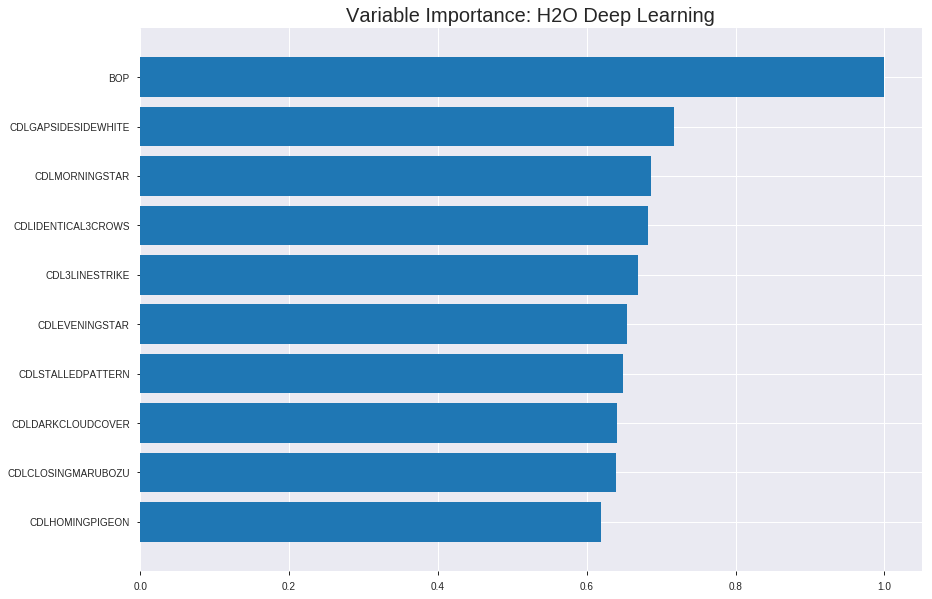

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_121319_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20077105482001564
RMSE: 0.4480748317190061
LogLoss: 0.6030348395571713
Mean Per-Class Error: 0.2883995608443122
AUC: 0.7741668437455731
pr_auc: 0.7309975317641508
Gini: 0.5483336874911462
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3021453360080787: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      433  291  0.4019   (291.0/724.0)
1      122  502  0.1955   (122.0/624.0)
Total  555  793  0.3064   (413.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.302145     0.708539  262
max f2                       0.0989502    0.835887  347
max f0point5                 0.507868     0.688025  184
max accuracy                 0.409375     0.709941  224
max precision                0.999127     1         0
max recall                   0.00218309   1         398
max specificity              0.999127     1         0
max absolute_mcc             0.409375     0.422072  224
max min_per_class_accuracy   0.431467     0.701657  215
max mean_per_class_accuracy  0.409375     0.7116    224

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 43.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.995051           2.16026   2.16026            1                0.997794   1                           0.997794            0.0224359       0.0224359                  116.026   116.026
    2        0.0200297                   0.989375           1.99408   2.08025            0.923077         0.992302   0.962963                    0.995149            0.0192308       0.0416667                  99.4083   108.025
    3        0.0304154                   0.983309           2.16026   2.10757            1                0.986241   0.97561                     0.992108            0.0224359       0.0641026                  116.026   110.757
    4        0.0400593                   0.975159           1.82791   2.04024            0.846154         0.980391   0.944444                    0.989287            0.0176282       0.0817308                  82.7909   104.024
    5        0.0504451                   0.963149           1.69734   1.96965            0.785714         0.968934   0.911765                    0.985097            0.0176282       0.099359                   69.7344   96.9646
    6        0.100148                    0.905358           1.64437   1.80821            0.761194         0.937798   0.837037                    0.961623            0.0817308       0.18109                    64.4374   80.8215
    7        0.150593                    0.844439           1.8108    1.80908            0.838235         0.8719     0.837438                    0.931568            0.0913462       0.272436                   81.0803   80.9082
    8        0.200297                    0.766831           1.38643   1.7042             0.641791         0.804152   0.788889                    0.89995             0.0689103       0.341346                   38.6433   70.4202
    9        0.300445                    0.640597           1.32816   1.57885            0.614815         0.709954   0.730864                    0.836618            0.133013        0.474359                   32.8158   57.8854
    10       0.399852                    0.522045           1.35419   1.523              0.626866         0.583498   0.705009                    0.77369             0.134615        0.608974                   35.4191   52.3001
    11       0.5                         0.416307           1.13613   1.44551            0.525926         0.466891   0.669139                    0.712239            0.113782        0.722756                   13.6135   44.5513
    12       0.600148                    0.293866           0.896106  1.35383            0.414815         0.350678   0.6267                      0.651905            0.0897436       0.8125                     -10.3894  35.3832
    13       0.699555                    0.185944           0.693217  1.25996            0.320896         0.246373   0.583245                    0.594279            0.0689103       0.88141                    -30.6783  25.9959
    14       0.799703                    0.105459           0.67208   1.18634            0.311111         0.145477   0.549165                    0.538074            0.0673077       0.948718                   -32.792   18.6337
    15       0.899852                    0.0404777          0.33604   1.0917             0.155556         0.0688027  0.505359                    0.485847            0.0336538       0.982372                   -66.396   9.17042
    16       1                           5.68147e-09        0.176021  1                  0.0814815        0.0163253  0.462908                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3368296022611394
RMSE: 0.5803702286137181
LogLoss: 1.2035443994250639
Mean Per-Class Error: 0.33513396715643906
AUC: 0.7192361711322385
pr_auc: 0.6833673088756697
Gini: 0.43847234226447696
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.009464546057992148: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      67   141  0.6779   (141.0/208.0)
1      14   164  0.0787   (14.0/178.0)
Total  81   305  0.4016   (155.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00946455   0.679089  304
max f2                       0.00518485   0.818882  325
max f0point5                 0.061609     0.637813  174
max accuracy                 0.061609     0.665803  174
max precision                0.912786     1         0
max recall                   0.000164204  1         377
max specificity              0.912786     1         0
max absolute_mcc             0.0350936    0.33251   221
max min_per_class_accuracy   0.0555062    0.640449  185
max mean_per_class_accuracy  0.0350936    0.664866  221

Gains/Lift Table: Avg response rate: 46.11 %, avg score: 12.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.763108           2.16854   2.16854            1                0.851621    1                           0.851621            0.0224719       0.0224719                  116.854   116.854
    2        0.0207254                   0.658135           2.16854   2.16854            1                0.711826    1                           0.781723            0.0224719       0.0449438                  116.854   116.854
    3        0.0310881                   0.598063           1.6264    1.98783            0.75             0.624759    0.916667                    0.729402            0.0168539       0.0617978                  62.6404   98.7828
    4        0.0414508                   0.507689           2.16854   2.03301            1                0.552526    0.9375                      0.685183            0.0224719       0.0842697                  116.854   103.301
    5        0.0518135                   0.488181           1.6264    1.95169            0.75             0.501093    0.9                         0.648365            0.0168539       0.101124                   62.6404   95.1685
    6        0.101036                    0.338266           1.48374   1.72371            0.684211         0.398829    0.794872                    0.526796            0.0730337       0.174157                   48.3737   72.3711
    7        0.150259                    0.256246           1.3696    1.60771            0.631579         0.296357    0.741379                    0.451307            0.0674157       0.241573                   36.9604   60.771
    8        0.202073                    0.19867            1.51798   1.5847             0.7              0.224657    0.730769                    0.393192            0.0786517       0.320225                   51.7978   58.4702
    9        0.300518                    0.124442           1.31254   1.49554            0.605263         0.160324    0.689655                    0.316908            0.129213        0.449438                   31.2537   49.5544
    10       0.401554                    0.0762019          1.11207   1.39906            0.512821         0.10113     0.645161                    0.262615            0.11236         0.561798                   11.2071   39.9058
    11       0.5                         0.0500187          0.913069  1.30337            0.421053         0.0626021   0.601036                    0.223234            0.0898876       0.651685                   -8.69308  30.3371
    12       0.601036                    0.0326265          1.16768   1.28056            0.538462         0.0398508   0.590517                    0.192407            0.117978        0.769663                   16.7675   28.056
    13       0.699482                    0.0206695          0.741869  1.20474            0.342105         0.025949    0.555556                    0.16898             0.0730337       0.842697                   -25.8131  20.4744
    14       0.800518                    0.00884004         0.834054  1.15796            0.384615         0.0147842   0.533981                    0.149518            0.0842697       0.926966                   -16.5946  15.7958
    15       0.898964                    0.00281129         0.399468  1.0749             0.184211         0.00506114  0.495677                    0.133699            0.0393258       0.966292                   -60.0532  7.48956
    16       1                           7.08631e-06        0.333621  1                  0.153846         0.00100071  0.46114    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:17:20  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 12:17:21  3 min 53.711 sec  355 obs/sec       0.270772  1             365        0.623627         3.10538             -0.564249      0.597362        0.441413           1.54304          0.537092                         0.708497           8.24662               -1.02007         0.590239          0.242499             1.6264             0.46114
    2019-08-25 12:17:32  4 min  5.096 sec  445 obs/sec       3.75445   14            5061       0.526126         1.777               -0.113362      0.755585        0.488088           2.00595          0.343472                         0.633136           3.83453               -0.61319         0.699411          0.499826             2.16854            0.34715
    2019-08-25 12:17:43  4 min 16.099 sec  478 obs/sec       7.56454   28            10197      0.57057          2.37407             -0.309408      0.709314        0.653736           2.16026          0.379822                         0.678667           10.4043               -0.853553        0.686582          0.646917             2.16854            0.388601
    2019-08-25 12:17:54  4 min 27.204 sec  496 obs/sec       11.5519   43            15572      0.556238         1.95861             -0.244451      0.697501        0.498213           2.16026          0.4273                           0.687136           5.8729                -0.900102        0.686838          0.359485             2.16854            0.373057
    2019-08-25 12:18:05  4 min 37.685 sec  507 obs/sec       15.362    57            20708      0.513711         1.21095             -0.0614377     0.738024        0.606005           2.16026          0.347923                         0.627582           3.30885               -0.585009        0.690687          0.634647             1.6264             0.414508
    2019-08-25 12:18:16  4 min 48.540 sec  515 obs/sec       19.362    72            26100      0.475873         0.832551            0.0891679      0.766756        0.717838           2.16026          0.300445                         0.595851           2.04388               -0.428786        0.681423          0.629463             2.16854            0.401554
    2019-08-25 12:18:26  4 min 59.212 sec  521 obs/sec       23.2982   87            31406      0.494803         0.810267            0.0152626      0.75925         0.725683           2.00595          0.376855                         0.608653           1.82555               -0.49084         0.732498          0.686252             2.16854            0.357513
    2019-08-25 12:18:37  5 min  9.915 sec  526 obs/sec       27.316    102           36822      0.527546         0.981539            -0.11938       0.66554         0.658594           2.16026          0.477003                         0.676975           4.06849               -0.84432         0.666217          0.611996             2.16854            0.38601
    2019-08-25 12:18:48  5

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
BOP                      1.0                    1.0                  0.004407632537995588
CDLGAPSIDESIDEWHITE      0.7173438668251038     0.7173438668251038   0.0031617881683499013
CDLMORNINGSTAR           0.6862735748291016     0.6862735748291016   0.0030248417383832984
CDLIDENTICAL3CROWS       0.6829195618629456     0.6829195618629456   0.00301005848170081
CDL3LINESTRIKE           0.6688954830169678     0.6688954830169678   0.0029482454954638626
---                      ---                    ---                  ---
BBANDS_upperband_24_1_3  0.17647725343704224    0.17647725343704224  0.0007778468844652012
BBANDS_lowerband_30_7_2  0.17455433309078217    0.17455433309078217  0.0007693713581790516
MA_14_0                  0.1739273965358734     0.1739273965358734   0.0007666080522203769
SMA_20                   0.17283543944358826    0.17283543944358826  0.0007617951066103257
BBANDS_upperband_8_1_4   0.17253705859184265    0.17253705859184265  0.000760479953459457


See the whole table with table.as_data_frame()


('accuracy', 0.7202072538860104)

('F1', 0.7085201793721972)

('auc', 0.7525537926537709)

('logloss', 1.3691543833217117)

('mean_per_class_error', 0.2934144751141057)

('rmse', 0.6141554560215062)

('mse', 0.3771869241609842)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


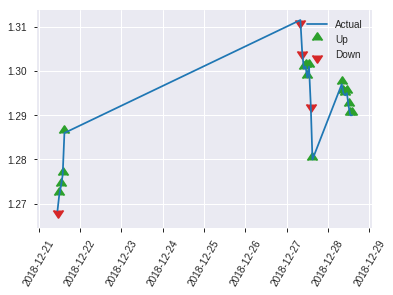


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3771869241609842
RMSE: 0.6141554560215062
LogLoss: 1.3691543833217117
Mean Per-Class Error: 0.2934144751141057
AUC: 0.7525537926537709
pr_auc: 0.645239316174588
Gini: 0.5051075853075417
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00972459410757551: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      49   58   0.5421   (58.0/107.0)
1      7    79   0.0814   (7.0/86.0)
Total  56   137  0.3368   (65.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00972459   0.70852   136
max f2                       0.00822379   0.836735  145
max f0point5                 0.0522912    0.703593  61
max accuracy                 0.0522912    0.720207  61
max precision                0.551865     1         0
max recall                   0.00241406   1         175
max specificity              0.551865     1         0
max absolute_mcc             0.0522912    0.432497  61
max min_per_class_accuracy   0.0318719    0.651163  89
max mean_per_class_accuracy  0.0479143    0.706586  67

Gains/Lift Table: Avg response rate: 44.56 %, avg score:  6.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.480858           2.24419   2.24419            1                0.528068    1                           0.528068            0.0232558       0.0232558                  124.419   124.419
    2        0.0207254                   0.45225            1.12209   1.68314            0.5              0.465774    0.75                        0.496921            0.0116279       0.0348837                  12.2093   68.314
    3        0.0310881                   0.345672           1.12209   1.49612            0.5              0.43143     0.666667                    0.475091            0.0116279       0.0465116                  12.2093   49.6124
    4        0.0414508                   0.299063           1.12209   1.40262            0.5              0.31373     0.625                       0.434751            0.0116279       0.0581395                  12.2093   40.2616
    5        0.0518135                   0.267059           1.12209   1.34651            0.5              0.282488    0.6                         0.404298            0.0116279       0.0697674                  12.2093   34.6512
    6        0.103627                    0.164859           1.34651   1.34651            0.6              0.201313    0.6                         0.302806            0.0697674       0.139535                   34.6512   34.6512
    7        0.150259                    0.119703           1.49612   1.39294            0.666667         0.141764    0.62069                     0.252827            0.0697674       0.209302                   49.6124   39.2943
    8        0.202073                    0.0987493          2.01977   1.55367            0.9              0.10882     0.692308                    0.215902            0.104651        0.313953                   101.977   55.3667
    9        0.300518                    0.0599122          1.88984   1.66379            0.842105         0.0773085   0.741379                    0.170501            0.186047        0.5                        88.9841   66.3793
    10       0.398964                    0.040983           1.18115   1.5447             0.526316         0.0480263   0.688312                    0.14028             0.116279        0.616279                   18.1151   54.4699
    11       0.502591                    0.0262639          0.561047  1.34188            0.25             0.0332829   0.597938                    0.118219            0.0581395       0.674419                   -43.8953  34.1884
    12       0.601036                    0.0154603          1.18115   1.31556            0.526316         0.0196601   0.586207                    0.102075            0.116279        0.790698                   18.1151   31.5557
    13       0.699482                    0.0103602          1.06304   1.28002            0.473684         0.0127335   0.57037                     0.0895014           0.104651        0.895349                   6.30355   28.0017
    14       0.797927                    0.00592633         0.70869   1.20953            0.315789         0.00841118  0.538961                    0.0794967           0.0697674       0.965116                   -29.131   20.9529
    15       0.896373                    0.00258818         0.23623   1.10263            0.105263         0.00360447  0.491329                    0.0711617           0.0232558       0.988372                   -76.377   10.2635
    16       1                           0.000153347        0.112209  1                  0.05             0.00122616  0.445596  

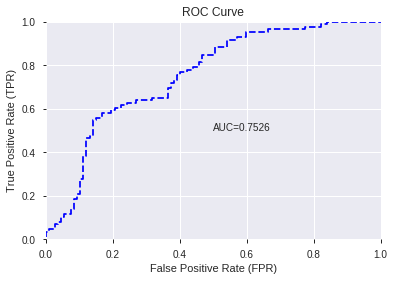

This function is available for GLM models only


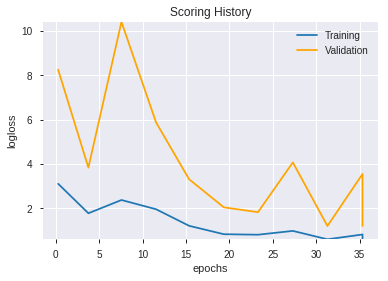

--2019-08-25 12:47:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.94.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.94.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  45.6MB/s    in 8.1s    

2019-08-25 12:47:26 (43.2 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unkno

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_121319_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_121319_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a23f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [0]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_124735_model_7  0.783091  0.650242              0.275484  0.463477  0.214811
1  DeepLearning_grid_1_AutoML_20190825_124735_model_6  0.780048  0.560428              0.281189  0.439299  0.192984
2  DeepLearning_grid_1_AutoML_20190825_124735_model_5  0.779504  0.572471              0.263638  0.442209  0.195549
3  DeepLearning_grid_1_AutoML_20190825_124735_model_9  0.775592  0.572965              0.316399  0.442766  0.196042
4  DeepLearning_grid_1_AutoML_20190825_124735_model_8  0.774071  0.576079              0.306020  0.439994  0.193594
5  DeepLearning_grid_1_AutoML_20190825_124735_model_3  0.769724  0.654176              0.293034  0.453641  0.205790
6  DeepLearning_grid_1_AutoML_20190825_124735_model_1  0.742393  0.775095              0.324603  0.469233  0.220180
7               DeepLearning_1_AutoML_20190825_124735  0.729624  0.662409              0.297490  0.472967  0.223698
8  DeepLearning_grid_1_AutoML_20190825_124735_model_4  0.727777  0.916066              0.310367  0.505718  0.255750
9  DeepLearning_grid_1_AutoML_20190825_124735_model_2  0.726690  0.712514              0.317431  0.483779  0.234042

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.023979
1    CDLCLOSINGMARUBOZU             0.919177           0.919177    0.022041
2           CDLLONGLINE             0.899754           0.899754    0.021576
3                  hour             0.884298           0.884298    0.021205
4           CDLPIERCING             0.868099           0.868099    0.020816
5                SAREXT             0.865796           0.865796    0.020761
6          CDLTHRUSTING             0.861236           0.861236    0.020652
7                TRANGE             0.857349           0.857349    0.020559
8             dayofweek             0.852637           0.852637    0.020446
9                   DIV             0.850219           0.850219    0.020388
10        days_in_month             0.847879           0.847879    0.020332
11       CDLMORNINGSTAR             0.846614           0.846614    0.020301
12             CORREL_8             0.846554           0.846554    0.020300
13  CDLGAPSIDESIDEWHITE             0.844213           0.844213    0.020244
14   CDLSEPARATINGLINES             0.841987           0.841987    0.020190
15               Volume             0.841899           0.841899    0.020188
16        CDLHANGINGMAN             0.841333           0.841333    0.020175
17    CDLSTALLEDPATTERN             0.841107           0.841107    0.020169
18    CDL3WHITESOLDIERS             0.840705           0.840705    0.020160
19           aroonup_20             0.840302           0.840302    0.020150
20           CDL3INSIDE             0.839296           0.839296    0.020126
21       CDLMATCHINGLOW             0.839117           0.839117    0.020122
22      CDLLADDERBOTTOM             0.834352           0.834352    0.020007
23                VAR_8             0.834258           0.834258    0.020005
24                  SUB             0.828971           0.828971    0.019878
25      CDLHOMINGPIGEON             0.828521           0.828521    0.019867
26      CDLADVANCEBLOCK             0.828323           0.828323    0.019863
27          CDLMARUBOZU             0.828099           0.828099    0.019857
28                  day             0.826563           0.826563    0.019820
29    CDLINVERTEDHAMMER             0.824324           0.824324    0.019767
30   CDLIDENTICAL3CROWS             0.822032           0.822032    0.019712
31    CDLGRAVESTONEDOJI             0.821408           0.821408    0.019697
32         STOCHF_fastk             0.819957           0.819957    0.019662
33         CDLTASUKIGAP             0.819913           0.819913    0.019661
34            CDLTAKURI             0.818751           0.818751    0.019633
35         is_month_end             0.816633           0.816633    0.019582
36       CDL3LINESTRIKE             0.816605           0.816605    0.019582
37       STOCHRSI_fastk             0.815648           0.815648    0.019559
38     CDLDRAGONFLYDOJI             0.812735           0.812735    0.019489
39    CDLDARKCLOUDCOVER             0.810314           0.810314    0.019431
40               ULTOSC             0.806393           0.806393    0.019337
41              weekday             0.805973           0.805973    0.019327
42         HT_TRENDMODE             0.804616           0.804616    0.019294
43       CDLEVENINGSTAR             0.803236           0.803236    0.019261
44          CDLDOJISTAR             0.795613           0.795613    0.019078
45              WILLR_8             0.794863           0.794863    0.019060
46            CDLHAMMER             0.789682           0.789682    0.018936
47      CDLSHOOTINGSTAR             0.786549           0.786549    0.018861
48       is_month_start             0.779915           0.779915    0.018702
49  CDLXSIDEGAP3METHODS             0.758649           0.758649    0.018192

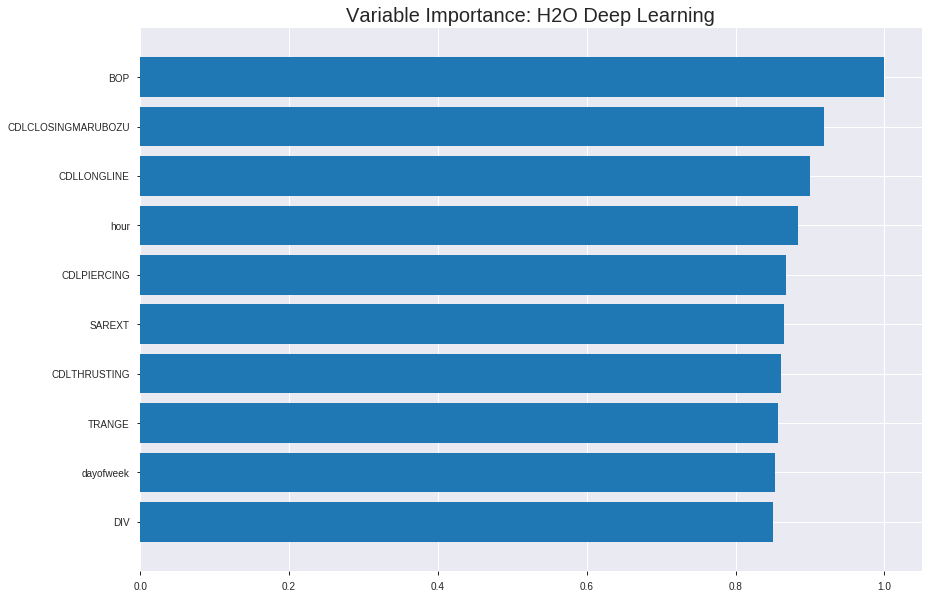

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_124735_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1805202745187925
RMSE: 0.42487677568771925
LogLoss: 0.5371606215213823
Mean Per-Class Error: 0.2650251452047032
AUC: 0.815462751452047
pr_auc: 0.7626307049154496
Gini: 0.6309255029040941
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18718438659679001: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      356  368  0.5083   (368.0/724.0)
1      52   572  0.0833   (52.0/624.0)
Total  408  940  0.3116   (420.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.187184     0.731458  307
max f2                       0.0657994    0.845792  358
max f0point5                 0.434278     0.715529  196
max accuracy                 0.33283      0.732196  240
max precision                0.983032     0.986111  10
max recall                   0.00346215   1         396
max specificity              0.999899     0.998619  0
max absolute_mcc             0.33283      0.469031  240
max min_per_class_accuracy   0.367949     0.727901  225
max mean_per_class_accuracy  0.33283      0.734975  240

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 39.21 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.999879           2.16026    2.16026            1                0.999957    1                           0.999957            0.0224359       0.0224359                  116.026   116.026
    2        0.0200297                   0.999197           1.99408    2.08025            0.923077         0.999664    0.962963                    0.999816            0.0192308       0.0416667                  99.4083   108.025
    3        0.0304154                   0.997819           2.16026    2.10757            1                0.99862     0.97561                     0.999408            0.0224359       0.0641026                  116.026   110.757
    4        0.0400593                   0.993741           2.16026    2.12025            1                0.996032    0.981481                    0.998595            0.0208333       0.0849359                  116.026   112.025
    5        0.0504451                   0.986549           2.16026    2.12849            1                0.990045    0.985294                    0.996834            0.0224359       0.107372                   116.026   112.849
    6        0.100148                    0.861597           1.9668     2.04824            0.910448         0.923629    0.948148                    0.960503            0.0977564       0.205128                   96.6801   104.824
    7        0.150593                    0.730036           1.74727    1.94742            0.808824         0.802942    0.901478                    0.907724            0.088141        0.293269                   74.7266   94.7423
    8        0.200297                    0.642401           1.5154     1.84022            0.701493         0.683897    0.851852                    0.852182            0.0753205       0.36859                    51.5404   84.0218
    9        0.300445                    0.534304           1.44017    1.70687            0.666667         0.5845      0.790123                    0.762955            0.144231        0.512821                   44.0171   70.6869
    10       0.399852                    0.448738           1.22522    1.58713            0.567164         0.492984    0.734694                    0.695838            0.121795        0.634615                   22.522    58.7127
    11       0.5                         0.35034            1.12013    1.49359            0.518519         0.398501    0.691395                    0.636282            0.112179        0.746795                   12.0133   49.359
    12       0.600148                    0.273009           0.92811    1.39923            0.42963          0.311063    0.647713                    0.582012            0.0929487       0.839744                   -7.18898  39.9227
    13       0.699555                    0.184697           0.773823   1.31036            0.358209         0.2297      0.606575                    0.531948            0.0769231       0.916667                   -22.6177  31.0357
    14       0.799703                    0.0906799          0.480057   1.20638            0.222222         0.140406    0.558442                    0.482915            0.0480769       0.964744                   -51.9943  20.6377
    15       0.899852                    0.0240101          0.272032   1.10239            0.125926         0.0503654   0.510305                    0.434775            0.0272436       0.991987                   -72.7968  10.239
    16       1                           3.76053e-07        0.0800095  1                  0.037037         0.008



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20202637357281092
RMSE: 0.4494734403419305
LogLoss: 0.6453166104699856
Mean Per-Class Error: 0.2854364736387208
AUC: 0.7780628781331029
pr_auc: 0.7414472450182621
Gini: 0.5561257562662059
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2626511654475072: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      116  92   0.4423   (92.0/208.0)
1      26   152  0.1461   (26.0/178.0)
Total  142  244  0.3057   (118.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.262651     0.720379  243
max f2                       0.00963669   0.829384  342
max f0point5                 0.495445     0.714286  133
max accuracy                 0.495445     0.720207  133
max precision                0.999988     1         0
max recall                   0.000452773  1         373
max specificity              0.999988     1         0
max absolute_mcc             0.495445     0.438932  133
max min_per_class_accuracy   0.368269     0.701923  186
max mean_per_class_accuracy  0.335091     0.714564  209

Gains/Lift Table: Avg response rate: 46.11 %, avg score: 38.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.999674           2.16854   2.16854            1                0.999876    1                           0.999876            0.0224719       0.0224719                  116.854   116.854
    2        0.0207254                   0.998287           2.16854   2.16854            1                0.999352    1                           0.999614            0.0224719       0.0449438                  116.854   116.854
    3        0.0310881                   0.986534           2.16854   2.16854            1                0.99189     1                           0.997039            0.0224719       0.0674157                  116.854   116.854
    4        0.0414508                   0.960486           1.6264    2.03301            0.75             0.975939    0.9375                      0.991764            0.0168539       0.0842697                  62.6404   103.301
    5        0.0518135                   0.931713           1.6264    1.95169            0.75             0.935408    0.9                         0.980493            0.0168539       0.101124                   62.6404   95.1685
    6        0.101036                    0.803233           1.712     1.83492            0.789474         0.874515    0.846154                    0.928863            0.0842697       0.185393                   71.2005   83.4918
    7        0.150259                    0.710683           1.712     1.79465            0.789474         0.758322    0.827586                    0.872996            0.0842697       0.269663                   71.2005   79.4653
    8        0.202073                    0.657527           1.51798   1.72371            0.7              0.67941     0.794872                    0.823358            0.0786517       0.348315                   51.7978   72.3711
    9        0.300518                    0.544728           1.48374   1.6451             0.684211         0.601278    0.758621                    0.750608            0.146067        0.494382                   48.3737   64.5099
    10       0.401554                    0.454291           1.22328   1.53896            0.564103         0.493353    0.709677                    0.685879            0.123596        0.617978                   22.3279   53.8963
    11       0.5                         0.362343           1.08427   1.44944            0.5              0.400238    0.668394                    0.629639            0.106742        0.724719                   8.42697   44.9438
    12       0.601036                    0.28224            0.945261  1.36468            0.435897         0.326104    0.62931                     0.578614            0.0955056       0.820225                   -5.47393  36.4684
    13       0.699482                    0.160936           0.570668  1.25293            0.263158         0.226629    0.577778                    0.529075            0.0561798       0.876404                   -42.9332  25.2934
    14       0.800518                    0.0398464          0.611639  1.17199            0.282051         0.090296    0.540453                    0.473695            0.0617978       0.938202                   -38.8361  17.1994
    15       0.898964                    0.00675857         0.456535  1.09364            0.210526         0.0211689   0.504323                    0.424139            0.0449438       0.983146                   -54.3465  9.36438
    16       1                           1.53142e-05        0.166811  1                  0.0769231        0.00169347  0.46114  


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:52:25  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 12:52:31  6.716 sec         243 obs/sec       1         1             1348       0.527063         0.818696            -0.117331      0.711351        0.681451           2.16026          0.400593                         0.520416           0.803582              -0.0899153       0.716589          0.676811             2.16854            0.354922
    2019-08-25 12:52:44  21.089 sec        455 obs/sec       6         6             8088       0.424877         0.537161            0.273923       0.815463        0.762631           2.16026          0.311573                         0.449473           0.645317              0.186984         0.778063          0.741447             2.16854            0.305699
    2019-08-25 12:53:07  42.582 sec        530 obs/sec       15        15            20220      0.383723         0.442858            0.407769       0.87592         0.793719           2.16026          0.224777                         0.464605           0.728256              0.13132          0.762127          0.723671             2.16854            0.34456
    2019-08-25 12:53:19  54.728 sec        548 obs/sec       20        20            26960      0.375126         0.423165            0.434007       0.88722         0.804258           2.16026          0.219585                         0.474433           0.792706              0.0941807        0.761803          0.729128             2.16854            0.349741
    2019-08-25 12:53:31  1 min  6.689 sec  561 obs/sec       25        25            33700      0.375558         0.425846            0.432702       0.918122        0.822482           2.16026          0.169881                         0.488572           0.940401              0.0393884        0.759291          0.728303             2.16854            0.310881
    2019-08-25 12:53:43  1 min 18.671 sec  570 obs/sec       30        30            40440      0.337264         0.352436            0.542493       0.92402         0.770645           2.16026          0.160237                         0.481782           0.907669              0.0659029        0.763127          0.726509             2.16854            0.349741
    2019-08-25 12:53:44  1 min 19.759 sec  569 obs/sec       30        30            40440      0.424877         0.537161            0.273923       0.815463        0.762631           2.16026          0.311573                         0.449473           0.645317              0.186984         0.778063          0.741447             2.16854            0.305699

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
BOP                  1.0                    1.0                  0.023979397450537055
CDLCLOSINGMARUBOZU   0.9191774725914001     0.9191774725914001   0.022041321942849315
CDLLONGLINE          0.8997540473937988     0.8997540473937988   0.021575559910185255
hour                 0.8842984437942505     0.8842984437942505   0.021204943848633737
CDLPIERCING          0.8680986762046814     0.8680986762046814   0.020816483182997128
---                  ---                    ---                  ---
WILLR_8              0.7948627471923828     0.7948627471923828   0.019060329733551904
CDLHAMMER            0.7896819114685059     0.7896819114685059   0.01893609641460312
CDLSHOOTINGSTAR      0.78654944896698       0.78654944896698     0.018860981851280125
is_month_start       0.7799153923988342     0.7799153923988342   0.01870190117212321
CDLXSIDEGAP3METHODS  0.7586490511894226     0.7586490511894226   0.018191947123943997


See the whole table with table.as_data_frame()


('accuracy', 0.7253886010362695)

('F1', 0.7323943661971831)

('auc', 0.7830906324712019)

('logloss', 0.6502424910353006)

('mean_per_class_error', 0.2754835905237992)

('rmse', 0.46347698164601014)

('mse', 0.214810912515696)

deeplearning prediction progress: |███████████████████████████████████████| 100%


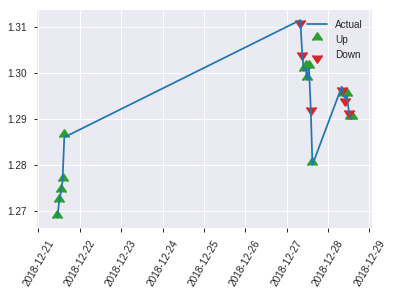


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.214810912515696
RMSE: 0.46347698164601014
LogLoss: 0.6502424910353006
Mean Per-Class Error: 0.2754835905237992
AUC: 0.7830906324712019
pr_auc: 0.6735035500157537
Gini: 0.5661812649424038
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2073287531269815: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      58   49   0.4579   (49.0/107.0)
1      8    78   0.093    (8.0/86.0)
Total  66   127  0.2953   (57.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.207329     0.732394  126
max f2                       0.0654606    0.86      155
max f0point5                 0.41516      0.706215  66
max accuracy                 0.41516      0.725389  66
max precision                0.999966     1         0
max recall                   0.0654606    1         155
max specificity              0.999966     1         0
max absolute_mcc             0.207329     0.470485  126
max min_per_class_accuracy   0.300722     0.691589  92
max mean_per_class_accuracy  0.207329     0.724516  126

Gains/Lift Table: Avg response rate: 44.56 %, avg score: 35.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.999651           1.12209   1.12209            0.5              0.999902   0.5                         0.999902            0.0116279       0.0116279                  12.2093   12.2093
    2        0.0207254                   0.994017           2.24419   1.68314            1                0.999614   0.75                        0.999758            0.0232558       0.0348837                  124.419   68.314
    3        0.0310881                   0.980716           2.24419   1.87016            1                0.987751   0.833333                    0.995756            0.0232558       0.0581395                  124.419   87.0155
    4        0.0414508                   0.975011           1.12209   1.68314            0.5              0.977721   0.75                        0.991247            0.0116279       0.0697674                  12.2093   68.314
    5        0.0518135                   0.962897           2.24419   1.79535            1                0.970898   0.8                         0.987177            0.0232558       0.0930233                  124.419   79.5349
    6        0.103627                    0.880476           1.34651   1.57093            0.6              0.927565   0.7                         0.957371            0.0697674       0.162791                   34.6512   57.093
    7        0.150259                    0.72964            1.24677   1.47033            0.555556         0.810082   0.655172                    0.911661            0.0581395       0.22093                    24.677    47.0329
    8        0.202073                    0.560424           2.01977   1.61121            0.9              0.654306   0.717949                    0.845672            0.104651        0.325581                   101.977   61.121
    9        0.300518                    0.455862           1.5355    1.58641            0.684211         0.49957    0.706897                    0.732294            0.151163        0.476744                   53.5496   58.6407
    10       0.398964                    0.357613           1.65361   1.60299            0.736842         0.411294   0.714286                    0.653086            0.162791        0.639535                   65.3611   60.299
    11       0.502591                    0.284551           0.897674  1.45756            0.4              0.321163   0.649485                    0.584648            0.0930233       0.732558                   -10.2326  45.7564
    12       0.601036                    0.231789           0.826805  1.35425            0.368421         0.251381   0.603448                    0.530062            0.0813953       0.813953                   -17.3195  35.425
    13       0.699482                    0.15126            1.06304   1.31326            0.473684         0.201577   0.585185                    0.48383             0.104651        0.918605                   6.30355   31.3264
    14       0.797927                    0.069119           0.70869   1.23867            0.315789         0.101316   0.551948                    0.436637            0.0697674       0.988372                   -29.131   23.8674
    15       0.896373                    0.0152386          0.118115  1.11561            0.0526316        0.0384867  0.49711                     0.39291             0.0116279       1                          -88.1885  11.5607
    16       1                           0.00018219         0         1                  0                0.0052801  0.445596                    0.352

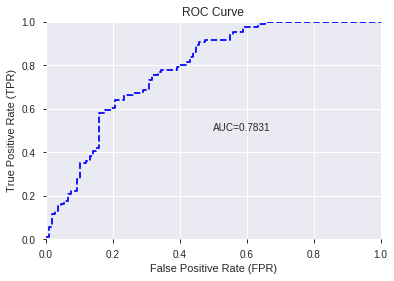

This function is available for GLM models only


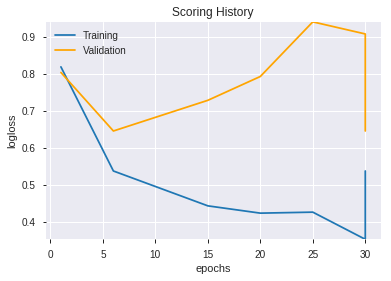

--2019-08-25 12:56:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_124735_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_124735_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a23f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'hour',
 'CDLPIERCING',
 'SAREXT',
 'CDLTHRUSTING',
 'TRANGE',
 'dayofweek',
 'DIV',
 'days_in_month',
 'CDLMORNINGSTAR',
 'CORREL_8',
 'CDLGAPSIDESIDEWHITE',
 'CDLSEPARATINGLINES',
 'Volume',
 'CDLHANGINGMAN',
 'CDLSTALLEDPATTERN',
 'CDL3WHITESOLDIERS',
 'aroonup_20',
 'CDL3INSIDE',
 'CDLMATCHINGLOW',
 'CDLLADDERBOTTOM',
 'VAR_8',
 'SUB',
 'CDLHOMINGPIGEON',
 'CDLADVANCEBLOCK',
 'CDLMARUBOZU',
 'day',
 'CDLINVERTEDHAMMER',
 'CDLIDENTICAL3CROWS',
 'CDLGRAVESTONEDOJI',
 'STOCHF_fastk',
 'CDLTASUKIGAP',
 'CDLTAKURI',
 'is_month_end',
 'CDL3LINESTRIKE',
 'STOCHRSI_fastk',
 'CDLDRAGONFLYDOJI',
 'CDLDARKCLOUDCOVER',
 'ULTOSC',
 'weekday',
 'HT_TRENDMODE',
 'CDLEVENINGSTAR',
 'CDLDOJISTAR',
 'WILLR_8',
 'CDLHAMMER',
 'CDLSHOOTINGSTAR',
 'is_month_start',
 'CDLXSIDEGAP3METHODS']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_125725_model_1  0.769724  0.569015              0.292925  0.440578  0.194109

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.681319           1.000000    0.176840
1    CDLCLOSINGMARUBOZU             0.339041           0.497625    0.088000
2                   SUB             0.229245           0.336473    0.059502
3                  hour             0.226044           0.331775    0.058671
4                ULTOSC             0.179912           0.264064    0.046697
5                SAREXT             0.138651           0.203503    0.035988
6           CDLPIERCING             0.132416           0.194352    0.034369
7   CDLGAPSIDESIDEWHITE             0.126201           0.185230    0.032756
8    CDLIDENTICAL3CROWS             0.109066           0.160080    0.028309
9                Volume             0.107365           0.157585    0.027867
10      CDLHOMINGPIGEON             0.093746           0.137595    0.024332
11       CDL3LINESTRIKE             0.088246           0.129522    0.022905
12           aroonup_20             0.083095           0.121962    0.021568
13        days_in_month             0.082934           0.121726    0.021526
14       CDLMORNINGSTAR             0.080616           0.118323    0.020924
15          CDLLONGLINE             0.080581           0.118273    0.020915
16            CDLHAMMER             0.071582           0.105064    0.018580
17      CDLLADDERBOTTOM             0.064041           0.093995    0.016622
18        CDLHANGINGMAN             0.060331           0.088550    0.015659
19               TRANGE             0.058535           0.085915    0.015193
20            dayofweek             0.058251           0.085498    0.015119
21              weekday             0.057892           0.084971    0.015026
22      CDLSHOOTINGSTAR             0.052705           0.077358    0.013680
23                  day             0.048832           0.071673    0.012675
24         CDLTHRUSTING             0.047637           0.069919    0.012365
25             CORREL_8             0.046479           0.068219    0.012064
26    CDLINVERTEDHAMMER             0.045898           0.067366    0.011913
27    CDLGRAVESTONEDOJI             0.044665           0.065557    0.011593
28    CDL3WHITESOLDIERS             0.043021           0.063144    0.011166
29       STOCHRSI_fastk             0.042509           0.062393    0.011034
30   CDLSEPARATINGLINES             0.038207           0.056078    0.009917
31     CDLDRAGONFLYDOJI             0.035565           0.052200    0.009231
32       CDLEVENINGSTAR             0.030643           0.044976    0.007954
33                VAR_8             0.029869           0.043839    0.007753
34       CDLMATCHINGLOW             0.028979           0.042533    0.007522
35         is_month_end             0.026715           0.039210    0.006934
36  CDLXSIDEGAP3METHODS             0.026391           0.038734    0.006850
37            CDLTAKURI             0.023126           0.033943    0.006002
38              WILLR_8             0.017438           0.025594    0.004526
39    CDLDARKCLOUDCOVER             0.016115           0.023652    0.004183
40          CDLDOJISTAR             0.013050           0.019154    0.003387
41    CDLSTALLEDPATTERN             0.010350           0.015191    0.002686
42           CDL3INSIDE             0.009088           0.013339    0.002359
43         STOCHF_fastk             0.006318           0.009274    0.001640
44         HT_TRENDMODE             0.005496           0.008067    0.001427
45         CDLTASUKIGAP             0.004408           0.006470    0.001144
46                  DIV             0.004266           0.006261    0.001107
47      CDLADVANCEBLOCK             0.003953           0.005802    0.001026
48       is_month_start             0.001211           0.001777    0.000314
49          CDLMARUBOZU             0.000698           0.001024    0.000181

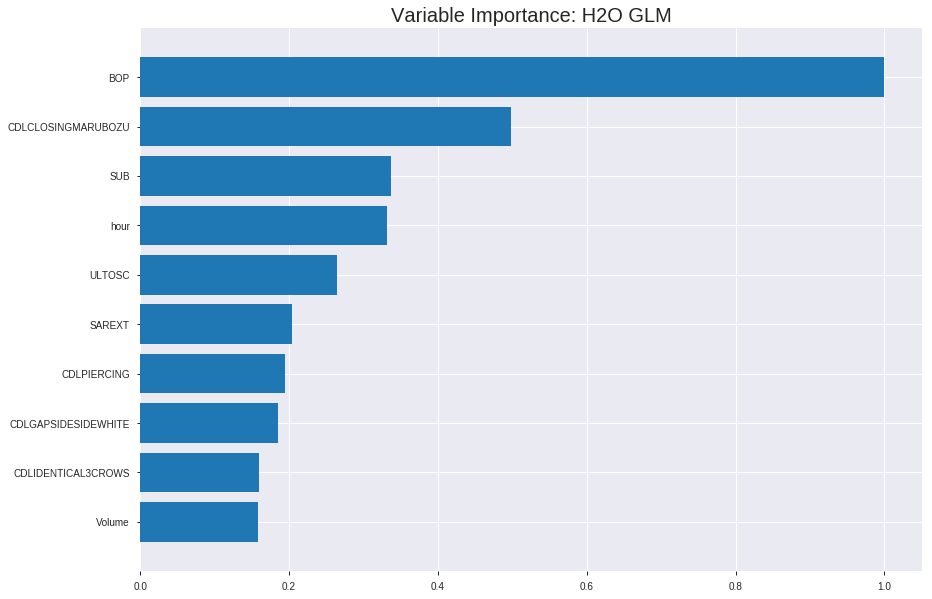

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_125725_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19098163382655264
RMSE: 0.4370144549400542
LogLoss: 0.559846227336136
Null degrees of freedom: 1347
Residual degrees of freedom: 1297
Null deviance: 1861.2995819096327
Residual deviance: 1509.3454288982225
AIC: 1611.3454288982225
AUC: 0.7783414789630259
pr_auc: 0.7452198808837991
Gini: 0.5566829579260517
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3923219435114517: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      431  293  0.4047   (293.0/724.0)
1      110  514  0.1763   (110.0/624.0)
Total  541  807  0.299    (403.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.392322     0.718379  238
max f2                       0.223482     0.835408  318
max f0point5                 0.547024     0.695915  160
max accuracy                 0.543766     0.709199  162
max precision                0.990428     1         0
max recall                   0.0635088    1         382
max specificity              0.990428     1         0
max absolute_mcc             0.392322     0.426248  238
max min_per_class_accuracy   0.467733     0.701657  201
max mean_per_class_accuracy  0.404627     0.710365  232

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 46.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.933404           2.16026   2.16026            1                0.956196   1                           0.956196            0.0224359       0.0224359                  116.026   116.026
    2        0.0200297                   0.912487           1.99408   2.08025            0.923077         0.923479   0.962963                    0.940443            0.0192308       0.0416667                  99.4083   108.025
    3        0.0304154                   0.89267            2.16026   2.10757            1                0.900788   0.97561                     0.926903            0.0224359       0.0641026                  116.026   110.757
    4        0.0400593                   0.877931           1.82791   2.04024            0.846154         0.885081   0.944444                    0.916835            0.0176282       0.0817308                  82.7909   104.024
    5        0.0504451                   0.853781           1.85165   2.00141            0.857143         0.864855   0.926471                    0.906133            0.0192308       0.100962                   85.1648   100.141
    6        0.100148                    0.769454           1.70886   1.85622            0.791045         0.806669   0.859259                    0.85677             0.0849359       0.185897                   70.886    85.622
    7        0.150593                    0.718607           1.68373   1.79844            0.779412         0.740242   0.832512                    0.817736            0.0849359       0.270833                   68.3729   79.844
    8        0.200297                    0.672004           1.28971   1.6722             0.597015         0.697363   0.774074                    0.787865            0.0641026       0.334936                   28.9705   67.2198
    9        0.300445                    0.597062           1.52018   1.62153            0.703704         0.635803   0.750617                    0.737178            0.152244        0.487179                   52.018    62.1526
    10       0.399852                    0.529044           1.25746   1.53102            0.58209          0.56288    0.70872                     0.693846            0.125           0.612179                   25.7463   53.1017
    11       0.5                         0.456879           1.07213   1.4391             0.496296         0.493241   0.666172                    0.653665            0.107372        0.719551                   7.21273   43.9103
    12       0.600148                    0.39094            1.04012   1.37252            0.481481         0.423105   0.635352                    0.615191            0.104167        0.823718                   4.01235   37.2524
    13       0.699555                    0.325911           0.61261   1.26454            0.283582         0.358836   0.585366                    0.578763            0.0608974       0.884615                   -38.739   26.454
    14       0.799703                    0.243946           0.640076  1.18634            0.296296         0.287127   0.549165                    0.542241            0.0641026       0.948718                   -35.9924  18.6337
    15       0.899852                    0.148483           0.320038  1.08992            0.148148         0.204279   0.504534                    0.504628            0.0320513       0.980769                   -67.9962  8.99233
    16       1                           0.00258285         0.192023  1                  0.0888889        0.0880499  0.462908                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19532130159518232
RMSE: 0.44195169599763084
LogLoss: 0.5745080612890666
Null degrees of freedom: 385
Residual degrees of freedom: 335
Null deviance: 532.7805186446055
Residual deviance: 443.52022331515946
AIC: 545.5202233151595
AUC: 0.7674481417458945
pr_auc: 0.7124248860555509
Gini: 0.534896283491789
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39097635365203515: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      123  85   0.4087   (85.0/208.0)
1      27   151  0.1517   (27.0/178.0)
Total  150  236  0.2902   (112.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390976     0.729469  235
max f2                       0.226286     0.835777  310
max f0point5                 0.466141     0.685567  197
max accuracy                 0.466141     0.715026  197
max precision                0.968917     1         0
max recall                   0.0231141    1         384
max specificity              0.968917     1         0
max absolute_mcc             0.390976     0.449633  235
max min_per_class_accuracy   0.481773     0.701923  186
max mean_per_class_accuracy  0.390976     0.71983   235

Gains/Lift Table: Avg response rate: 46.11 %, avg score: 46.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.921982           2.16854   2.16854            1                0.942228   1                           0.942228            0.0224719       0.0224719                  116.854    116.854
    2        0.0207254                   0.895709           1.6264    1.89747            0.75             0.912866   0.875                       0.927547            0.0168539       0.0393258                  62.6404    89.7472
    3        0.0310881                   0.87436            2.16854   1.98783            1                0.880847   0.916667                    0.91198             0.0224719       0.0617978                  116.854    98.7828
    4        0.0414508                   0.839132           2.16854   2.03301            1                0.857472   0.9375                      0.898353            0.0224719       0.0842697                  116.854    103.301
    5        0.0518135                   0.821356           1.6264    1.95169            0.75             0.830043   0.9                         0.884691            0.0168539       0.101124                   62.6404    95.1685
    6        0.101036                    0.754135           1.48374   1.72371            0.684211         0.780605   0.794872                    0.833983            0.0730337       0.174157                   48.3737    72.3711
    7        0.150259                    0.714098           1.25547   1.57032            0.578947         0.735391   0.724138                    0.801685            0.0617978       0.235955                   25.547     57.0322
    8        0.202073                    0.677836           1.6264    1.5847             0.75             0.692558   0.730769                    0.773704            0.0842697       0.320225                   62.6404    58.4702
    9        0.300518                    0.613392           1.712     1.6264             0.789474         0.650058   0.75                        0.733199            0.168539        0.488764                   71.2005    62.6404
    10       0.401554                    0.540551           1.05647   1.483              0.487179         0.579237   0.683871                    0.69446             0.106742        0.595506                   5.64679    48.3001
    11       0.5                         0.473868           1.31254   1.44944            0.605263         0.505986   0.668394                    0.657351            0.129213        0.724719                   31.2537    44.9438
    12       0.601036                    0.394594           1.00086   1.37403            0.461538         0.434109   0.633621                    0.619824            0.101124        0.825843                   0.0864304  37.4031
    13       0.699482                    0.321756           0.684802  1.27703            0.315789         0.360832   0.588889                    0.583373            0.0674157       0.893258                   -31.5198   27.7029
    14       0.800518                    0.232077           0.556036  1.18603            0.25641          0.277386   0.546926                    0.544753            0.0561798       0.949438                   -44.3964   18.603
    15       0.898964                    0.124281           0.228267  1.08114            0.105263         0.182594   0.498559                    0.505093            0.0224719       0.97191                    -77.1733   8.1145
    16       1                           0.00906545         0.278018  1                  0.128205         0.0734422  0.46114     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-25 12:57:26  0.000 sec   2            .21E2     51            1.364899894972509   1.3645946441692889
     2019-08-25 12:57:26  0.030 sec   4            .13E2     51            1.3562330913253906  1.3560824025333955
     2019-08-25 12:57:26  0.055 sec   6            .8E1      51            1.3436607801140201  1.343783358689926
     2019-08-25 12:57:26  0.075 sec   8            .49E1     51            1.3263330936148452  1.326941184201864
     2019-08-25 12:57:26  0.092 sec   10           .31E1     51            1.3040783416131638  1.3055155815533397
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-25 12:57:26  0.282 sec   34           .1E-1     51            1.117733556423578   1.1495507950098822
     2019-08-25 12:57:26  0.300 sec   36           .63E-2    51            1.1163843354487388  1.1519549879542144
     2019-08-25 12:57:26  0.316 sec   38           .39E-2    51            1.115356363126258   1.1569315379124394
     2019-08-25 12:57:26  0.337 sec   40           .24E-2    51            1.1145303325958125  1.1652797449175456
     2019-08-25 12:57:26  0.362 sec   42           .15E-2    51            1.113891770051282   1.1771511179380707


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7202072538860104)

('F1', 0.7142857142857143)

('auc', 0.7697239730493372)

('logloss', 0.5690154829736648)

('mean_per_class_error', 0.28678548141708327)

('rmse', 0.44057849991663683)

('mse', 0.19410941458879397)

glm prediction progress: |████████████████████████████████████████████████| 100%


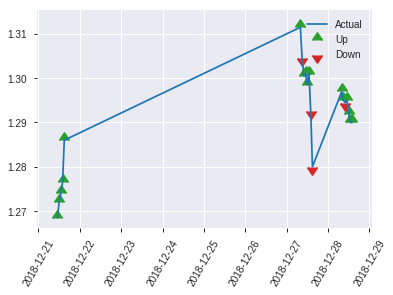


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19410941458879397
RMSE: 0.44057849991663683
LogLoss: 0.5690154829736648
Null degrees of freedom: 192
Residual degrees of freedom: 142
Null deviance: 265.4984131782047
Residual deviance: 219.63997642783463
AIC: 321.63997642783465
AUC: 0.7697239730493372
pr_auc: 0.6528966556469644
Gini: 0.5394479460986743
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3418224343310601: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      58   49   0.4579   (49.0/107.0)
1      11   75   0.1279   (11.0/86.0)
Total  69   124  0.3109   (60.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.341822     0.714286  123
max f2                       0.212216     0.851485  160
max f0point5                 0.545368     0.696721  69
max accuracy                 0.545368     0.720207  69
max precision                0.927459     1         0
max recall                   0.212216     1         160
max specificity              0.927459     1         0
max absolute_mcc             0.341822     0.429499  123
max min_per_class_accuracy   0.490775     0.697674  89
max mean_per_class_accuracy  0.443235     0.713215  97

Gains/Lift Table: Avg response rate: 44.56 %, avg score: 45.21 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0103627                   0.911387           1.12209  1.12209            0.5              0.924232   0.5                         0.924232            0.0116279       0.0116279                  12.2093  12.2093
    2        0.0207254                   0.885638           2.24419  1.68314            1                0.902541   0.75                        0.913387            0.0232558       0.0348837                  124.419  68.314
    3        0.0310881                   0.848822           1.12209  1.49612            0.5              0.881257   0.666667                    0.902677            0.0116279       0.0465116                  12.2093  49.6124
    4        0.0414508                   0.806167           1.12209  1.40262            0.5              0.823976   0.625                       0.883002            0.0116279       0.0581395                  12.2093  40.2616
    5        0.0518135                   0.801855           2.24419  1.57093            1                0.804182   0.7                         0.867238            0.0232558       0.0813953                  124.419  57.093
    6        0.103627                    0.746175           1.34651  1.45872            0.6              0.772549   0.65                        0.819893            0.0697674       0.151163                   34.6512  45.8721
    7        0.150259                    0.698665           1.24677  1.39294            0.555556         0.72159    0.62069                     0.789385            0.0581395       0.209302                   24.677   39.2943
    8        0.202073                    0.680982           2.01977  1.55367            0.9              0.688822   0.692308                    0.7636              0.104651        0.313953                   101.977  55.3667
    9        0.300518                    0.600209           1.65361  1.58641            0.736842         0.643006   0.706897                    0.724095            0.162791        0.476744                   65.3611  58.6407
    10       0.398964                    0.514105           1.41738  1.5447             0.631579         0.559927   0.688312                    0.683586            0.139535        0.616279                   41.7381  54.4699
    11       0.502591                    0.448056           1.12209  1.45756            0.5              0.486528   0.649485                    0.642955            0.116279        0.732558                   12.2093  45.7564
    12       0.601036                    0.37983            0.70869  1.3349             0.315789         0.413002   0.594828                    0.605291            0.0697674       0.802326                   -29.131  33.4904
    13       0.699482                    0.303973           1.06304  1.29664            0.473684         0.331875   0.577778                    0.56681             0.104651        0.906977                   6.30355  29.6641
    14       0.797927                    0.226718           0.70869  1.2241             0.315789         0.272185   0.545455                    0.53046             0.0697674       0.976744                   -29.131  22.4101
    15       0.896373                    0.147475           0.23623  1.11561            0.105263         0.188007   0.49711                     0.49285             0.0232558       1                          -76.377  11.5607
    16       1                           0.0172806          0        1                  0                0.0997583  0.445596                    0.452115            0               

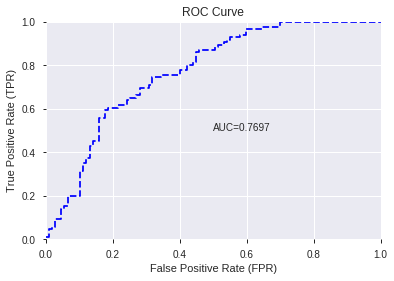

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


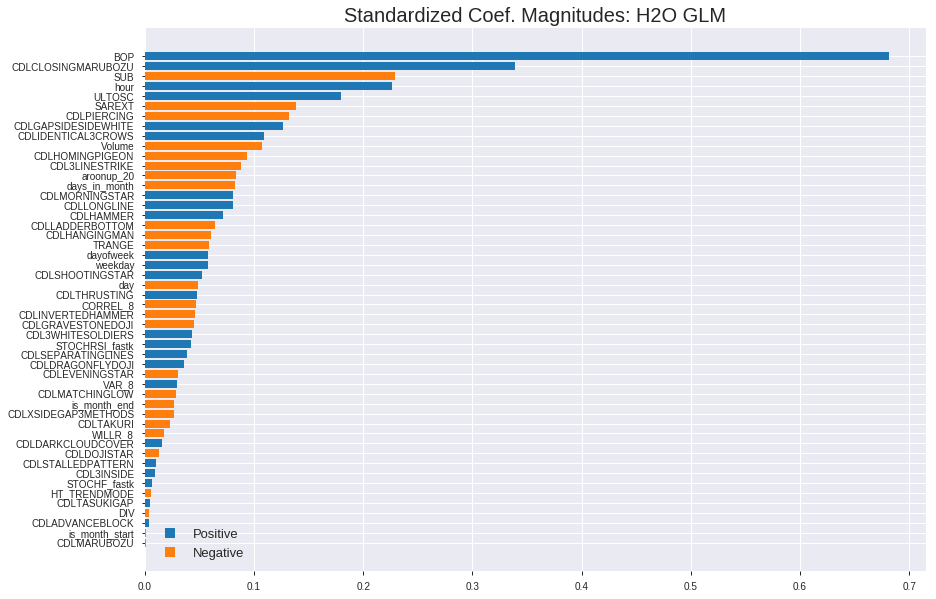

'log_likelihood'
--2019-08-25 12:57:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_125725_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_125725_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a23f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'hour',
 'ULTOSC',
 'SAREXT',
 'CDLPIERCING',
 'CDLGAPSIDESIDEWHITE',
 'CDLIDENTICAL3CROWS',
 'Volume',
 'CDLHOMINGPIGEON',
 'CDL3LINESTRIKE',
 'aroonup_20',
 'days_in_month',
 'CDLMORNINGSTAR',
 'CDLLONGLINE',
 'CDLHAMMER',
 'CDLLADDERBOTTOM',
 'CDLHANGINGMAN',
 'TRANGE',
 'dayofweek',
 'weekday',
 'CDLSHOOTINGSTAR',
 'day',
 'CDLTHRUSTING',
 'CORREL_8',
 'CDLINVERTEDHAMMER',
 'CDLGRAVESTONEDOJI',
 'CDL3WHITESOLDIERS',
 'STOCHRSI_fastk',
 'CDLSEPARATINGLINES',
 'CDLDRAGONFLYDOJI',
 'CDLEVENINGSTAR',
 'VAR_8',
 'CDLMATCHINGLOW',
 'is_month_end',
 'CDLXSIDEGAP3METHODS',
 'CDLTAKURI',
 'WILLR_8',
 'CDLDARKCLOUDCOVER',
 'CDLDOJISTAR',
 'CDLSTALLEDPATTERN',
 'CDL3INSIDE',
 'STOCHF_fastk',
 'HT_TRENDMODE',
 'CDLTASUKIGAP',
 'DIV',
 'CDLADVANCEBLOCK',
 'is_month_start',
 'CDLMARUBOZU']

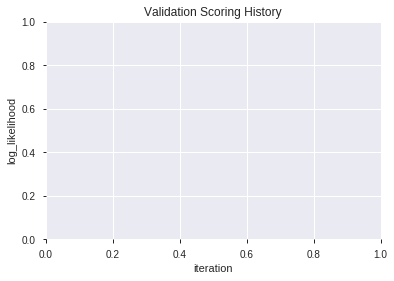

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_125832_model_2  0.762008  0.575219              0.305803  0.443825  0.196980
1  XGBoost_grid_1_AutoML_20190825_125832_model_3  0.757661  0.583281              0.273093  0.446459  0.199326
2  XGBoost_grid_1_AutoML_20190825_125832_model_7  0.754945  0.582926              0.274234  0.446999  0.199808
3               XGBoost_1_AutoML_20190825_125832  0.748642  0.587737              0.293958  0.449198  0.201779
4  XGBoost_grid_1_AutoML_20190825_125832_model_1  0.747772  0.589103              0.288253  0.449698  0.202229
5  XGBoost_grid_1_AutoML_20190825_125832_model_6  0.745381  0.589141              0.306944  0.449933  0.202440
6               XGBoost_3_AutoML_20190825_125832  0.743860  0.592079              0.303412  0.451411  0.203772
7  XGBoost_grid_1_AutoML_20190825_125832_model_5  0.742991  0.598159              0.284612  0.453186  0.205378
8               XGBoost_2_AutoML_20190825_125832  0.742013  0.595099              0.303412  0.452008  0.204311
9  XGBoost_grid_1_AutoML_20190825_125832_model_4  0.740600  0.595372              0.312649  0.452725  0.204960

variable  relative_importance  scaled_importance  percentage
0                   BOP          2417.460449           1.000000    0.362334
1                  hour           445.729858           0.184379    0.066807
2                TRANGE           419.945343           0.173713    0.062942
3                Volume           412.216125           0.170516    0.061784
4                SAREXT           344.090149           0.142335    0.051573
5          STOCHF_fastk           285.254333           0.117998    0.042755
6                 VAR_8           278.681702           0.115279    0.041769
7              CORREL_8           237.127869           0.098090    0.035541
8                   day           234.850021           0.097147    0.035200
9                ULTOSC           228.879715           0.094678    0.034305
10                  DIV           210.831619           0.087212    0.031600
11              WILLR_8           195.666321           0.080939    0.029327
12                  SUB           172.619766           0.071405    0.025873
13       STOCHRSI_fastk           169.962082           0.070306    0.025474
14           aroonup_20           162.888626           0.067380    0.024414
15   CDLCLOSINGMARUBOZU           147.700867           0.061098    0.022138
16            dayofweek            71.122452           0.029420    0.010660
17            CDLHAMMER            69.740982           0.028849    0.010453
18        days_in_month            47.999481           0.019855    0.007194
19        CDLHANGINGMAN            20.142725           0.008332    0.003019
20         HT_TRENDMODE            18.107239           0.007490    0.002714
21          CDLPIERCING            17.526394           0.007250    0.002627
22          CDLLONGLINE            16.654018           0.006889    0.002496
23              weekday             9.976497           0.004127    0.001495
24     CDLDRAGONFLYDOJI             8.102997           0.003352    0.001214
25   CDLSEPARATINGLINES             5.196877           0.002150    0.000779
26      CDLADVANCEBLOCK             4.816015           0.001992    0.000722
27  CDLXSIDEGAP3METHODS             4.672978           0.001933    0.000700
28    CDLDARKCLOUDCOVER             4.061043           0.001680    0.000609
29      CDLSHOOTINGSTAR             3.739440           0.001547    0.000560
30           CDL3INSIDE             3.416008           0.001413    0.000512
31          CDLMARUBOZU             2.253292           0.000932    0.000338
32    CDLGRAVESTONEDOJI             0.471736           0.000195    0.000071

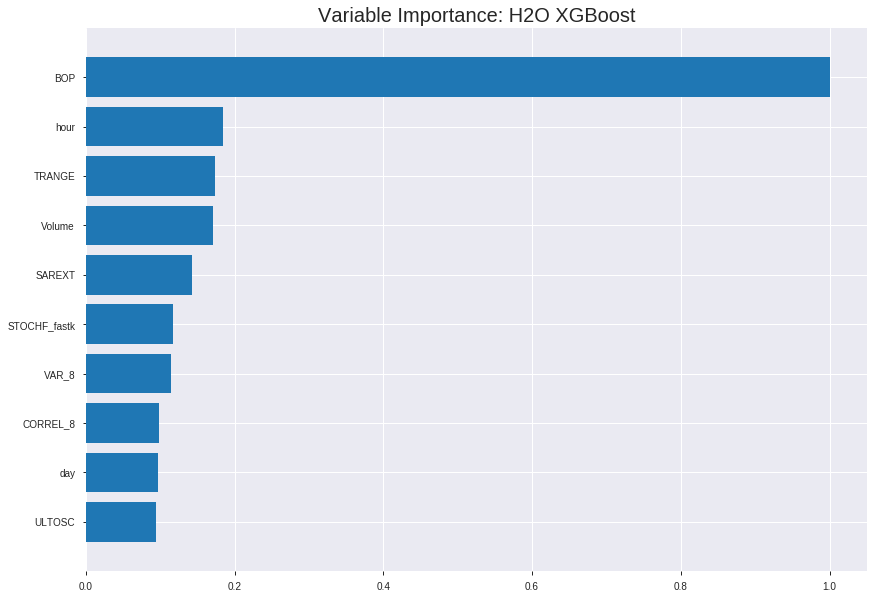

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_125832_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15185375631830839
RMSE: 0.3896841750935088
LogLoss: 0.47470446572942426
Mean Per-Class Error: 0.1841399277518062
AUC: 0.8844217045615526
pr_auc: 0.8646881839048685
Gini: 0.7688434091231051
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.517869234085083: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      614  110  0.1519   (110.0/724.0)
1      135  489  0.2163   (135.0/624.0)
Total  749  599  0.1818   (245.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.517869     0.799673  179
max f2                       0.32216      0.866531  277
max f0point5                 0.549899     0.812137  163
max accuracy                 0.517869     0.818249  179
max precision                0.874874     1         0
max recall                   0.16016      1         355
max specificity              0.874874     1         0
max absolute_mcc             0.517869     0.633916  179
max min_per_class_accuracy   0.492673     0.801105  190
max mean_per_class_accuracy  0.517869     0.81586   179

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 46.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.856039           2.16026   2.16026            1                0.864443  1                           0.864443            0.0224359       0.0224359                  116.026   116.026
    2        0.0200297                   0.84679            2.16026   2.16026            1                0.851998  1                           0.858451            0.0208333       0.0432692                  116.026   116.026
    3        0.0304154                   0.834174           2.00595   2.10757            0.928571         0.841654  0.97561                     0.852716            0.0208333       0.0641026                  100.595   110.757
    4        0.0400593                   0.818518           2.16026   2.12025            1                0.823782  0.981481                    0.84575             0.0208333       0.0849359                  116.026   112.025
    5        0.0504451                   0.809087           2.00595   2.09672            0.928571         0.813514  0.970588                    0.839113            0.0208333       0.105769                   100.595   109.672
    6        0.100148                    0.769077           2.06353   2.08025            0.955224         0.787795  0.962963                    0.813644            0.102564        0.208333                   106.353   108.025
    7        0.150593                    0.73014            2.00141   2.05384            0.926471         0.747845  0.950739                    0.791603            0.100962        0.309295                   100.141   105.384
    8        0.200297                    0.686715           1.7411    1.97623            0.80597          0.707923  0.914815                    0.770838            0.0865385       0.395833                   74.1102   97.6235
    9        0.300445                    0.611316           1.60019   1.85089            0.740741         0.647317  0.85679                     0.729664            0.160256        0.55609                    60.019    85.0886
    10       0.399852                    0.544298           1.6605    1.80355            0.768657         0.579687  0.834879                    0.692379            0.165064        0.721154                   66.0496   80.3554
    11       0.5                         0.47585            1.04012   1.65064            0.481481         0.511844  0.764095                    0.656218            0.104167        0.825321                   4.01235   65.0641
    12       0.600148                    0.39925            0.736087  1.49803            0.340741         0.438051  0.693449                    0.619812            0.0737179       0.899038                   -26.3913  49.8027
    13       0.699555                    0.318934           0.564246  1.36534            0.261194         0.359526  0.632025                    0.582826            0.0560897       0.955128                   -43.5754  36.5337
    14       0.799703                    0.243855           0.272032  1.22842            0.125926         0.281453  0.568646                    0.545084            0.0272436       0.982372                   -72.7968  22.842
    15       0.899852                    0.14431            0.176021  1.11129            0.0814815        0.196757  0.514427                    0.506317            0.0176282       1                          -82.3979  11.1294
    16       1                           0.0875465          0         1                  0                0.116609  0.462908                    0.467289          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19804721432020672
RMSE: 0.4450249592103871
LogLoss: 0.5804107629555514
Mean Per-Class Error: 0.28095289541918755
AUC: 0.7574816335350043
pr_auc: 0.7105527363268404
Gini: 0.5149632670700086
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3757978677749634: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      118  90   0.4327   (90.0/208.0)
1      23   155  0.1292   (23.0/178.0)
Total  141  245  0.2927   (113.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375798     0.732861  244
max f2                       0.135045     0.823917  349
max f0point5                 0.44205      0.675422  221
max accuracy                 0.44205      0.709845  221
max precision                0.867815     1         0
max recall                   0.0934282    1         385
max specificity              0.867815     1         0
max absolute_mcc             0.375798     0.453541  244
max min_per_class_accuracy   0.509083     0.677885  187
max mean_per_class_accuracy  0.375798     0.719047  244

Gains/Lift Table: Avg response rate: 46.11 %, avg score: 46.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.858182           2.16854   2.16854            1                0.863636  1                           0.863636            0.0224719       0.0224719                  116.854   116.854
    2        0.0207254                   0.849638           2.16854   2.16854            1                0.853476  1                           0.858556            0.0224719       0.0449438                  116.854   116.854
    3        0.0310881                   0.817224           2.16854   2.16854            1                0.836198  1                           0.851103            0.0224719       0.0674157                  116.854   116.854
    4        0.0414508                   0.80013            1.6264    2.03301            0.75             0.803371  0.9375                      0.83917             0.0168539       0.0842697                  62.6404   103.301
    5        0.0518135                   0.787607           1.6264    1.95169            0.75             0.792194  0.9                         0.829775            0.0168539       0.101124                   62.6404   95.1685
    6        0.101036                    0.768012           1.48374   1.72371            0.684211         0.775803  0.794872                    0.803481            0.0730337       0.174157                   48.3737   72.3711
    7        0.150259                    0.738816           1.59787   1.68249            0.736842         0.757435  0.775862                    0.788397            0.0786517       0.252809                   59.7871   68.2487
    8        0.202073                    0.705069           1.40955   1.6125             0.65             0.723244  0.74359                     0.771691            0.0730337       0.325843                   40.9551   61.2504
    9        0.300518                    0.620503           1.31254   1.51424            0.605263         0.658789  0.698276                    0.734706            0.129213        0.455056                   31.2537   51.4239
    10       0.401554                    0.562783           1.39009   1.483              0.641026         0.589013  0.683871                    0.698048            0.140449        0.595506                   39.0089   48.3001
    11       0.5                         0.497639           1.08427   1.40449            0.5              0.534818  0.647668                    0.665909            0.106742        0.702247                   8.42697   40.4494
    12       0.601036                    0.407453           1.11207   1.35534            0.512821         0.457834  0.625                       0.630931            0.11236         0.814607                   11.2071   35.5337
    13       0.699482                    0.302466           0.798936  1.27703            0.368421         0.351087  0.588889                    0.591546            0.0786517       0.893258                   -20.1064  27.7029
    14       0.800518                    0.215068           0.333621  1.15796            0.153846         0.26001   0.533981                    0.549701            0.0337079       0.926966                   -66.6379  15.7958
    15       0.898964                    0.137302           0.513601  1.08739            0.236842         0.170872  0.501441                    0.508216            0.0505618       0.977528                   -48.6399  8.73944
    16       1                           0.0934282          0.222414  1                  0.102564         0.112544  0.46114                     0.468238         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:58:45  0.911 sec   0                  0.5              0.693147            0.5             0                  1                0.537092                         0.5                0.693147              0.5               0                    1                  0.53886
    2019-08-25 12:58:45  0.988 sec   5                  0.476125         0.646309            0.824237        0.52616            1.81343          0.235905                         0.481696           0.657024              0.740952          0.466068             1.47581            0.305699
    2019-08-25 12:58:45  1.053 sec   10                 0.458715         0.612794            0.833966        0.590597           1.87047          0.230712                         0.469831           0.633685              0.741073          0.525138             1.47461            0.297927
    2019-08-25 12:58:45  1.108 sec   15                 0.44563          0.58757             0.841429        0.779              2.06633          0.234421                         0.461309           0.616704              0.752714          0.691417             2.16854            0.290155
    2019-08-25 12:58:45  1.166 sec   20                 0.434686         0.56622             0.847206        0.804764           2.04656          0.228487                         0.456044           0.605717              0.753592          0.690248             1.6264             0.295337
    2019-08-25 12:58:45  1.223 sec   25                 0.425944         0.548909            0.85182         0.810509           2.04024          0.223294                         0.452056           0.597157              0.755064          0.696142             2.16854            0.287565
    2019-08-25 12:58:45  1.282 sec   30                 0.419065         0.534983            0.855145        0.822935           2.00595          0.226261                         0.450213           0.592856              0.753889          0.702318             2.16854            0.297927
    2019-08-25 12:58:45  1.342 sec   35                 0.413796         0.524169            0.859247        0.829822           2.00595          0.223294                         0.448638           0.589173              0.754281          0.70619              2.16854            0.297927
    2019-08-25 12:58:46  1.404 sec   40                 0.408371         0.513076            0.863656        0.836082           2.16026          0.220326                         0.44705            0.585545              0.755483          0.707549             2.16854            0.295337
    2019-08-25 12:58:46  1.465 sec   45                 0.404077         0.504037            0.867848        0.844459           2.16026          0.210682                         0.445862           0.582644              0.756523          0.708703             2.16854            0.284974
    2019-08-25 12:58:46  1.537 sec   50                 0.39938          0.494732            0.873862        0.851239           2.16026          0.20178                          0.44523            0.581123              0.756955          0.709452             2.16854            0.295337
    2019-08-25 12:58:46  1.609 sec   55                 0.396084         0.487706            0.876282        0.850666           2.16026          0.204748                         0.444863           0.580055              0.758697          0.

Variable Importances: 


variable           relative_importance    scaled_importance       percentage
-----------------  ---------------------  ----------------------  ---------------------
BOP                2417.46044921875       1.0                     0.3623343621145902
hour               445.7298583984375      0.1843793798332808      0.06680698497897553
TRANGE             419.9453430175781      0.17371342854990315     0.0629423443243676
Volume             412.21612548828125     0.1705161818144727      0.06178387196796246
SAREXT             344.09014892578125     0.1423353788629637      0.05157299870665048
---                ---                    ---                     ---
CDLDARKCLOUDCOVER  4.061042785644531      0.0016798797212822809   0.0006086781472400509
CDLSHOOTINGSTAR    3.7394399642944336     0.0015468463881189482   0.0005604755993283369
CDL3INSIDE         3.4160079956054688     0.0014130564149289057   0.0005119988947351947
CDLMARUBOZU        2.253291606903076      0.000932090370963989    0.0003377283699963887
CDLGRAVESTONEDOJI  0.4717358648777008     0.00019513695251152982  7.070482321325025e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7046632124352331)

('F1', 0.7069767441860465)

('auc', 0.7620082590741144)

('logloss', 0.5752188279207601)

('mean_per_class_error', 0.2880352097370137)

('rmse', 0.4438247592220829)

('mse', 0.19698041689853987)

xgboost prediction progress: |████████████████████████████████████████████| 100%


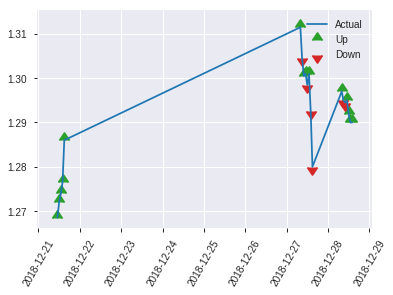


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19698041689853987
RMSE: 0.4438247592220829
LogLoss: 0.5752188279207601
Mean Per-Class Error: 0.2880352097370137
AUC: 0.7620082590741144
pr_auc: 0.6672176049911618
Gini: 0.5240165181482288
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31172916293144226: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      54   53   0.4953   (53.0/107.0)
1      10   76   0.1163   (10.0/86.0)
Total  64   129  0.3264   (63.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.311729     0.706977  128
max f2                       0.222393     0.836653  157
max f0point5                 0.588604     0.666667  60
max accuracy                 0.449826     0.704663  104
max precision                0.857076     1         0
max recall                   0.153507     1         171
max specificity              0.857076     1         0
max absolute_mcc             0.449826     0.423057  104
max min_per_class_accuracy   0.495042     0.674419  87
max mean_per_class_accuracy  0.449826     0.711965  104

Gains/Lift Table: Avg response rate: 44.56 %, avg score: 45.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.83121            2.24419   2.24419            1                0.846791  1                           0.846791            0.0232558       0.0232558                  124.419   124.419
    2        0.0207254                   0.828176           1.12209   1.68314            0.5              0.829674  0.75                        0.838233            0.0116279       0.0348837                  12.2093   68.314
    3        0.0310881                   0.804299           2.24419   1.87016            1                0.824835  0.833333                    0.833767            0.0232558       0.0581395                  124.419   87.0155
    4        0.0414508                   0.788816           1.12209   1.68314            0.5              0.79654   0.75                        0.82446             0.0116279       0.0697674                  12.2093   68.314
    5        0.0518135                   0.781474           1.12209   1.57093            0.5              0.784136  0.7                         0.816395            0.0116279       0.0813953                  12.2093   57.093
    6        0.103627                    0.744881           1.79535   1.68314            0.8              0.761425  0.75                        0.78891             0.0930233       0.174419                   79.5349   68.314
    7        0.150259                    0.718335           1.74548   1.70249            0.777778         0.730502  0.758621                    0.770784            0.0813953       0.255814                   74.5478   70.2486
    8        0.202073                    0.679335           1.34651   1.61121            0.6              0.697215  0.717949                    0.75192             0.0697674       0.325581                   34.6512   61.121
    9        0.300518                    0.600538           1.65361   1.6251             0.736842         0.63378   0.724138                    0.713219            0.162791        0.488372                   65.3611   62.51
    10       0.398964                    0.52679            1.06304   1.48641            0.473684         0.565844  0.662338                    0.676854            0.104651        0.593023                   6.30355   48.6409
    11       0.502591                    0.464817           1.00988   1.38816            0.45             0.496853  0.618557                    0.63974             0.104651        0.697674                   0.988372  38.8156
    12       0.601036                    0.37374            1.06304   1.3349             0.473684         0.434802  0.594828                    0.606173            0.104651        0.802326                   6.30355   33.4904
    13       0.699482                    0.287389           0.826805  1.26339            0.368421         0.327885  0.562963                    0.567006            0.0813953       0.883721                   -17.3195  26.3394
    14       0.797927                    0.230082           0.826805  1.20953            0.368421         0.261346  0.538961                    0.529295            0.0813953       0.965116                   -17.3195  20.9529
    15       0.896373                    0.152316           0.354345  1.11561            0.157895         0.188057  0.49711                     0.491818            0.0348837       1                          -64.5655  11.5607
    16       1                           0.0912548          0         1                  0                0.12328   0.445596                    0.453627            0   

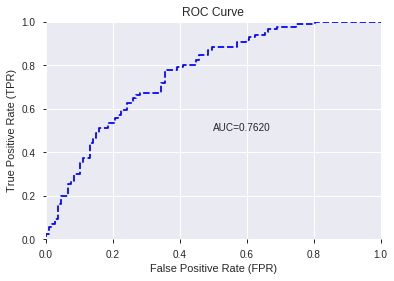

This function is available for GLM models only


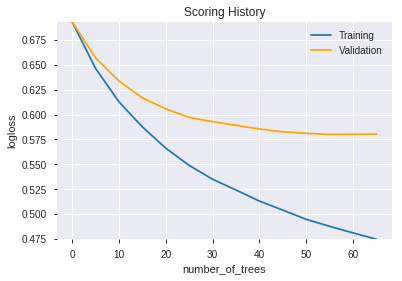

--2019-08-25 12:59:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.j

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_125832_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_125832_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a23f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'hour',
 'TRANGE',
 'Volume',
 'SAREXT',
 'STOCHF_fastk',
 'VAR_8',
 'CORREL_8',
 'day',
 'ULTOSC',
 'DIV',
 'WILLR_8',
 'SUB',
 'STOCHRSI_fastk',
 'aroonup_20',
 'CDLCLOSINGMARUBOZU',
 'dayofweek',
 'CDLHAMMER',
 'days_in_month',
 'CDLHANGINGMAN',
 'HT_TRENDMODE',
 'CDLPIERCING',
 'CDLLONGLINE',
 'weekday',
 'CDLDRAGONFLYDOJI',
 'CDLSEPARATINGLINES',
 'CDLADVANCEBLOCK',
 'CDLXSIDEGAP3METHODS',
 'CDLDARKCLOUDCOVER',
 'CDLSHOOTINGSTAR',
 'CDL3INSIDE',
 'CDLMARUBOZU',
 'CDLGRAVESTONEDOJI']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_125958_model_1  0.749837  0.584962              0.303521  0.449106  0.201696

variable  relative_importance  scaled_importance    percentage
0                         BOP             0.255452           1.000000  3.854183e-02
1          CDLCLOSINGMARUBOZU             0.169422           0.663225  2.556189e-02
2                 CDLLONGLINE             0.120178           0.470453  1.813213e-02
3                        hour             0.107905           0.422408  1.628037e-02
4              STOCHRSI_fastk             0.086655           0.339221  1.307421e-02
...                       ...                  ...                ...           ...
1027   LINEARREG_INTERCEPT_24             0.000006           0.000023  8.708270e-07
1028   BBANDS_upperband_8_5_2             0.000004           0.000016  5.994091e-07
1029   BBANDS_lowerband_8_0_3             0.000003           0.000012  4.772744e-07
1030  BBANDS_lowerband_14_6_4             0.000003           0.000012  4.743620e-07
1031                MAVP_14_1             0.000001           0.000005  1.841982e-07

[1032 rows x 4 columns]

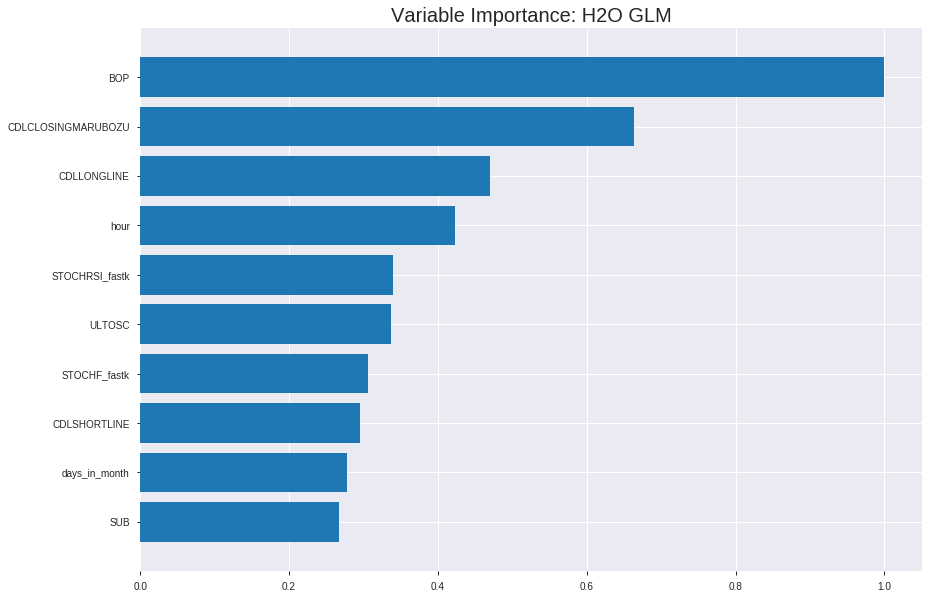

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_125958_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18650466118273992
RMSE: 0.4318618542806715
LogLoss: 0.5536323340215914
Null degrees of freedom: 1347
Residual degrees of freedom: 315
Null deviance: 1861.2995819096327
Residual deviance: 1492.5927725222105
AIC: 3558.5927725222105
AUC: 0.7991227953676158
pr_auc: 0.7616378822158876
Gini: 0.5982455907352315
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3966283839827117: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      426  298  0.4116   (298.0/724.0)
1      91   533  0.1458   (91.0/624.0)
Total  517  831  0.2886   (389.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396628     0.732646  232
max f2                       0.281353     0.839641  299
max f0point5                 0.511201     0.713788  168
max accuracy                 0.511201     0.728487  168
max precision                0.923708     1         0
max recall                   0.109772     1         381
max specificity              0.923708     1         0
max absolute_mcc             0.45463      0.456051  198
max min_per_class_accuracy   0.472177     0.721154  189
max mean_per_class_accuracy  0.45463      0.728565  198

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 46.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.873885           2.00595   2.00595            0.928571         0.892789  0.928571                    0.892789            0.0208333       0.0208333                  100.595   100.595
    2        0.0200297                   0.853277           1.99408   2.00024            0.923077         0.862003  0.925926                    0.877966            0.0192308       0.0400641                  99.4083   100.024
    3        0.0304154                   0.826117           2.16026   2.05488            1                0.83812   0.95122                     0.86436             0.0224359       0.0625                     116.026   105.488
    4        0.0400593                   0.805731           1.99408   2.04024            0.923077         0.814968  0.944444                    0.852469            0.0192308       0.0817308                  99.4083   104.024
    5        0.0504451                   0.785785           2.00595   2.03318            0.928571         0.796059  0.941176                    0.840855            0.0208333       0.102564                   100.595   103.318
    6        0.100148                    0.724661           1.80559   1.92023            0.835821         0.750522  0.888889                    0.796023            0.0897436       0.192308                   80.5587   92.0228
    7        0.150593                    0.678751           1.52489   1.7878             0.705882         0.701237  0.827586                    0.764272            0.0769231       0.269231                   52.4887   78.7798
    8        0.200297                    0.643809           1.61213   1.74421            0.746269         0.660869  0.807407                    0.738613            0.0801282       0.349359                   61.2132   74.4207
    9        0.300445                    0.574265           1.42417   1.63753            0.659259         0.610096  0.758025                    0.695774            0.142628        0.491987                   42.4169   63.7528
    10       0.399852                    0.521322           1.38643   1.5751             0.641791         0.54764   0.729128                    0.658947            0.137821        0.629808                   38.6433   57.5103
    11       0.5                         0.46305            1.08813   1.47756            0.503704         0.490689  0.683976                    0.625245            0.108974        0.738782                   8.81292   47.7564
    12       0.600148                    0.407758           0.976116  1.39389            0.451852         0.435406  0.645241                    0.593566            0.0977564       0.836538                   -2.38841  39.3886
    13       0.699555                    0.348177           0.677095  1.29203            0.313433         0.376958  0.598091                    0.562786            0.0673077       0.903846                   -32.2905  29.203
    14       0.799703                    0.277031           0.560066  1.20037            0.259259         0.313984  0.555659                    0.531628            0.0560897       0.959936                   -43.9934  20.0365
    15       0.899852                    0.200305           0.240028  1.09349            0.111111         0.238929  0.506183                    0.499052            0.0240385       0.983974                   -75.9972  9.34851
    16       1                           0.00875143         0.160019  1                  0.0740741        0.138144  0.462908                    0.462908          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20446883677106248
RMSE: 0.45218230479648636
LogLoss: 0.5949697304132623
Null degrees of freedom: 385
Residual degrees of freedom: -647
Null deviance: 532.7805186446055
Residual deviance: 459.31663187903854
AIC: 2525.3166318790386
AUC: 0.7411949006050129
pr_auc: 0.6936820169850014
Gini: 0.48238980121002584
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37875226909648063: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      107  101  0.4856   (101.0/208.0)
1      27   151  0.1517   (27.0/178.0)
Total  134  252  0.3316   (128.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.378752     0.702326  251
max f2                       0.21065      0.82529   323
max f0point5                 0.461032     0.661323  204
max accuracy                 0.461032     0.69171   204
max precision                0.92205      1         0
max recall                   0.0613966    1         377
max specificity              0.92205      1         0
max absolute_mcc             0.461032     0.390185  204
max min_per_class_accuracy   0.485978     0.682692  187
max mean_per_class_accuracy  0.461032     0.695306  204

Gains/Lift Table: Avg response rate: 46.11 %, avg score: 46.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.881862           2.16854   2.16854            1                0.916509  1                           0.916509            0.0224719       0.0224719                  116.854   116.854
    2        0.0207254                   0.846827           2.16854   2.16854            1                0.857715  1                           0.887112            0.0224719       0.0449438                  116.854   116.854
    3        0.0310881                   0.80606            1.6264    1.98783            0.75             0.829375  0.916667                    0.867866            0.0168539       0.0617978                  62.6404   98.7828
    4        0.0414508                   0.787015           2.16854   2.03301            1                0.791777  0.9375                      0.848844            0.0224719       0.0842697                  116.854   103.301
    5        0.0518135                   0.771986           1.6264    1.95169            0.75             0.780364  0.9                         0.835148            0.0168539       0.101124                   62.6404   95.1685
    6        0.101036                    0.716312           1.3696    1.66811            0.631579         0.73724   0.769231                    0.787449            0.0674157       0.168539                   36.9604   66.8107
    7        0.150259                    0.684338           1.59787   1.6451             0.736842         0.701022  0.758621                    0.759137            0.0786517       0.247191                   59.7871   64.5099
    8        0.202073                    0.658309           1.51798   1.6125             0.7              0.668819  0.74359                     0.735978            0.0786517       0.325843                   51.7978   61.2504
    9        0.300518                    0.593703           1.31254   1.51424            0.605263         0.624586  0.698276                    0.699488            0.129213        0.455056                   31.2537   51.4239
    10       0.401554                    0.530554           1.16768   1.42704            0.538462         0.562016  0.658065                    0.664898            0.117978        0.573034                   16.7675   42.7039
    11       0.5                         0.476568           1.25547   1.39326            0.578947         0.504943  0.642487                    0.633404            0.123596        0.696629                   25.547    39.3258
    12       0.601036                    0.425671           0.945261  1.31795            0.435897         0.450479  0.607759                    0.602654            0.0955056       0.792135                   -5.47393  31.7948
    13       0.699482                    0.351294           0.798936  1.2449             0.368421         0.384943  0.574074                    0.572013            0.0786517       0.870787                   -20.1064  24.4902
    14       0.800518                    0.254686           0.722846  1.17901            0.333333         0.308392  0.543689                    0.538741            0.0730337       0.94382                    -27.7154  17.9012
    15       0.898964                    0.158627           0.228267  1.0749             0.105263         0.203125  0.495677                    0.501987            0.0224719       0.966292                   -77.1733  7.48956
    16       1                           0.0272926          0.333621  1                  0.153846         0.104628  0.46114                     0.46184          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-25 13:00:00  0.000 sec   2            .21E2     1024          1.3536762603881176  1.3605547642294915
     2019-08-25 13:00:02  1.629 sec   4            .15E2     1027          1.3461372947002137  1.3536438855065178
     2019-08-25 13:00:03  3.201 sec   6            .11E2     1029          1.3367861906126945  1.3451706746977583
     2019-08-25 13:00:05  4.768 sec   8            .8E1      1033          1.325435445455522   1.3347569179745848
     2019-08-25 13:00:07  6.316 sec   10           .58E1     1033          1.3118980051172924  1.3223842068853016
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-25 13:00:25  24.919 sec  34           .13E0     1033          1.0936685796392513  1.1916361449661044
     2019-08-25 13:00:27  26.462 sec  36           .93E-1    1033          1.0812282993391265  1.1984047991831357
     2019-08-25 13:00:28  27.984 sec  38           .68E-1    1033          1.0698123098450572  1.212198445193281
     2019-08-25 13:00:30  29.499 sec  40           .49E-1    1033          1.059310662052369   1.2362264333008617
     2019-08-25 13:00:31  31.106 sec  42           .36E-1    1033          1.0496206401842108  1.2742535022117474


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6994818652849741)

('F1', 0.7123287671232876)

('auc', 0.74983699195827)

('logloss', 0.5849621058219125)

('mean_per_class_error', 0.3035209737013693)

('rmse', 0.44910606216418014)

('mse', 0.20169625507261643)

glm prediction progress: |████████████████████████████████████████████████| 100%


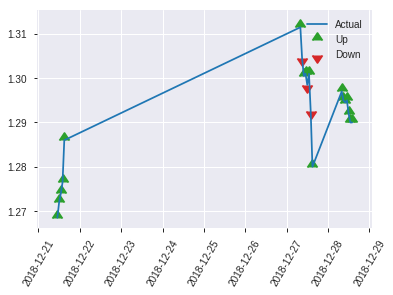


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20169625507261643
RMSE: 0.44910606216418014
LogLoss: 0.5849621058219125
Null degrees of freedom: 192
Residual degrees of freedom: -840
Null deviance: 265.4984131782047
Residual deviance: 225.79537284725825
AIC: 2291.7953728472585
AUC: 0.74983699195827
pr_auc: 0.6492683551228858
Gini: 0.49967398391654005
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3162198039984532: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      52   55   0.514    (55.0/107.0)
1      8    78   0.093    (8.0/86.0)
Total  60   133  0.3264   (63.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.31622      0.712329  132
max f2                       0.225667     0.833333  153
max f0point5                 0.541722     0.677419  55
max accuracy                 0.541722     0.699482  55
max precision                0.850956     1         0
max recall                   0.167604     1         173
max specificity              0.850956     1         0
max absolute_mcc             0.31622      0.421974  132
max min_per_class_accuracy   0.424359     0.654206  93
max mean_per_class_accuracy  0.31622      0.696479  132

Gains/Lift Table: Avg response rate: 44.56 %, avg score: 42.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.81829            2.24419   2.24419            1                0.841698  1                           0.841698            0.0232558       0.0232558                  124.419   124.419
    2        0.0207254                   0.795494           1.12209   1.68314            0.5              0.810995  0.75                        0.826347            0.0116279       0.0348837                  12.2093   68.314
    3        0.0310881                   0.759441           2.24419   1.87016            1                0.785841  0.833333                    0.812845            0.0232558       0.0581395                  124.419   87.0155
    4        0.0414508                   0.753124           1.12209   1.68314            0.5              0.753419  0.75                        0.797988            0.0116279       0.0697674                  12.2093   68.314
    5        0.0518135                   0.748255           1.12209   1.57093            0.5              0.751069  0.7                         0.788605            0.0116279       0.0813953                  12.2093   57.093
    6        0.103627                    0.688053           1.34651   1.45872            0.6              0.71979   0.65                        0.754197            0.0697674       0.151163                   34.6512   45.8721
    7        0.150259                    0.649298           1.49612   1.47033            0.666667         0.668241  0.655172                    0.727521            0.0697674       0.22093                    49.6124   47.0329
    8        0.202073                    0.627324           2.01977   1.61121            0.9              0.639381  0.717949                    0.704921            0.104651        0.325581                   101.977   61.121
    9        0.300518                    0.535418           1.77173   1.66379            0.789474         0.566402  0.741379                    0.659544            0.174419        0.5                        77.1726   66.3793
    10       0.398964                    0.47587            0.94492   1.48641            0.421053         0.50826   0.662338                    0.622214            0.0930233       0.593023                   -5.50796  48.6409
    11       0.502591                    0.415206           0.785465  1.34188            0.35             0.439946  0.597938                    0.584633            0.0813953       0.674419                   -21.4535  34.1884
    12       0.601036                    0.370218           1.41738   1.35425            0.631579         0.399002  0.603448                    0.554228            0.139535        0.813953                   41.7381   35.425
    13       0.699482                    0.304483           0.94492   1.29664            0.421053         0.337654  0.577778                    0.523747            0.0930233       0.906977                   -5.50796  29.6641
    14       0.797927                    0.225439           0.590575  1.20953            0.263158         0.26335   0.538961                    0.49162             0.0581395       0.965116                   -40.9425  20.9529
    15       0.896373                    0.167757           0.23623   1.10263            0.105263         0.195677  0.491329                    0.459118            0.0232558       0.988372                   -76.377   10.2635
    16       1                           0.0665196          0.112209  1                  0.05             0.117316  0.445596                    0.423698            0.

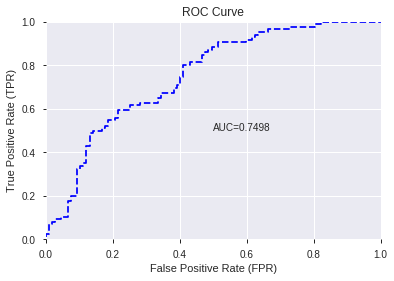

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


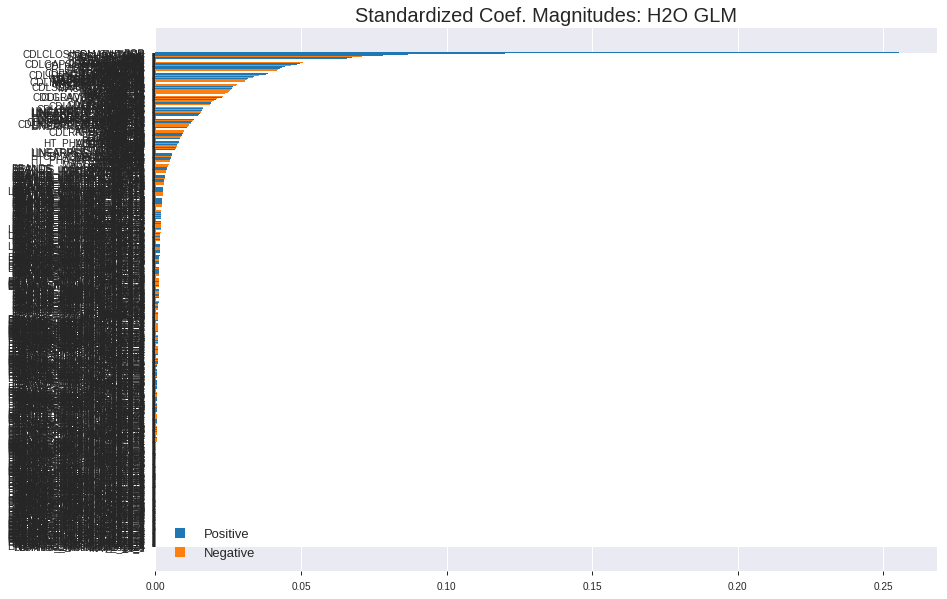

'log_likelihood'
--2019-08-25 13:00:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.227.152
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.227.152|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_125958_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_125958_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a23f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

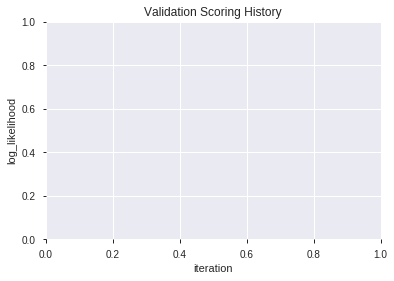

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190825_130152  0.770919  0.573745              0.270593  0.441698  0.195097
1  XGBoost_grid_1_AutoML_20190825_130152_model_1  0.770702  0.584666              0.264671  0.447723  0.200456
2  XGBoost_grid_1_AutoML_20190825_130152_model_7  0.766572  0.575865              0.266953  0.442946  0.196201
3  XGBoost_grid_1_AutoML_20190825_130152_model_2  0.752554  0.588342              0.285753  0.448479  0.201133
4  XGBoost_grid_1_AutoML_20190825_130152_model_4  0.752445  0.586822              0.263421  0.448249  0.200927
5  XGBoost_grid_1_AutoML_20190825_130152_model_3  0.751467  0.616241              0.316181  0.461117  0.212629
6  XGBoost_grid_1_AutoML_20190825_130152_model_6  0.747012  0.596308              0.296240  0.451990  0.204295
7               XGBoost_2_AutoML_20190825_130152  0.746468  0.592545              0.289176  0.451278  0.203652
8               XGBoost_1_AutoML_20190825_130152  0.739513  0.603886              0.301022  0.455567  0.207541
9  XGBoost_grid_1_AutoML_20190825_130152_model_5  0.730385  0.626825              0.316073  0.468068  0.219088

variable  relative_importance  scaled_importance  percentage
0                        BOP          1915.234131           1.000000    0.242863
1                       hour           328.097412           0.171309    0.041605
2               STOCHF_fastk           292.895386           0.152929    0.037141
3                     TRANGE           252.103073           0.131630    0.031968
4         CDLCLOSINGMARUBOZU           173.975693           0.090838    0.022061
..                       ...                  ...                ...         ...
280  BBANDS_upperband_12_0_5             0.536138           0.000280    0.000068
281             HT_TRENDMODE             0.414091           0.000216    0.000053
282               aroonup_14             0.396266           0.000207    0.000050
283               aroonup_30             0.186356           0.000097    0.000024
284        MACDFIX_signal_20             0.009614           0.000005    0.000001

[285 rows x 4 columns]

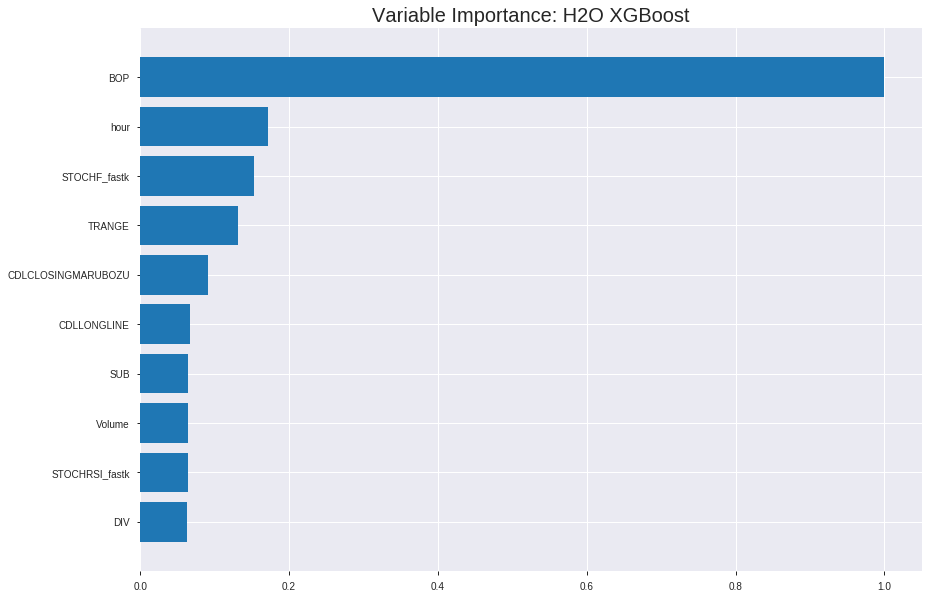

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190825_130152


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11533341588958085
RMSE: 0.33960773826516505
LogLoss: 0.39148576453307454
Mean Per-Class Error: 0.10976678708032295
AUC: 0.959676919535345
pr_auc: 0.9549030693588638
Gini: 0.9193538390706899
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5099593847990036: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      666  58   0.0801   (58.0/724.0)
1      87   537  0.1394   (87.0/624.0)
Total  753  595  0.1076   (145.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.509959     0.88105   187
max f2                       0.365363     0.916616  252
max f0point5                 0.55638      0.909926  168
max accuracy                 0.514567     0.892433  185
max precision                0.940322     1         0
max recall                   0.260069     1         304
max specificity              0.940322     1         0
max absolute_mcc             0.514567     0.783992  185
max min_per_class_accuracy   0.476132     0.885359  199
max mean_per_class_accuracy  0.509959     0.890233  187

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 46.49 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.900732           2.16026    2.16026            1                0.914084  1                           0.914084            0.0224359       0.0224359                  116.026   116.026
    2        0.0200297                   0.891554           2.16026    2.16026            1                0.896421  1                           0.905579            0.0208333       0.0432692                  116.026   116.026
    3        0.0304154                   0.871583           2.16026    2.16026            1                0.881354  1                           0.897307            0.0224359       0.0657051                  116.026   116.026
    4        0.0400593                   0.85545            2.16026    2.16026            1                0.863953  1                           0.889278            0.0208333       0.0865385                  116.026   116.026
    5        0.0504451                   0.844424           2.16026    2.16026            1                0.849536  1                           0.881096            0.0224359       0.108974                   116.026   116.026
    6        0.100148                    0.802798           2.16026    2.16026            1                0.822009  1                           0.851771            0.107372        0.216346                   116.026   116.026
    7        0.150593                    0.755476           2.16026    2.16026            1                0.782707  1                           0.828636            0.108974        0.325321                   116.026   116.026
    8        0.200297                    0.704963           2.09577    2.14425            0.970149         0.731598  0.992593                    0.804557            0.104167        0.429487                   109.577   114.425
    9        0.300445                    0.627376           2.03224    2.10692            0.940741         0.669245  0.975309                    0.759453            0.203526        0.633013                   103.224   110.692
    10       0.399852                    0.542315           1.72498    2.01196            0.798507         0.591331  0.931354                    0.717656            0.171474        0.804487                   72.4981   101.196
    11       0.5                         0.449952           1.04012    1.81731            0.481481         0.496894  0.841246                    0.673438            0.104167        0.908654                   4.01235   81.7308
    12       0.600148                    0.373985           0.59207    1.61285            0.274074         0.412174  0.746601                    0.62984             0.0592949       0.967949                   -40.793   61.2849
    13       0.699555                    0.291113           0.24182    1.41803            0.11194          0.329453  0.656416                    0.587155            0.0240385       0.991987                   -75.818   41.8026
    14       0.799703                    0.222132           0.0800095  1.25046            0.037037         0.25499   0.57885                     0.545558            0.00801282      1                          -91.9991  25.0464
    15       0.899852                    0.142434           0          1.11129            0                0.182966  0.514427                    0.505203            0               1                          -100      11.1294
    16       1                           0.0485199          0          1                  0                0.102522  0.462908                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1982747319359056
RMSE: 0.4452805092701741
LogLoss: 0.5822629232699156
Mean Per-Class Error: 0.27301210025929123
AUC: 0.7664757994814175
pr_auc: 0.7187691078819205
Gini: 0.5329515989628351
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4552839696407318: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      120  88   0.4231   (88.0/208.0)
1      24   154  0.1348   (24.0/178.0)
Total  144  242  0.2902   (112.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.455284     0.733333  241
max f2                       0.366433     0.834176  276
max f0point5                 0.52555      0.691383  204
max accuracy                 0.52555      0.722798  204
max precision                0.881869     1         0
max recall                   0.0715934    1         385
max specificity              0.881869     1         0
max absolute_mcc             0.455284     0.455685  241
max min_per_class_accuracy   0.549064     0.711538  186
max mean_per_class_accuracy  0.523702     0.726988  206

Gains/Lift Table: Avg response rate: 46.11 %, avg score: 51.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.858179           2.16854   2.16854            1                0.868166  1                           0.868166            0.0224719       0.0224719                  116.854    116.854
    2        0.0207254                   0.839817           2.16854   2.16854            1                0.848386  1                           0.858276            0.0224719       0.0449438                  116.854    116.854
    3        0.0310881                   0.82913            1.6264    1.98783            0.75             0.833683  0.916667                    0.850078            0.0168539       0.0617978                  62.6404    98.7828
    4        0.0414508                   0.821956           1.08427   1.76194            0.5              0.825946  0.8125                      0.844045            0.011236        0.0730337                  8.42697    76.1938
    5        0.0518135                   0.814702           2.16854   1.84326            1                0.817301  0.85                        0.838696            0.0224719       0.0955056                  116.854    84.3258
    6        0.101036                    0.772006           1.94027   1.89052            0.894737         0.792984  0.871795                    0.816427            0.0955056       0.191011                   94.0272    89.0521
    7        0.150259                    0.74773            1.48374   1.75726            0.684211         0.762062  0.810345                    0.798617            0.0730337       0.264045                   48.3737    75.7265
    8        0.202073                    0.722632           1.30112   1.64031            0.6              0.733213  0.75641                     0.781847            0.0674157       0.331461                   30.1124    64.0305
    9        0.300518                    0.668926           1.14134   1.47685            0.526316         0.69545   0.681034                    0.753545            0.11236         0.44382                    14.1336    47.685
    10       0.401554                    0.602119           1.27888   1.42704            0.589744         0.635547  0.658065                    0.723855            0.129213        0.573034                   27.8882    42.7039
    11       0.5                         0.542655           1.59787   1.46067            0.736842         0.568851  0.673575                    0.693336            0.157303        0.730337                   59.7871    46.0674
    12       0.601036                    0.47557            1.00086   1.38338            0.461538         0.509865  0.637931                    0.662494            0.101124        0.831461                   0.0864304  38.3379
    13       0.699482                    0.381842           0.798936  1.30112            0.368421         0.4319    0.6                         0.63004             0.0786517       0.910112                   -20.1064   30.1124
    14       0.800518                    0.279275           0.278018  1.17199            0.128205         0.333926  0.540453                    0.592666            0.0280899       0.938202                   -72.1982   17.1994
    15       0.898964                    0.196451           0.342401  1.08114            0.157895         0.234398  0.498559                    0.553432            0.0337079       0.97191                    -65.7599   8.1145
    16       1                           0.0715934          0.278018  1                  0.128205         0.136491  0.46114                     0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 13:02:02  0.005 sec   0                  0.5              0.693147            0.5             0                  1                0.537092                         0.5                0.693147              0.5               0                    1                  0.53886
    2019-08-25 13:02:03  0.552 sec   5                  0.46949          0.633567            0.854325        0.825599           2.16026          0.224777                         0.484066           0.661628              0.731323          0.653905             1.6264             0.334197
    2019-08-25 13:02:03  0.728 sec   10                 0.44462          0.586347            0.877761        0.865598           2.16026          0.222552                         0.470323           0.634556              0.743302          0.675924             1.6264             0.313472
    2019-08-25 13:02:03  0.901 sec   15                 0.428148         0.555085            0.890845        0.881026           2.16026          0.192136                         0.462609           0.619188              0.751499          0.68216              1.6264             0.297927
    2019-08-25 13:02:04  1.077 sec   20                 0.412166         0.524866            0.904728        0.894196           2.16026          0.182493                         0.457441           0.608501              0.752647          0.680955             1.6264             0.30829
    2019-08-25 13:02:04  1.249 sec   25                 0.399336         0.50034             0.914266        0.905626           2.16026          0.166172                         0.452703           0.59854               0.757266          0.695727             2.16854            0.30829
    2019-08-25 13:02:04  1.421 sec   30                 0.386905         0.477186            0.924736        0.917482           2.16026          0.155045                         0.449044           0.590714              0.758886          0.701257             2.16854            0.310881
    2019-08-25 13:02:04  1.570 sec   35                 0.379675         0.463082            0.928548        0.922112           2.16026          0.150593                         0.447741           0.587863              0.762262          0.708727             2.16854            0.300518
    2019-08-25 13:02:04  1.721 sec   40                 0.371543         0.447846            0.935216        0.929368           2.16026          0.141691                         0.446457           0.585215              0.766692          0.71916              2.16854            0.303109
    2019-08-25 13:02:04  1.868 sec   45                 0.364354         0.434393            0.940358        0.934737           2.16026          0.136499                         0.446198           0.58444               0.764828          0.720492             2.16854            0.30829
    2019-08-25 13:02:04  2.007 sec   50                 0.358678         0.424046            0.944417        0.939024           2.16026          0.135015                         0.44662            0.585152              0.762803          0.717757             2.16854            0.303109
    2019-08-25 13:02:05  2.154 sec   55                 0.352567         0.412982            0.948469        0.943504           2.16026          0.127596                         0.445318           0.582261              0.764261          0.715

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      1915.234130859375      1.0                     0.24286335113961896
hour                     328.097412109375       0.1713092967710199      0.0416047498951814
STOCHF_fastk             292.8953857421875      0.1529292847401189      0.03714091857937027
TRANGE                   252.1030731201172      0.13163042004008005     0.0319682049228495
CDLCLOSINGMARUBOZU       173.97569274902344     0.09083781974528601     0.02206117731355681
---                      ---                    ---                     ---
BBANDS_upperband_12_0_5  0.5361380577087402     0.0002799334290623635   6.79855706780904e-05
HT_TRENDMODE             0.4140911102294922     0.0002162091326367954   5.25092744991625e-05
aroonup_14               0.39626598358154297    0.00020690211039823964  5.0248939889175885e-05
aroonup_30               0.1863555908203125     9.730172818959415e-05   2.3631023779801165e-05
MACDFIX_signal_20        0.009613990783691406   5.0197470005286305e-06  1.2191125784214338e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7357512953367875)

('F1', 0.7216494845360826)

('auc', 0.7709193653553575)

('logloss', 0.5737453032028982)

('mean_per_class_error', 0.2679852206042165)

('rmse', 0.44169794904975807)

('mse', 0.19509707819476266)

xgboost prediction progress: |████████████████████████████████████████████| 100%


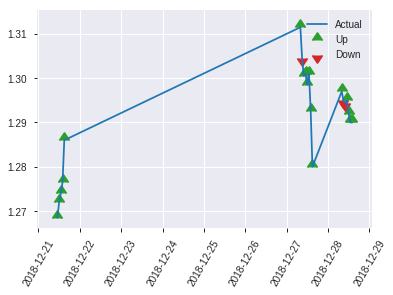


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19509707819476266
RMSE: 0.44169794904975807
LogLoss: 0.5737453032028982
Mean Per-Class Error: 0.2679852206042165
AUC: 0.7709193653553575
pr_auc: 0.6687245793178265
Gini: 0.5418387307107151
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46790820360183716: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      69   38   0.3551   (38.0/107.0)
1      16   70   0.186    (16.0/86.0)
Total  85   108  0.2798   (54.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467908     0.721649  107
max f2                       0.205199     0.830078  167
max f0point5                 0.541698     0.704225  84
max accuracy                 0.541698     0.735751  84
max precision                0.827602     1         0
max recall                   0.137082     1         182
max specificity              0.827602     1         0
max absolute_mcc             0.541698     0.464585  84
max min_per_class_accuracy   0.520064     0.719626  91
max mean_per_class_accuracy  0.541698     0.732015  84

Gains/Lift Table: Avg response rate: 44.56 %, avg score: 47.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.815135           2.24419   2.24419            1                0.822819  1                           0.822819            0.0232558       0.0232558                  124.419   124.419
    2        0.0207254                   0.796435           2.24419   2.24419            1                0.807335  1                           0.815077            0.0232558       0.0465116                  124.419   124.419
    3        0.0310881                   0.771508           0         1.49612            0                0.790735  0.666667                    0.806963            0               0.0465116                  -100      49.6124
    4        0.0414508                   0.761908           1.12209   1.40262            0.5              0.766007  0.625                       0.796724            0.0116279       0.0581395                  12.2093   40.2616
    5        0.0518135                   0.755163           1.12209   1.34651            0.5              0.758147  0.6                         0.789009            0.0116279       0.0697674                  12.2093   34.6512
    6        0.103627                    0.741735           2.01977   1.68314            0.9              0.748797  0.75                        0.768903            0.104651        0.174419                   101.977   68.314
    7        0.150259                    0.701704           1.24677   1.54771            0.555556         0.714572  0.689655                    0.752042            0.0581395       0.232558                   24.677    54.7715
    8        0.202073                    0.677365           1.57093   1.55367            0.7              0.688919  0.692308                    0.735857            0.0813953       0.313953                   57.093    55.3667
    9        0.300518                    0.625573           1.88984   1.66379            0.842105         0.646627  0.741379                    0.706626            0.186047        0.5                        88.9841   66.3793
    10       0.398964                    0.571738           1.29927   1.57384            0.578947         0.600138  0.701299                    0.68035             0.127907        0.627907                   29.9266   57.3845
    11       0.502591                    0.507448           1.12209   1.4807             0.5              0.534906  0.659794                    0.650362            0.116279        0.744186                   12.2093   48.07
    12       0.601036                    0.446807           0.826805  1.3736             0.368421         0.476048  0.612069                    0.62181             0.0813953       0.825581                   -17.3195  37.3597
    13       0.699482                    0.363941           0.590575  1.26339            0.263158         0.404996  0.562963                    0.591296            0.0581395       0.883721                   -40.9425  26.3394
    14       0.797927                    0.254805           0.70869   1.19496            0.315789         0.306925  0.532468                    0.556211            0.0697674       0.953488                   -29.131   19.4956
    15       0.896373                    0.180403           0.354345  1.10263            0.157895         0.220869  0.491329                    0.519381            0.0348837       0.988372                   -64.5655  10.2635
    16       1                           0.0714376          0.112209  1                  0.05             0.132759  0.445596                    0.479317            

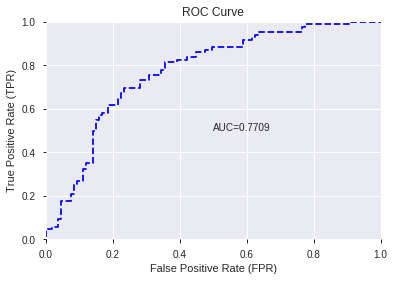

This function is available for GLM models only


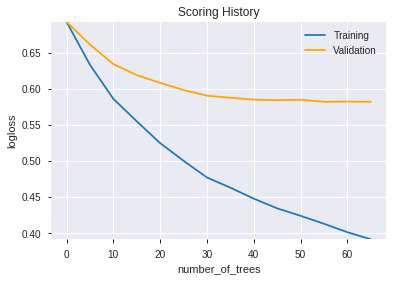

--2019-08-25 13:02:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.84.80
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.84.80|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190825_130152',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190825_130152',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a23f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_a23f',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_130336_model_9  0.776679  0.568019              0.289394  0.441393  0.194828
1  DeepLearning_grid_1_AutoML_20190825_130336_model_8  0.776136  0.569237              0.311834  0.442366  0.195688
2  DeepLearning_grid_1_AutoML_20190825_130336_model_6  0.775701  0.553344              0.281080  0.437199  0.191143
3  DeepLearning_grid_1_AutoML_20190825_130336_model_3  0.771354  0.639022              0.309552  0.450396  0.202857
4  DeepLearning_grid_1_AutoML_20190825_130336_model_7  0.766246  0.592331              0.286079  0.442082  0.195436
5  DeepLearning_grid_1_AutoML_20190825_130336_model_5  0.757118  0.625410              0.295208  0.451654  0.203991
6  DeepLearning_grid_1_AutoML_20190825_130336_model_1  0.750543  0.835491              0.325853  0.475215  0.225829
7               DeepLearning_1_AutoML_20190825_130336  0.748424  0.614657              0.301022  0.454082  0.206190
8  DeepLearning_grid_1_AutoML_20190825_130336_model_2  0.730276  0.668024              0.318789  0.471041  0.221880
9  DeepLearning_grid_1_AutoML_20190825_130336_model_4  0.730059  0.842971              0.328135  0.506374  0.256415

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.048917
1    CDLCLOSINGMARUBOZU             0.896743           0.896743    0.043866
2           CDLLONGLINE             0.740340           0.740340    0.036216
3                  hour             0.602899           0.602899    0.029492
4           CDLMARUBOZU             0.485740           0.485740    0.023761
5        CDL3LINESTRIKE             0.450452           0.450452    0.022035
6              CORREL_8             0.449382           0.449382    0.021983
7                TRANGE             0.439025           0.439025    0.021476
8        CDLMORNINGSTAR             0.436798           0.436798    0.021367
9                SAREXT             0.426468           0.426468    0.020862
10                  SUB             0.424315           0.424315    0.020756
11  CDLGAPSIDESIDEWHITE             0.421701           0.421701    0.020629
12         STOCHF_fastk             0.401984           0.401984    0.019664
13    CDL3WHITESOLDIERS             0.393646           0.393646    0.019256
14                VAR_8             0.392812           0.392812    0.019215
15                  DIV             0.390242           0.390242    0.019090
16         is_month_end             0.387729           0.387729    0.018967
17      CDLLADDERBOTTOM             0.385575           0.385575    0.018861
18               ULTOSC             0.384066           0.384066    0.018788
19        days_in_month             0.383110           0.383110    0.018741
20         CDLTHRUSTING             0.380665           0.380665    0.018621
21          CDLPIERCING             0.378504           0.378504    0.018515
22           CDL3INSIDE             0.378088           0.378088    0.018495
23       CDLEVENINGSTAR             0.377596           0.377596    0.018471
24    CDLDARKCLOUDCOVER             0.374438           0.374438    0.018317
25            dayofweek             0.374058           0.374058    0.018298
26    CDLSTALLEDPATTERN             0.372642           0.372642    0.018229
27      CDLHOMINGPIGEON             0.368552           0.368552    0.018029
28   CDLIDENTICAL3CROWS             0.368008           0.368008    0.018002
29               Volume             0.366938           0.366938    0.017950
30        CDLHANGINGMAN             0.366691           0.366691    0.017938
31   CDLSEPARATINGLINES             0.363671           0.363671    0.017790
32         CDLTASUKIGAP             0.357851           0.357851    0.017505
33      CDLSHOOTINGSTAR             0.351755           0.351755    0.017207
34       STOCHRSI_fastk             0.348293           0.348293    0.017038
35      CDLADVANCEBLOCK             0.344770           0.344770    0.016865
36                  day             0.343948           0.343948    0.016825
37           aroonup_20             0.343821           0.343821    0.016819
38            CDLTAKURI             0.342923           0.342923    0.016775
39    CDLGRAVESTONEDOJI             0.341102           0.341102    0.016686
40    CDLINVERTEDHAMMER             0.339635           0.339635    0.016614
41              weekday             0.338637           0.338637    0.016565
42         HT_TRENDMODE             0.337037           0.337037    0.016487
43     CDLDRAGONFLYDOJI             0.336000           0.336000    0.016436
44       is_month_start             0.335087           0.335087    0.016392
45       CDLMATCHINGLOW             0.333665           0.333665    0.016322
46          CDLDOJISTAR             0.332616           0.332616    0.016271
47              WILLR_8             0.327008           0.327008    0.015996
48            CDLHAMMER             0.320203           0.320203    0.015663
49  CDLXSIDEGAP3METHODS             0.305399           0.305399    0.014939

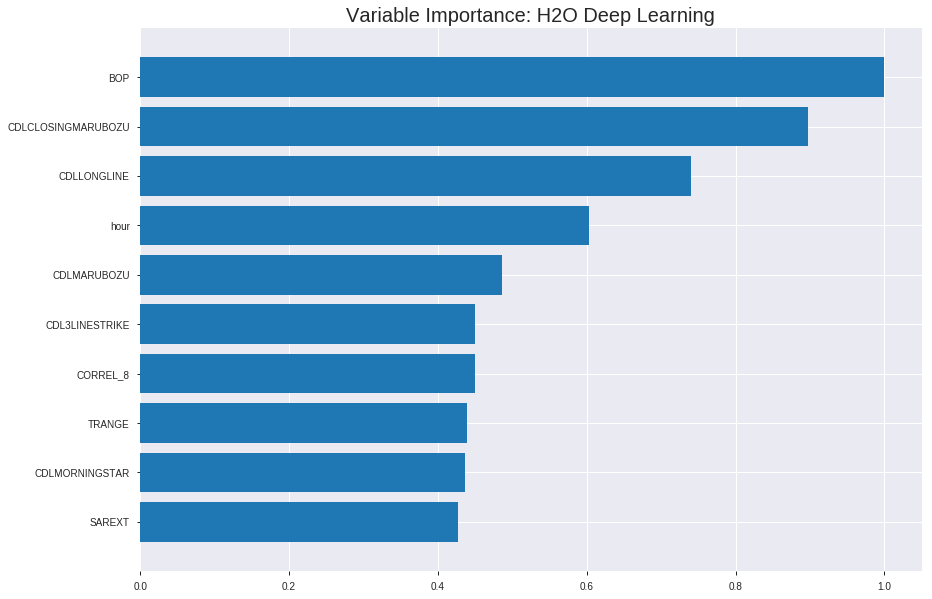

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_130336_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1888455937597649
RMSE: 0.4345636820533498
LogLoss: 0.5568138126112444
Mean Per-Class Error: 0.28271090097747553
AUC: 0.7892915958351041
pr_auc: 0.7556627704281987
Gini: 0.5785831916702082
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34972255360512516: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      408  316  0.4365   (316.0/724.0)
1      91   533  0.1458   (91.0/624.0)
Total  499  849  0.3019   (407.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.349723     0.723693  250
max f2                       0.156044     0.83587   337
max f0point5                 0.530102     0.702381  155
max accuracy                 0.461187     0.717359  196
max precision                0.930092     1         0
max recall                   0.0583903    1         389
max specificity              0.930092     1         0
max absolute_mcc             0.378821     0.434709  236
max min_per_class_accuracy   0.461187     0.716346  196
max mean_per_class_accuracy  0.461187     0.717289  196

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 42.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.863171           2.00595   2.00595            0.928571         0.883806  0.928571                    0.883806            0.0208333       0.0208333                  100.595   100.595
    2        0.0200297                   0.853513           1.99408   2.00024            0.923077         0.858736  0.925926                    0.871735            0.0192308       0.0400641                  99.4083   100.024
    3        0.0304154                   0.829278           2.16026   2.05488            1                0.8451    0.95122                     0.86264             0.0224359       0.0625                     116.026   105.488
    4        0.0400593                   0.810591           1.99408   2.04024            0.923077         0.818395  0.944444                    0.851988            0.0192308       0.0817308                  99.4083   104.024
    5        0.0504451                   0.795267           2.16026   2.06495            1                0.803872  0.955882                    0.842082            0.0224359       0.104167                   116.026   106.495
    6        0.100148                    0.71408            1.80559   1.93623            0.835821         0.749407  0.896296                    0.796088            0.0897436       0.19391                    80.5587   93.623
    7        0.150593                    0.660065           1.58842   1.81972            0.735294         0.689356  0.842365                    0.760335            0.0801282       0.274038                   58.8424   81.9723
    8        0.200297                    0.620777           1.5154    1.74421            0.701493         0.639142  0.807407                    0.730261            0.0753205       0.349359                   51.5404   74.4207
    9        0.300445                    0.560437           1.45617   1.6482             0.674074         0.592207  0.762963                    0.684243            0.145833        0.495192                   45.6173   64.8196
    10       0.399852                    0.505792           1.27358   1.55506            0.589552         0.532105  0.719852                    0.64642             0.126603        0.621795                   27.3584   55.5064
    11       0.5                         0.448812           1.05613   1.45513            0.488889         0.478534  0.673591                    0.612793            0.105769        0.727564                   5.61254   45.5128
    12       0.600148                    0.374401           1.00812   1.38053            0.466667         0.411868  0.639061                    0.579264            0.100962        0.828526                   0.811966  38.0535
    13       0.699555                    0.264536           0.596489  1.26912            0.276119         0.326254  0.587487                    0.543312            0.0592949       0.887821                   -40.3511  26.9122
    14       0.799703                    0.17063            0.67208   1.19435            0.311111         0.216643  0.552876                    0.502402            0.0673077       0.955128                   -32.792   19.4353
    15       0.899852                    0.120167           0.320038  1.09705            0.148148         0.144993  0.507832                    0.462625            0.0320513       0.987179                   -67.9962  9.70469
    16       1                           0.0104938          0.128015  1                  0.0592593        0.083747  0.462908                    0.424681          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19405333967828986
RMSE: 0.4405148575000506
LogLoss: 0.5726560594819541
Mean Per-Class Error: 0.27625324114088157
AUC: 0.7771445548833189
pr_auc: 0.730761535467011
Gini: 0.5542891097666378
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35143056999816547: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      124  84   0.4038   (84.0/208.0)
1      31   147  0.1742   (31.0/178.0)
Total  155  231  0.2979   (115.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.351431     0.718826  230
max f2                       0.143804     0.829268  312
max f0point5                 0.571831     0.710145  127
max accuracy                 0.466846     0.722798  182
max precision                0.928916     1         0
max recall                   0.0541765    1         372
max specificity              0.928916     1         0
max absolute_mcc             0.45809      0.446164  190
max min_per_class_accuracy   0.463924     0.719101  184
max mean_per_class_accuracy  0.45809      0.723747  190

Gains/Lift Table: Avg response rate: 46.11 %, avg score: 41.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.859357           2.16854   2.16854            1                0.878211   1                           0.878211            0.0224719       0.0224719                  116.854   116.854
    2        0.0207254                   0.834594           2.16854   2.16854            1                0.85021    1                           0.864211            0.0224719       0.0449438                  116.854   116.854
    3        0.0310881                   0.814914           1.08427   1.80712            0.5              0.822832   0.833333                    0.850418            0.011236        0.0561798                  8.42697   80.7116
    4        0.0414508                   0.777811           2.16854   1.89747            1                0.794727   0.875                       0.836495            0.0224719       0.0786517                  116.854   89.7472
    5        0.0518135                   0.764692           1.6264    1.84326            0.75             0.77136    0.85                        0.823468            0.0168539       0.0955056                  62.6404   84.3258
    6        0.101036                    0.717783           1.712     1.77931            0.789474         0.734418   0.820513                    0.780085            0.0842697       0.179775                   71.2005   77.9314
    7        0.150259                    0.66578            1.59787   1.71988            0.736842         0.690794   0.793103                    0.750834            0.0786517       0.258427                   59.7871   71.9876
    8        0.202073                    0.63366            1.84326   1.75151            0.85             0.646454   0.807692                    0.72407             0.0955056       0.353933                   84.3258   75.1513
    9        0.300518                    0.582206           1.3696    1.6264             0.631579         0.610403   0.75                        0.686834            0.134831        0.488764                   36.9604   62.6404
    10       0.401554                    0.513782           1.16768   1.51098            0.538462         0.551595   0.696774                    0.652806            0.117978        0.606742                   16.7675   51.0982
    11       0.5                         0.449121           1.31254   1.47191            0.605263         0.481737   0.678756                    0.619124            0.129213        0.735955                   31.2537   47.191
    12       0.601036                    0.349908           0.889657  1.37403            0.410256         0.39944    0.633621                    0.582195            0.0898876       0.825843                   -11.0343  37.4031
    13       0.699482                    0.228815           0.513601  1.25293            0.236842         0.287078   0.577778                    0.54066             0.0505618       0.876404                   -48.6399  25.2934
    14       0.800518                    0.146475           0.611639  1.17199            0.282051         0.187728   0.540453                    0.496115            0.0617978       0.938202                   -38.8361  17.1994
    15       0.898964                    0.103627           0.399468  1.08739            0.184211         0.124377   0.501441                    0.455406            0.0393258       0.977528                   -60.0532  8.73944
    16       1                           0.0173632          0.222414  1                  0.102564         0.0665997  0.46114                     


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 13:11:07  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 13:11:09  2 min 36.038 sec  501 obs/sec       0.840504  1             1133       0.522222         0.926767            -0.0969011     0.752041        0.714187           2.16026          0.347923                         0.536883           1.00849               -0.15998         0.741654          0.68004              2.16854            0.354922
    2019-08-25 13:11:20  2 min 46.855 sec  756 obs/sec       6.75223   8             9102       0.443722         0.573854            0.208084       0.773223        0.740412           2.16026          0.321217                         0.451199           0.591771              0.18073          0.7631            0.702299             2.16854            0.282383
    2019-08-25 13:11:31  2 min 57.920 sec  878 obs/sec       14.3635   17            19362      0.440738         0.569953            0.218701       0.781159        0.748287           2.00595          0.316766                         0.444195           0.578242              0.205966         0.770284          0.721786             2.16854            0.292746
    2019-08-25 13:11:42  3 min  8.650 sec  969 obs/sec       22.8027   27            30738      0.437046         0.560298            0.231734       0.783914        0.748648           1.85165          0.300445                         0.445033           0.582007              0.202967         0.768664          0.724785             2.16854            0.303109
    2019-08-25 13:11:53  3 min 19.611 sec  1040 obs/sec      32.0935   38            43262      0.434564         0.556814            0.240438       0.789292        0.755663           2.00595          0.301929                         0.440515           0.572656              0.219069         0.777145          0.730762             2.16854            0.297927
    2019-08-25 13:12:04  3 min 30.960 sec  1097 obs/sec      42.2611   50            56968      0.433753         0.554811            0.243267       0.79596         0.759708           1.85165          0.293769                         0.442991           0.574922              0.210264         0.772715          0.73213              2.16854            0.290155
    2019-08-25 13:12:15  3 min 41.964 sec  1141 obs/sec      52.362    62            70584      0.427557         0.541275            0.264735       0.80311         0.768856           1.85165          0.295994                         0.44307            0.578227              0.209984         0.773147          0.732734             2.16854            0.323834
    2019-08-25 13:12:16  3 min 43.047 sec  1141 obs/sec      52.362    62            70584      0.434564         0.556814            0.240438       0.789292        0.755663           2.00595          0.301929                         0.440515           0.572656              0.219069         0.777145          0.730762             2.16854            0.297927

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
BOP                  1.0                    1.0                  0.048917391973127874
CDLCLOSINGMARUBOZU   0.8967425227165222     0.8967425227165222   0.04386630548269564
CDLLONGLINE          0.740339994430542      0.740339994430542    0.03621550170094213
hour                 0.6028986573219299     0.6028986573219299   0.029492229940289345
CDLMARUBOZU          0.48573988676071167    0.48573988676071167  0.023761128437656476
---                  ---                    ---                  ---
CDLMATCHINGLOW       0.33366483449935913    0.33366483449935913  0.01632201349685399
CDLDOJISTAR          0.3326164782047272     0.3326164782047272   0.016270730641061982
WILLR_8              0.3270079791545868     0.3270079791545868   0.01599637749464535
CDLHAMMER            0.3202030658721924     0.3202030658721924   0.015663498884267317
CDLXSIDEGAP3METHODS  0.3053988516330719     0.3053988516330719   0.014939315333478101


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7253886010362695)

('F1', 0.714975845410628)

('auc', 0.7766789828298196)

('logloss', 0.5680189790822323)

('mean_per_class_error', 0.2784720712888502)

('rmse', 0.44139279086300226)

('mse', 0.19482759582583004)

deeplearning prediction progress: |███████████████████████████████████████| 100%


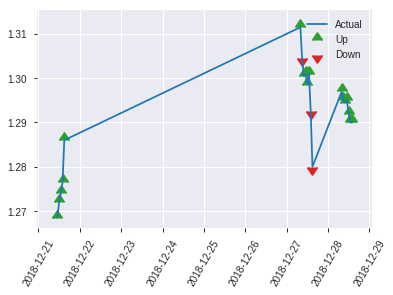


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19482759582583004
RMSE: 0.44139279086300226
LogLoss: 0.5680189790822323
Mean Per-Class Error: 0.2784720712888502
AUC: 0.7766789828298196
pr_auc: 0.6782673318685727
Gini: 0.5533579656596392
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29384695827191964: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      60   47   0.4393   (47.0/107.0)
1      12   74   0.1395   (12.0/86.0)
Total  72   121  0.3057   (59.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.293847     0.714976  120
max f2                       0.125309     0.844794  164
max f0point5                 0.469687     0.69378   82
max accuracy                 0.469687     0.725389  82
max precision                0.859219     1         0
max recall                   0.125309     1         164
max specificity              0.859219     1         0
max absolute_mcc             0.459556     0.443586  84
max min_per_class_accuracy   0.434263     0.709302  91
max mean_per_class_accuracy  0.459556     0.721528  84

Gains/Lift Table: Avg response rate: 44.56 %, avg score: 40.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.851099           2.24419   2.24419            1                0.855365   1                           0.855365            0.0232558       0.0232558                  124.419   124.419
    2        0.0207254                   0.83645            1.12209   1.68314            0.5              0.849408   0.75                        0.852386            0.0116279       0.0348837                  12.2093   68.314
    3        0.0310881                   0.793861           2.24419   1.87016            1                0.821273   0.833333                    0.842015            0.0232558       0.0581395                  124.419   87.0155
    4        0.0414508                   0.773496           1.12209   1.68314            0.5              0.784963   0.75                        0.827752            0.0116279       0.0697674                  12.2093   68.314
    5        0.0518135                   0.742917           1.12209   1.57093            0.5              0.756619   0.7                         0.813526            0.0116279       0.0813953                  12.2093   57.093
    6        0.103627                    0.694717           1.79535   1.68314            0.8              0.718507   0.75                        0.766016            0.0930233       0.174419                   79.5349   68.314
    7        0.150259                    0.656739           1.49612   1.6251             0.666667         0.678103   0.724138                    0.738733            0.0697674       0.244186                   49.6124   62.51
    8        0.202073                    0.60282            1.34651   1.55367            0.6              0.626174   0.692308                    0.709872            0.0697674       0.313953                   34.6512   55.3667
    9        0.300518                    0.54031            1.65361   1.58641            0.736842         0.57531    0.706897                    0.665791            0.162791        0.476744                   65.3611   58.6407
    10       0.398964                    0.482938           1.5355    1.57384            0.684211         0.511508   0.701299                    0.627721            0.151163        0.627907                   53.5496   57.3845
    11       0.502591                    0.422559           0.897674  1.43443            0.4              0.45133    0.639175                    0.591352            0.0930233       0.72093                    -10.2326  43.4428
    12       0.601036                    0.330598           0.94492   1.35425            0.421053         0.379714   0.603448                    0.556687            0.0930233       0.813953                   -5.50796  35.425
    13       0.699482                    0.228448           0.94492   1.29664            0.421053         0.272175   0.577778                    0.516645            0.0930233       0.906977                   -5.50796  29.6641
    14       0.797927                    0.14644            0.590575  1.20953            0.263158         0.186753   0.538961                    0.475944            0.0581395       0.965116                   -40.9425  20.9529
    15       0.896373                    0.113787           0.354345  1.11561            0.157895         0.12786    0.49711                     0.437715            0.0348837       1                          -64.5655  11.5607
    16       1                           0.0440391          0         1                  0                0.0879176  0.445596                    0.4014

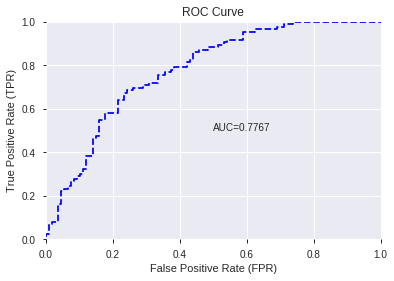

This function is available for GLM models only


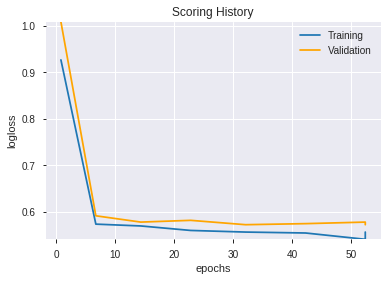

--2019-08-25 13:12:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.120.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.120.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_130336_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_130336_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a23f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'hour',
 'CDLMARUBOZU',
 'CDL3LINESTRIKE',
 'CORREL_8',
 'TRANGE',
 'CDLMORNINGSTAR',
 'SAREXT',
 'SUB',
 'CDLGAPSIDESIDEWHITE',
 'STOCHF_fastk',
 'CDL3WHITESOLDIERS',
 'VAR_8',
 'DIV',
 'is_month_end',
 'CDLLADDERBOTTOM',
 'ULTOSC',
 'days_in_month',
 'CDLTHRUSTING',
 'CDLPIERCING',
 'CDL3INSIDE',
 'CDLEVENINGSTAR',
 'CDLDARKCLOUDCOVER',
 'dayofweek',
 'CDLSTALLEDPATTERN',
 'CDLHOMINGPIGEON',
 'CDLIDENTICAL3CROWS',
 'Volume',
 'CDLHANGINGMAN',
 'CDLSEPARATINGLINES',
 'CDLTASUKIGAP',
 'CDLSHOOTINGSTAR',
 'STOCHRSI_fastk',
 'CDLADVANCEBLOCK',
 'day',
 'aroonup_20',
 'CDLTAKURI',
 'CDLGRAVESTONEDOJI',
 'CDLINVERTEDHAMMER',
 'weekday',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'is_month_start',
 'CDLMATCHINGLOW',
 'CDLDOJISTAR',
 'WILLR_8',
 'CDLHAMMER',
 'CDLXSIDEGAP3METHODS']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_131324_model_1  0.769724  0.569015              0.292925  0.440578  0.194109

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.681319           1.000000    0.176840
1    CDLCLOSINGMARUBOZU             0.339041           0.497625    0.088000
2                   SUB             0.229245           0.336473    0.059502
3                  hour             0.226044           0.331775    0.058671
4                ULTOSC             0.179912           0.264064    0.046697
5                SAREXT             0.138651           0.203503    0.035988
6           CDLPIERCING             0.132416           0.194352    0.034369
7   CDLGAPSIDESIDEWHITE             0.126201           0.185230    0.032756
8    CDLIDENTICAL3CROWS             0.109066           0.160080    0.028309
9                Volume             0.107365           0.157585    0.027867
10      CDLHOMINGPIGEON             0.093746           0.137595    0.024332
11       CDL3LINESTRIKE             0.088246           0.129522    0.022905
12           aroonup_20             0.083095           0.121962    0.021568
13        days_in_month             0.082934           0.121726    0.021526
14       CDLMORNINGSTAR             0.080616           0.118323    0.020924
15          CDLLONGLINE             0.080581           0.118273    0.020915
16            CDLHAMMER             0.071582           0.105064    0.018580
17      CDLLADDERBOTTOM             0.064041           0.093995    0.016622
18        CDLHANGINGMAN             0.060331           0.088550    0.015659
19               TRANGE             0.058535           0.085915    0.015193
20            dayofweek             0.058251           0.085498    0.015119
21              weekday             0.057892           0.084971    0.015026
22      CDLSHOOTINGSTAR             0.052705           0.077358    0.013680
23                  day             0.048832           0.071673    0.012675
24         CDLTHRUSTING             0.047637           0.069919    0.012365
25             CORREL_8             0.046479           0.068219    0.012064
26    CDLINVERTEDHAMMER             0.045898           0.067366    0.011913
27    CDLGRAVESTONEDOJI             0.044665           0.065557    0.011593
28    CDL3WHITESOLDIERS             0.043021           0.063144    0.011166
29       STOCHRSI_fastk             0.042509           0.062393    0.011034
30   CDLSEPARATINGLINES             0.038207           0.056078    0.009917
31     CDLDRAGONFLYDOJI             0.035565           0.052200    0.009231
32       CDLEVENINGSTAR             0.030643           0.044976    0.007954
33                VAR_8             0.029869           0.043839    0.007753
34       CDLMATCHINGLOW             0.028979           0.042533    0.007522
35         is_month_end             0.026715           0.039210    0.006934
36  CDLXSIDEGAP3METHODS             0.026391           0.038734    0.006850
37            CDLTAKURI             0.023126           0.033943    0.006002
38              WILLR_8             0.017438           0.025594    0.004526
39    CDLDARKCLOUDCOVER             0.016115           0.023652    0.004183
40          CDLDOJISTAR             0.013050           0.019154    0.003387
41    CDLSTALLEDPATTERN             0.010350           0.015191    0.002686
42           CDL3INSIDE             0.009088           0.013339    0.002359
43         STOCHF_fastk             0.006318           0.009274    0.001640
44         HT_TRENDMODE             0.005496           0.008067    0.001427
45         CDLTASUKIGAP             0.004408           0.006470    0.001144
46                  DIV             0.004266           0.006261    0.001107
47      CDLADVANCEBLOCK             0.003953           0.005802    0.001026
48       is_month_start             0.001211           0.001777    0.000314
49          CDLMARUBOZU             0.000698           0.001024    0.000181

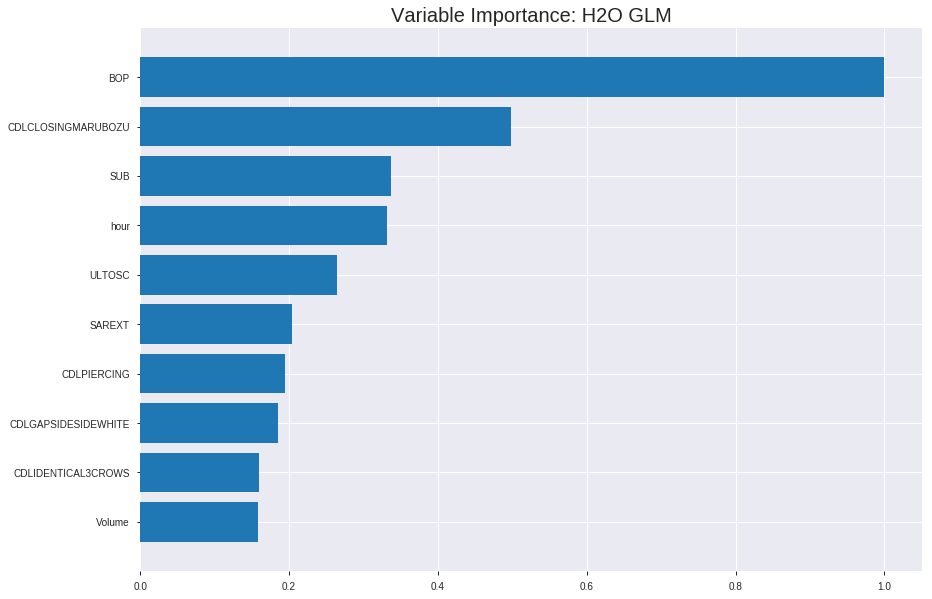

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_131324_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19098163382655264
RMSE: 0.4370144549400542
LogLoss: 0.559846227336136
Null degrees of freedom: 1347
Residual degrees of freedom: 1297
Null deviance: 1861.2995819096327
Residual deviance: 1509.3454288982225
AIC: 1611.3454288982225
AUC: 0.7783414789630259
pr_auc: 0.7452198808837991
Gini: 0.5566829579260517
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3923219435114517: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      431  293  0.4047   (293.0/724.0)
1      110  514  0.1763   (110.0/624.0)
Total  541  807  0.299    (403.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.392322     0.718379  238
max f2                       0.223482     0.835408  318
max f0point5                 0.547024     0.695915  160
max accuracy                 0.543766     0.709199  162
max precision                0.990428     1         0
max recall                   0.0635088    1         382
max specificity              0.990428     1         0
max absolute_mcc             0.392322     0.426248  238
max min_per_class_accuracy   0.467733     0.701657  201
max mean_per_class_accuracy  0.404627     0.710365  232

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 46.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.933404           2.16026   2.16026            1                0.956196   1                           0.956196            0.0224359       0.0224359                  116.026   116.026
    2        0.0200297                   0.912487           1.99408   2.08025            0.923077         0.923479   0.962963                    0.940443            0.0192308       0.0416667                  99.4083   108.025
    3        0.0304154                   0.89267            2.16026   2.10757            1                0.900788   0.97561                     0.926903            0.0224359       0.0641026                  116.026   110.757
    4        0.0400593                   0.877931           1.82791   2.04024            0.846154         0.885081   0.944444                    0.916835            0.0176282       0.0817308                  82.7909   104.024
    5        0.0504451                   0.853781           1.85165   2.00141            0.857143         0.864855   0.926471                    0.906133            0.0192308       0.100962                   85.1648   100.141
    6        0.100148                    0.769454           1.70886   1.85622            0.791045         0.806669   0.859259                    0.85677             0.0849359       0.185897                   70.886    85.622
    7        0.150593                    0.718607           1.68373   1.79844            0.779412         0.740242   0.832512                    0.817736            0.0849359       0.270833                   68.3729   79.844
    8        0.200297                    0.672004           1.28971   1.6722             0.597015         0.697363   0.774074                    0.787865            0.0641026       0.334936                   28.9705   67.2198
    9        0.300445                    0.597062           1.52018   1.62153            0.703704         0.635803   0.750617                    0.737178            0.152244        0.487179                   52.018    62.1526
    10       0.399852                    0.529044           1.25746   1.53102            0.58209          0.56288    0.70872                     0.693846            0.125           0.612179                   25.7463   53.1017
    11       0.5                         0.456879           1.07213   1.4391             0.496296         0.493241   0.666172                    0.653665            0.107372        0.719551                   7.21273   43.9103
    12       0.600148                    0.39094            1.04012   1.37252            0.481481         0.423105   0.635352                    0.615191            0.104167        0.823718                   4.01235   37.2524
    13       0.699555                    0.325911           0.61261   1.26454            0.283582         0.358836   0.585366                    0.578763            0.0608974       0.884615                   -38.739   26.454
    14       0.799703                    0.243946           0.640076  1.18634            0.296296         0.287127   0.549165                    0.542241            0.0641026       0.948718                   -35.9924  18.6337
    15       0.899852                    0.148483           0.320038  1.08992            0.148148         0.204279   0.504534                    0.504628            0.0320513       0.980769                   -67.9962  8.99233
    16       1                           0.00258285         0.192023  1                  0.0888889        0.0880499  0.462908                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19532130159518232
RMSE: 0.44195169599763084
LogLoss: 0.5745080612890666
Null degrees of freedom: 385
Residual degrees of freedom: 335
Null deviance: 532.7805186446055
Residual deviance: 443.52022331515946
AIC: 545.5202233151595
AUC: 0.7674481417458945
pr_auc: 0.7124248860555509
Gini: 0.534896283491789
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39097635365203515: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      123  85   0.4087   (85.0/208.0)
1      27   151  0.1517   (27.0/178.0)
Total  150  236  0.2902   (112.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390976     0.729469  235
max f2                       0.226286     0.835777  310
max f0point5                 0.466141     0.685567  197
max accuracy                 0.466141     0.715026  197
max precision                0.968917     1         0
max recall                   0.0231141    1         384
max specificity              0.968917     1         0
max absolute_mcc             0.390976     0.449633  235
max min_per_class_accuracy   0.481773     0.701923  186
max mean_per_class_accuracy  0.390976     0.71983   235

Gains/Lift Table: Avg response rate: 46.11 %, avg score: 46.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.921982           2.16854   2.16854            1                0.942228   1                           0.942228            0.0224719       0.0224719                  116.854    116.854
    2        0.0207254                   0.895709           1.6264    1.89747            0.75             0.912866   0.875                       0.927547            0.0168539       0.0393258                  62.6404    89.7472
    3        0.0310881                   0.87436            2.16854   1.98783            1                0.880847   0.916667                    0.91198             0.0224719       0.0617978                  116.854    98.7828
    4        0.0414508                   0.839132           2.16854   2.03301            1                0.857472   0.9375                      0.898353            0.0224719       0.0842697                  116.854    103.301
    5        0.0518135                   0.821356           1.6264    1.95169            0.75             0.830043   0.9                         0.884691            0.0168539       0.101124                   62.6404    95.1685
    6        0.101036                    0.754135           1.48374   1.72371            0.684211         0.780605   0.794872                    0.833983            0.0730337       0.174157                   48.3737    72.3711
    7        0.150259                    0.714098           1.25547   1.57032            0.578947         0.735391   0.724138                    0.801685            0.0617978       0.235955                   25.547     57.0322
    8        0.202073                    0.677836           1.6264    1.5847             0.75             0.692558   0.730769                    0.773704            0.0842697       0.320225                   62.6404    58.4702
    9        0.300518                    0.613392           1.712     1.6264             0.789474         0.650058   0.75                        0.733199            0.168539        0.488764                   71.2005    62.6404
    10       0.401554                    0.540551           1.05647   1.483              0.487179         0.579237   0.683871                    0.69446             0.106742        0.595506                   5.64679    48.3001
    11       0.5                         0.473868           1.31254   1.44944            0.605263         0.505986   0.668394                    0.657351            0.129213        0.724719                   31.2537    44.9438
    12       0.601036                    0.394594           1.00086   1.37403            0.461538         0.434109   0.633621                    0.619824            0.101124        0.825843                   0.0864304  37.4031
    13       0.699482                    0.321756           0.684802  1.27703            0.315789         0.360832   0.588889                    0.583373            0.0674157       0.893258                   -31.5198   27.7029
    14       0.800518                    0.232077           0.556036  1.18603            0.25641          0.277386   0.546926                    0.544753            0.0561798       0.949438                   -44.3964   18.603
    15       0.898964                    0.124281           0.228267  1.08114            0.105263         0.182594   0.498559                    0.505093            0.0224719       0.97191                    -77.1733   8.1145
    16       1                           0.00906545         0.278018  1                  0.128205         0.0734422  0.46114     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-25 13:13:24  0.000 sec   2            .21E2     51            1.364899894972509   1.3645946441692889
     2019-08-25 13:13:24  0.009 sec   4            .13E2     51            1.3562330913253906  1.3560824025333955
     2019-08-25 13:13:24  0.017 sec   6            .8E1      51            1.3436607801140201  1.343783358689926
     2019-08-25 13:13:24  0.026 sec   8            .49E1     51            1.3263330936148452  1.326941184201864
     2019-08-25 13:13:24  0.032 sec   10           .31E1     51            1.3040783416131638  1.3055155815533397
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-25 13:13:24  0.110 sec   34           .1E-1     51            1.117733556423578   1.1495507950098822
     2019-08-25 13:13:24  0.116 sec   36           .63E-2    51            1.1163843354487388  1.1519549879542144
     2019-08-25 13:13:24  0.124 sec   38           .39E-2    51            1.115356363126258   1.1569315379124394
     2019-08-25 13:13:24  0.129 sec   40           .24E-2    51            1.1145303325958125  1.1652797449175456
     2019-08-25 13:13:24  0.135 sec   42           .15E-2    51            1.113891770051282   1.1771511179380707


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7202072538860104)

('F1', 0.7142857142857143)

('auc', 0.7697239730493372)

('logloss', 0.5690154829736648)

('mean_per_class_error', 0.28678548141708327)

('rmse', 0.44057849991663683)

('mse', 0.19410941458879397)

glm prediction progress: |████████████████████████████████████████████████| 100%


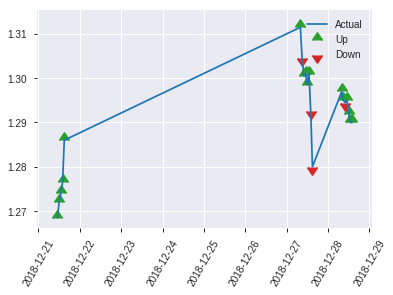


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19410941458879397
RMSE: 0.44057849991663683
LogLoss: 0.5690154829736648
Null degrees of freedom: 192
Residual degrees of freedom: 142
Null deviance: 265.4984131782047
Residual deviance: 219.63997642783463
AIC: 321.63997642783465
AUC: 0.7697239730493372
pr_auc: 0.6528966556469644
Gini: 0.5394479460986743
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3418224343310601: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      58   49   0.4579   (49.0/107.0)
1      11   75   0.1279   (11.0/86.0)
Total  69   124  0.3109   (60.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.341822     0.714286  123
max f2                       0.212216     0.851485  160
max f0point5                 0.545368     0.696721  69
max accuracy                 0.545368     0.720207  69
max precision                0.927459     1         0
max recall                   0.212216     1         160
max specificity              0.927459     1         0
max absolute_mcc             0.341822     0.429499  123
max min_per_class_accuracy   0.490775     0.697674  89
max mean_per_class_accuracy  0.443235     0.713215  97

Gains/Lift Table: Avg response rate: 44.56 %, avg score: 45.21 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0103627                   0.911387           1.12209  1.12209            0.5              0.924232   0.5                         0.924232            0.0116279       0.0116279                  12.2093  12.2093
    2        0.0207254                   0.885638           2.24419  1.68314            1                0.902541   0.75                        0.913387            0.0232558       0.0348837                  124.419  68.314
    3        0.0310881                   0.848822           1.12209  1.49612            0.5              0.881257   0.666667                    0.902677            0.0116279       0.0465116                  12.2093  49.6124
    4        0.0414508                   0.806167           1.12209  1.40262            0.5              0.823976   0.625                       0.883002            0.0116279       0.0581395                  12.2093  40.2616
    5        0.0518135                   0.801855           2.24419  1.57093            1                0.804182   0.7                         0.867238            0.0232558       0.0813953                  124.419  57.093
    6        0.103627                    0.746175           1.34651  1.45872            0.6              0.772549   0.65                        0.819893            0.0697674       0.151163                   34.6512  45.8721
    7        0.150259                    0.698665           1.24677  1.39294            0.555556         0.72159    0.62069                     0.789385            0.0581395       0.209302                   24.677   39.2943
    8        0.202073                    0.680982           2.01977  1.55367            0.9              0.688822   0.692308                    0.7636              0.104651        0.313953                   101.977  55.3667
    9        0.300518                    0.600209           1.65361  1.58641            0.736842         0.643006   0.706897                    0.724095            0.162791        0.476744                   65.3611  58.6407
    10       0.398964                    0.514105           1.41738  1.5447             0.631579         0.559927   0.688312                    0.683586            0.139535        0.616279                   41.7381  54.4699
    11       0.502591                    0.448056           1.12209  1.45756            0.5              0.486528   0.649485                    0.642955            0.116279        0.732558                   12.2093  45.7564
    12       0.601036                    0.37983            0.70869  1.3349             0.315789         0.413002   0.594828                    0.605291            0.0697674       0.802326                   -29.131  33.4904
    13       0.699482                    0.303973           1.06304  1.29664            0.473684         0.331875   0.577778                    0.56681             0.104651        0.906977                   6.30355  29.6641
    14       0.797927                    0.226718           0.70869  1.2241             0.315789         0.272185   0.545455                    0.53046             0.0697674       0.976744                   -29.131  22.4101
    15       0.896373                    0.147475           0.23623  1.11561            0.105263         0.188007   0.49711                     0.49285             0.0232558       1                          -76.377  11.5607
    16       1                           0.0172806          0        1                  0                0.0997583  0.445596                    0.452115            0               

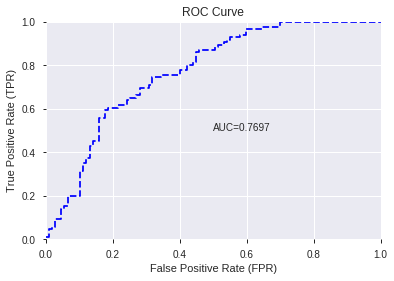

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


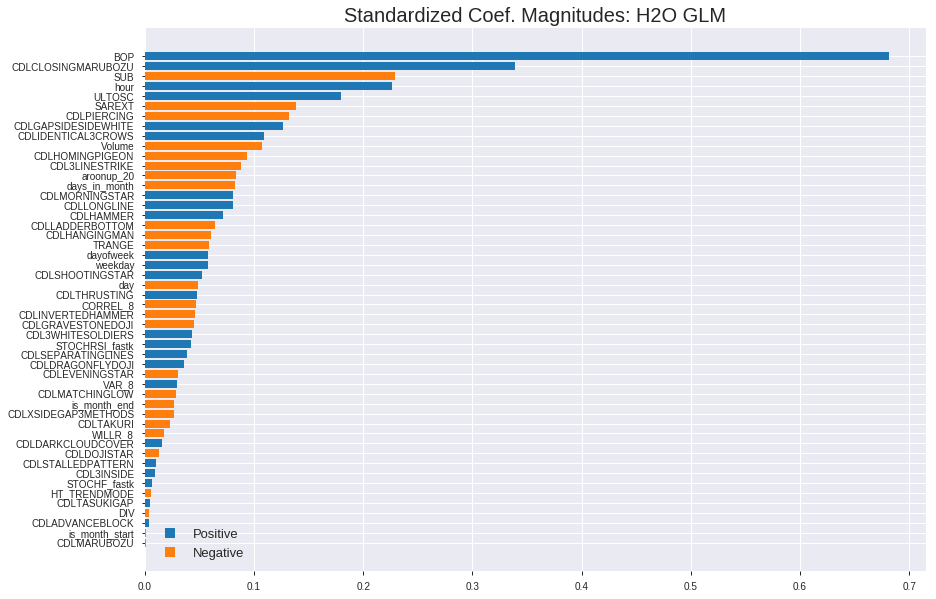

'log_likelihood'
--2019-08-25 13:13:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.147.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.147.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_131324_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_131324_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a23f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'hour',
 'ULTOSC',
 'SAREXT',
 'CDLPIERCING',
 'CDLGAPSIDESIDEWHITE',
 'CDLIDENTICAL3CROWS',
 'Volume',
 'CDLHOMINGPIGEON',
 'CDL3LINESTRIKE',
 'aroonup_20',
 'days_in_month',
 'CDLMORNINGSTAR',
 'CDLLONGLINE',
 'CDLHAMMER',
 'CDLLADDERBOTTOM',
 'CDLHANGINGMAN',
 'TRANGE',
 'dayofweek',
 'weekday',
 'CDLSHOOTINGSTAR',
 'day',
 'CDLTHRUSTING',
 'CORREL_8',
 'CDLINVERTEDHAMMER',
 'CDLGRAVESTONEDOJI',
 'CDL3WHITESOLDIERS',
 'STOCHRSI_fastk',
 'CDLSEPARATINGLINES',
 'CDLDRAGONFLYDOJI',
 'CDLEVENINGSTAR',
 'VAR_8',
 'CDLMATCHINGLOW',
 'is_month_end',
 'CDLXSIDEGAP3METHODS',
 'CDLTAKURI',
 'WILLR_8',
 'CDLDARKCLOUDCOVER',
 'CDLDOJISTAR',
 'CDLSTALLEDPATTERN',
 'CDL3INSIDE',
 'STOCHF_fastk',
 'HT_TRENDMODE',
 'CDLTASUKIGAP',
 'DIV',
 'CDLADVANCEBLOCK',
 'is_month_start',
 'CDLMARUBOZU']

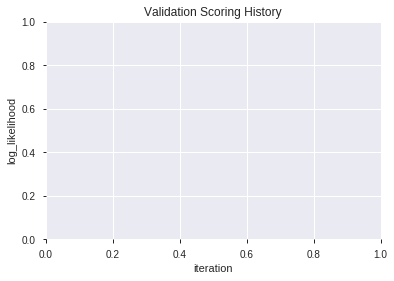

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_131430_model_2  0.762008  0.575219              0.305803  0.443825  0.196980
1  XGBoost_grid_1_AutoML_20190825_131430_model_3  0.757661  0.583281              0.273093  0.446459  0.199326
2  XGBoost_grid_1_AutoML_20190825_131430_model_7  0.754945  0.582926              0.274234  0.446999  0.199808
3               XGBoost_1_AutoML_20190825_131430  0.748642  0.587737              0.293958  0.449198  0.201779
4  XGBoost_grid_1_AutoML_20190825_131430_model_1  0.747772  0.589103              0.288253  0.449698  0.202229
5  XGBoost_grid_1_AutoML_20190825_131430_model_6  0.745381  0.589141              0.306944  0.449933  0.202440
6               XGBoost_3_AutoML_20190825_131430  0.743860  0.592079              0.303412  0.451411  0.203772
7  XGBoost_grid_1_AutoML_20190825_131430_model_5  0.743751  0.599264              0.295208  0.453396  0.205568
8               XGBoost_2_AutoML_20190825_131430  0.742013  0.595099              0.303412  0.452008  0.204311
9  XGBoost_grid_1_AutoML_20190825_131430_model_4  0.740600  0.595372              0.312649  0.452725  0.204960

variable  relative_importance  scaled_importance  percentage
0                   BOP          2417.460449           1.000000    0.362334
1                  hour           445.729858           0.184379    0.066807
2                TRANGE           419.945343           0.173713    0.062942
3                Volume           412.216125           0.170516    0.061784
4                SAREXT           344.090149           0.142335    0.051573
5          STOCHF_fastk           285.254333           0.117998    0.042755
6                 VAR_8           278.681702           0.115279    0.041769
7              CORREL_8           237.127869           0.098090    0.035541
8                   day           234.850021           0.097147    0.035200
9                ULTOSC           228.879715           0.094678    0.034305
10                  DIV           210.831619           0.087212    0.031600
11              WILLR_8           195.666321           0.080939    0.029327
12                  SUB           172.619766           0.071405    0.025873
13       STOCHRSI_fastk           169.962082           0.070306    0.025474
14           aroonup_20           162.888626           0.067380    0.024414
15   CDLCLOSINGMARUBOZU           147.700867           0.061098    0.022138
16            dayofweek            71.122452           0.029420    0.010660
17            CDLHAMMER            69.740982           0.028849    0.010453
18        days_in_month            47.999481           0.019855    0.007194
19        CDLHANGINGMAN            20.142725           0.008332    0.003019
20         HT_TRENDMODE            18.107239           0.007490    0.002714
21          CDLPIERCING            17.526394           0.007250    0.002627
22          CDLLONGLINE            16.654018           0.006889    0.002496
23              weekday             9.976497           0.004127    0.001495
24     CDLDRAGONFLYDOJI             8.102997           0.003352    0.001214
25   CDLSEPARATINGLINES             5.196877           0.002150    0.000779
26      CDLADVANCEBLOCK             4.816015           0.001992    0.000722
27  CDLXSIDEGAP3METHODS             4.672978           0.001933    0.000700
28    CDLDARKCLOUDCOVER             4.061043           0.001680    0.000609
29      CDLSHOOTINGSTAR             3.739440           0.001547    0.000560
30           CDL3INSIDE             3.416008           0.001413    0.000512
31          CDLMARUBOZU             2.253292           0.000932    0.000338
32    CDLGRAVESTONEDOJI             0.471736           0.000195    0.000071

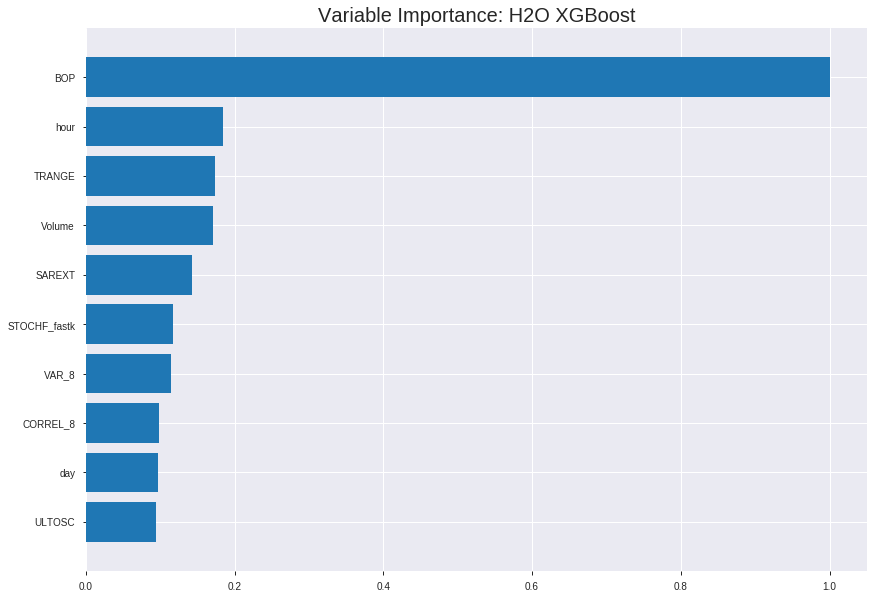

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_131430_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15185375631830839
RMSE: 0.3896841750935088
LogLoss: 0.47470446572942426
Mean Per-Class Error: 0.1841399277518062
AUC: 0.8844217045615526
pr_auc: 0.8646881839048685
Gini: 0.7688434091231051
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.517869234085083: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      614  110  0.1519   (110.0/724.0)
1      135  489  0.2163   (135.0/624.0)
Total  749  599  0.1818   (245.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.517869     0.799673  179
max f2                       0.32216      0.866531  277
max f0point5                 0.549899     0.812137  163
max accuracy                 0.517869     0.818249  179
max precision                0.874874     1         0
max recall                   0.16016      1         355
max specificity              0.874874     1         0
max absolute_mcc             0.517869     0.633916  179
max min_per_class_accuracy   0.492673     0.801105  190
max mean_per_class_accuracy  0.517869     0.81586   179

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 46.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.856039           2.16026   2.16026            1                0.864443  1                           0.864443            0.0224359       0.0224359                  116.026   116.026
    2        0.0200297                   0.84679            2.16026   2.16026            1                0.851998  1                           0.858451            0.0208333       0.0432692                  116.026   116.026
    3        0.0304154                   0.834174           2.00595   2.10757            0.928571         0.841654  0.97561                     0.852716            0.0208333       0.0641026                  100.595   110.757
    4        0.0400593                   0.818518           2.16026   2.12025            1                0.823782  0.981481                    0.84575             0.0208333       0.0849359                  116.026   112.025
    5        0.0504451                   0.809087           2.00595   2.09672            0.928571         0.813514  0.970588                    0.839113            0.0208333       0.105769                   100.595   109.672
    6        0.100148                    0.769077           2.06353   2.08025            0.955224         0.787795  0.962963                    0.813644            0.102564        0.208333                   106.353   108.025
    7        0.150593                    0.73014            2.00141   2.05384            0.926471         0.747845  0.950739                    0.791603            0.100962        0.309295                   100.141   105.384
    8        0.200297                    0.686715           1.7411    1.97623            0.80597          0.707923  0.914815                    0.770838            0.0865385       0.395833                   74.1102   97.6235
    9        0.300445                    0.611316           1.60019   1.85089            0.740741         0.647317  0.85679                     0.729664            0.160256        0.55609                    60.019    85.0886
    10       0.399852                    0.544298           1.6605    1.80355            0.768657         0.579687  0.834879                    0.692379            0.165064        0.721154                   66.0496   80.3554
    11       0.5                         0.47585            1.04012   1.65064            0.481481         0.511844  0.764095                    0.656218            0.104167        0.825321                   4.01235   65.0641
    12       0.600148                    0.39925            0.736087  1.49803            0.340741         0.438051  0.693449                    0.619812            0.0737179       0.899038                   -26.3913  49.8027
    13       0.699555                    0.318934           0.564246  1.36534            0.261194         0.359526  0.632025                    0.582826            0.0560897       0.955128                   -43.5754  36.5337
    14       0.799703                    0.243855           0.272032  1.22842            0.125926         0.281453  0.568646                    0.545084            0.0272436       0.982372                   -72.7968  22.842
    15       0.899852                    0.14431            0.176021  1.11129            0.0814815        0.196757  0.514427                    0.506317            0.0176282       1                          -82.3979  11.1294
    16       1                           0.0875465          0         1                  0                0.116609  0.462908                    0.467289          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19804721432020672
RMSE: 0.4450249592103871
LogLoss: 0.5804107629555514
Mean Per-Class Error: 0.28095289541918755
AUC: 0.7574816335350043
pr_auc: 0.7105527363268404
Gini: 0.5149632670700086
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3757978677749634: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      118  90   0.4327   (90.0/208.0)
1      23   155  0.1292   (23.0/178.0)
Total  141  245  0.2927   (113.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375798     0.732861  244
max f2                       0.135045     0.823917  349
max f0point5                 0.44205      0.675422  221
max accuracy                 0.44205      0.709845  221
max precision                0.867815     1         0
max recall                   0.0934282    1         385
max specificity              0.867815     1         0
max absolute_mcc             0.375798     0.453541  244
max min_per_class_accuracy   0.509083     0.677885  187
max mean_per_class_accuracy  0.375798     0.719047  244

Gains/Lift Table: Avg response rate: 46.11 %, avg score: 46.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.858182           2.16854   2.16854            1                0.863636  1                           0.863636            0.0224719       0.0224719                  116.854   116.854
    2        0.0207254                   0.849638           2.16854   2.16854            1                0.853476  1                           0.858556            0.0224719       0.0449438                  116.854   116.854
    3        0.0310881                   0.817224           2.16854   2.16854            1                0.836198  1                           0.851103            0.0224719       0.0674157                  116.854   116.854
    4        0.0414508                   0.80013            1.6264    2.03301            0.75             0.803371  0.9375                      0.83917             0.0168539       0.0842697                  62.6404   103.301
    5        0.0518135                   0.787607           1.6264    1.95169            0.75             0.792194  0.9                         0.829775            0.0168539       0.101124                   62.6404   95.1685
    6        0.101036                    0.768012           1.48374   1.72371            0.684211         0.775803  0.794872                    0.803481            0.0730337       0.174157                   48.3737   72.3711
    7        0.150259                    0.738816           1.59787   1.68249            0.736842         0.757435  0.775862                    0.788397            0.0786517       0.252809                   59.7871   68.2487
    8        0.202073                    0.705069           1.40955   1.6125             0.65             0.723244  0.74359                     0.771691            0.0730337       0.325843                   40.9551   61.2504
    9        0.300518                    0.620503           1.31254   1.51424            0.605263         0.658789  0.698276                    0.734706            0.129213        0.455056                   31.2537   51.4239
    10       0.401554                    0.562783           1.39009   1.483              0.641026         0.589013  0.683871                    0.698048            0.140449        0.595506                   39.0089   48.3001
    11       0.5                         0.497639           1.08427   1.40449            0.5              0.534818  0.647668                    0.665909            0.106742        0.702247                   8.42697   40.4494
    12       0.601036                    0.407453           1.11207   1.35534            0.512821         0.457834  0.625                       0.630931            0.11236         0.814607                   11.2071   35.5337
    13       0.699482                    0.302466           0.798936  1.27703            0.368421         0.351087  0.588889                    0.591546            0.0786517       0.893258                   -20.1064  27.7029
    14       0.800518                    0.215068           0.333621  1.15796            0.153846         0.26001   0.533981                    0.549701            0.0337079       0.926966                   -66.6379  15.7958
    15       0.898964                    0.137302           0.513601  1.08739            0.236842         0.170872  0.501441                    0.508216            0.0505618       0.977528                   -48.6399  8.73944
    16       1                           0.0934282          0.222414  1                  0.102564         0.112544  0.46114                     0.468238         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 13:14:34  0.587 sec   0                  0.5              0.693147            0.5             0                  1                0.537092                         0.5                0.693147              0.5               0                    1                  0.53886
    2019-08-25 13:14:34  0.641 sec   5                  0.476125         0.646309            0.824237        0.52616            1.81343          0.235905                         0.481696           0.657024              0.740952          0.466068             1.47581            0.305699
    2019-08-25 13:14:34  0.682 sec   10                 0.458715         0.612794            0.833966        0.590597           1.87047          0.230712                         0.469831           0.633685              0.741073          0.525138             1.47461            0.297927
    2019-08-25 13:14:34  0.728 sec   15                 0.44563          0.58757             0.841429        0.779              2.06633          0.234421                         0.461309           0.616704              0.752714          0.691417             2.16854            0.290155
    2019-08-25 13:14:34  0.776 sec   20                 0.434686         0.56622             0.847206        0.804764           2.04656          0.228487                         0.456044           0.605717              0.753592          0.690248             1.6264             0.295337
    2019-08-25 13:14:34  0.820 sec   25                 0.425944         0.548909            0.85182         0.810509           2.04024          0.223294                         0.452056           0.597157              0.755064          0.696142             2.16854            0.287565
    2019-08-25 13:14:34  0.866 sec   30                 0.419065         0.534983            0.855145        0.822935           2.00595          0.226261                         0.450213           0.592856              0.753889          0.702318             2.16854            0.297927
    2019-08-25 13:14:34  0.915 sec   35                 0.413796         0.524169            0.859247        0.829822           2.00595          0.223294                         0.448638           0.589173              0.754281          0.70619              2.16854            0.297927
    2019-08-25 13:14:34  0.969 sec   40                 0.408371         0.513076            0.863656        0.836082           2.16026          0.220326                         0.44705            0.585545              0.755483          0.707549             2.16854            0.295337
    2019-08-25 13:14:34  1.018 sec   45                 0.404077         0.504037            0.867848        0.844459           2.16026          0.210682                         0.445862           0.582644              0.756523          0.708703             2.16854            0.284974
    2019-08-25 13:14:34  1.068 sec   50                 0.39938          0.494732            0.873862        0.851239           2.16026          0.20178                          0.44523            0.581123              0.756955          0.709452             2.16854            0.295337
    2019-08-25 13:14:34  1.117 sec   55                 0.396084         0.487706            0.876282        0.850666           2.16026          0.204748                         0.444863           0.580055              0.758697          0.

Variable Importances: 


variable           relative_importance    scaled_importance       percentage
-----------------  ---------------------  ----------------------  ---------------------
BOP                2417.46044921875       1.0                     0.3623343621145902
hour               445.7298583984375      0.1843793798332808      0.06680698497897553
TRANGE             419.9453430175781      0.17371342854990315     0.0629423443243676
Volume             412.21612548828125     0.1705161818144727      0.06178387196796246
SAREXT             344.09014892578125     0.1423353788629637      0.05157299870665048
---                ---                    ---                     ---
CDLDARKCLOUDCOVER  4.061042785644531      0.0016798797212822809   0.0006086781472400509
CDLSHOOTINGSTAR    3.7394399642944336     0.0015468463881189482   0.0005604755993283369
CDL3INSIDE         3.4160079956054688     0.0014130564149289057   0.0005119988947351947
CDLMARUBOZU        2.253291606903076      0.000932090370963989    0.0003377283699963887
CDLGRAVESTONEDOJI  0.4717358648777008     0.00019513695251152982  7.070482321325025e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7046632124352331)

('F1', 0.7069767441860465)

('auc', 0.7620082590741144)

('logloss', 0.5752188279207601)

('mean_per_class_error', 0.2880352097370137)

('rmse', 0.4438247592220829)

('mse', 0.19698041689853987)

xgboost prediction progress: |████████████████████████████████████████████| 100%


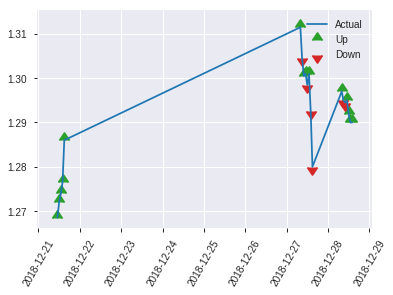


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19698041689853987
RMSE: 0.4438247592220829
LogLoss: 0.5752188279207601
Mean Per-Class Error: 0.2880352097370137
AUC: 0.7620082590741144
pr_auc: 0.6672176049911618
Gini: 0.5240165181482288
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31172916293144226: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      54   53   0.4953   (53.0/107.0)
1      10   76   0.1163   (10.0/86.0)
Total  64   129  0.3264   (63.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.311729     0.706977  128
max f2                       0.222393     0.836653  157
max f0point5                 0.588604     0.666667  60
max accuracy                 0.449826     0.704663  104
max precision                0.857076     1         0
max recall                   0.153507     1         171
max specificity              0.857076     1         0
max absolute_mcc             0.449826     0.423057  104
max min_per_class_accuracy   0.495042     0.674419  87
max mean_per_class_accuracy  0.449826     0.711965  104

Gains/Lift Table: Avg response rate: 44.56 %, avg score: 45.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.83121            2.24419   2.24419            1                0.846791  1                           0.846791            0.0232558       0.0232558                  124.419   124.419
    2        0.0207254                   0.828176           1.12209   1.68314            0.5              0.829674  0.75                        0.838233            0.0116279       0.0348837                  12.2093   68.314
    3        0.0310881                   0.804299           2.24419   1.87016            1                0.824835  0.833333                    0.833767            0.0232558       0.0581395                  124.419   87.0155
    4        0.0414508                   0.788816           1.12209   1.68314            0.5              0.79654   0.75                        0.82446             0.0116279       0.0697674                  12.2093   68.314
    5        0.0518135                   0.781474           1.12209   1.57093            0.5              0.784136  0.7                         0.816395            0.0116279       0.0813953                  12.2093   57.093
    6        0.103627                    0.744881           1.79535   1.68314            0.8              0.761425  0.75                        0.78891             0.0930233       0.174419                   79.5349   68.314
    7        0.150259                    0.718335           1.74548   1.70249            0.777778         0.730502  0.758621                    0.770784            0.0813953       0.255814                   74.5478   70.2486
    8        0.202073                    0.679335           1.34651   1.61121            0.6              0.697215  0.717949                    0.75192             0.0697674       0.325581                   34.6512   61.121
    9        0.300518                    0.600538           1.65361   1.6251             0.736842         0.63378   0.724138                    0.713219            0.162791        0.488372                   65.3611   62.51
    10       0.398964                    0.52679            1.06304   1.48641            0.473684         0.565844  0.662338                    0.676854            0.104651        0.593023                   6.30355   48.6409
    11       0.502591                    0.464817           1.00988   1.38816            0.45             0.496853  0.618557                    0.63974             0.104651        0.697674                   0.988372  38.8156
    12       0.601036                    0.37374            1.06304   1.3349             0.473684         0.434802  0.594828                    0.606173            0.104651        0.802326                   6.30355   33.4904
    13       0.699482                    0.287389           0.826805  1.26339            0.368421         0.327885  0.562963                    0.567006            0.0813953       0.883721                   -17.3195  26.3394
    14       0.797927                    0.230082           0.826805  1.20953            0.368421         0.261346  0.538961                    0.529295            0.0813953       0.965116                   -17.3195  20.9529
    15       0.896373                    0.152316           0.354345  1.11561            0.157895         0.188057  0.49711                     0.491818            0.0348837       1                          -64.5655  11.5607
    16       1                           0.0912548          0         1                  0                0.12328   0.445596                    0.453627            0   

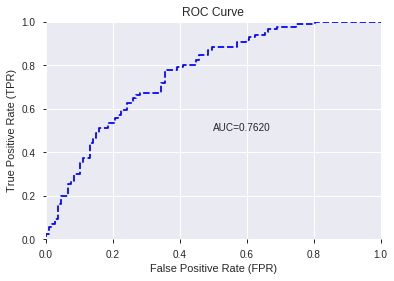

This function is available for GLM models only


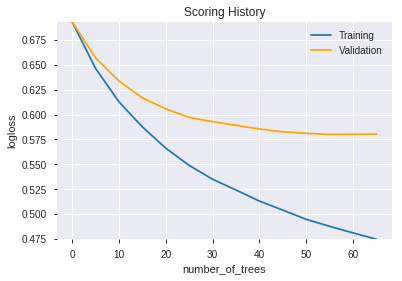

--2019-08-25 13:14:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.18.112
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.18.112|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_131430_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_131430_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a23f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'hour',
 'TRANGE',
 'Volume',
 'SAREXT',
 'STOCHF_fastk',
 'VAR_8',
 'CORREL_8',
 'day',
 'ULTOSC',
 'DIV',
 'WILLR_8',
 'SUB',
 'STOCHRSI_fastk',
 'aroonup_20',
 'CDLCLOSINGMARUBOZU',
 'dayofweek',
 'CDLHAMMER',
 'days_in_month',
 'CDLHANGINGMAN',
 'HT_TRENDMODE',
 'CDLPIERCING',
 'CDLLONGLINE',
 'weekday',
 'CDLDRAGONFLYDOJI',
 'CDLSEPARATINGLINES',
 'CDLADVANCEBLOCK',
 'CDLXSIDEGAP3METHODS',
 'CDLDARKCLOUDCOVER',
 'CDLSHOOTINGSTAR',
 'CDL3INSIDE',
 'CDLMARUBOZU',
 'CDLGRAVESTONEDOJI']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 903] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


31

['hour',
 'BOP',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_131547_model_9  0.794936  0.556531              0.282656  0.436502  0.190534
1  DeepLearning_grid_1_AutoML_20190825_131547_model_4  0.786351  0.615004              0.268529  0.447700  0.200435
2  DeepLearning_grid_1_AutoML_20190825_131547_model_6  0.782656  0.561190              0.288361  0.440371  0.193927
3  DeepLearning_grid_1_AutoML_20190825_131547_model_5  0.780156  0.564217              0.298957  0.437364  0.191288
4  DeepLearning_grid_1_AutoML_20190825_131547_model_8  0.776244  0.568541              0.274343  0.437324  0.191253
5  DeepLearning_grid_1_AutoML_20190825_131547_model_3  0.775266  0.636051              0.269452  0.452110  0.204403
6  DeepLearning_grid_1_AutoML_20190825_131547_model_2  0.774940  0.601054              0.285970  0.447761  0.200490
7  DeepLearning_grid_1_AutoML_20190825_131547_model_7  0.765268  0.626933              0.304771  0.450310  0.202779
8  DeepLearning_grid_1_AutoML_20190825_131547_model_1  0.752391  0.830851              0.292925  0.465442  0.216636
9               DeepLearning_1_AutoML_20190825_131547  0.731580  0.666258              0.316399  0.470281  0.221164

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.072854
1                  BOP             0.823169           0.823169    0.059972
2          CDLLONGLINE             0.789404           0.789404    0.057512
3                 hour             0.758831           0.758831    0.055284
4         CDLSHORTLINE             0.635647           0.635647    0.046310
5          CDLBELTHOLD             0.562238           0.562238    0.040962
6          CDLMARUBOZU             0.556329           0.556329    0.040531
7                  SUB             0.472639           0.472639    0.034434
8               CCI_12             0.459138           0.459138    0.033450
9               TRANGE             0.453681           0.453681    0.033053
10                 DIV             0.441904           0.441904    0.032195
11      STOCHRSI_fastk             0.436675           0.436675    0.031814
12              ULTOSC             0.421303           0.421303    0.030694
13        STOCHF_fastk             0.412354           0.412354    0.030042
14               CCI_8             0.400822           0.400822    0.029202
15      STOCHRSI_fastd             0.391577           0.391577    0.028528
16        CDLENGULFING             0.391487           0.391487    0.028522
17          MINUS_DI_8             0.372463           0.372463    0.027136
18               ADOSC             0.323101           0.323101    0.023539
19            WILLR_20             0.322876           0.322876    0.023523
20            WILLR_24             0.320438           0.320438    0.023345
21             WILLR_8             0.311956           0.311956    0.022727
22            WILLR_12             0.305183           0.305183    0.022234
23            WILLR_30             0.305042           0.305042    0.022224
24            WILLR_14             0.303563           0.303563    0.022116
25              RSI_12             0.302988           0.302988    0.022074
26              RSI_14             0.295436           0.295436    0.021524
27              CMO_12             0.293366           0.293366    0.021373
28              CMO_14             0.292791           0.292791    0.021331
29               CMO_8             0.287272           0.287272    0.020929
30               RSI_8             0.282324           0.282324    0.020569

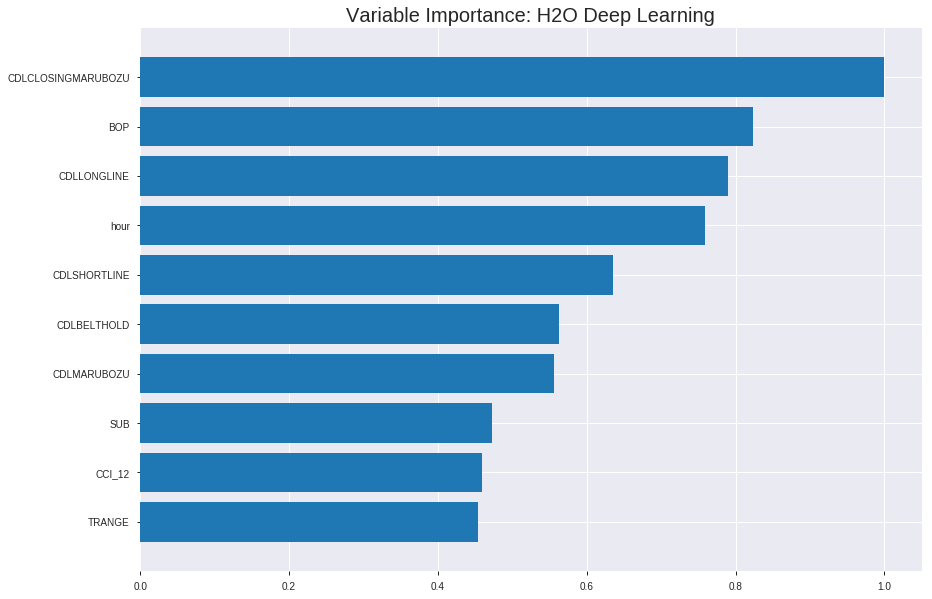

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_131547_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19324247747145193
RMSE: 0.43959353665795853
LogLoss: 0.5671413659644071
Mean Per-Class Error: 0.29155156537753224
AUC: 0.7841596277801389
pr_auc: 0.7531893462009026
Gini: 0.5683192555602778
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3598835992797317: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      395  329  0.4544   (329.0/724.0)
1      94   530  0.1506   (94.0/624.0)
Total  489  859  0.3138   (423.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.359884     0.714767  239
max f2                       0.186101     0.836125  323
max f0point5                 0.482639     0.696023  163
max accuracy                 0.482639     0.712166  163
max precision                0.85612      1         0
max recall                   0.0715968    1         385
max specificity              0.85612      1         0
max absolute_mcc             0.482639     0.418985  163
max min_per_class_accuracy   0.440097     0.708333  190
max mean_per_class_accuracy  0.440097     0.708448  190

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 41.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.820197           2.16026   2.16026            1                0.830321  1                           0.830321            0.0224359       0.0224359                  116.026   116.026
    2        0.0200297                   0.805549           1.99408   2.08025            0.923077         0.811901  0.962963                    0.821452            0.0192308       0.0416667                  99.4083   108.025
    3        0.0304154                   0.76926            1.85165   2.00219            0.857143         0.785638  0.926829                    0.809223            0.0192308       0.0608974                  85.1648   100.219
    4        0.0400593                   0.74661            2.16026   2.04024            1                0.760443  0.944444                    0.797479            0.0208333       0.0817308                  116.026   104.024
    5        0.0504451                   0.723386           1.85165   2.00141            0.857143         0.739732  0.926471                    0.78559             0.0192308       0.100962                   85.1648   100.141
    6        0.100148                    0.654727           1.87007   1.93623            0.865672         0.681261  0.896296                    0.733812            0.0929487       0.19391                    87.0073   93.623
    7        0.150593                    0.628522           1.58842   1.81972            0.735294         0.640701  0.842365                    0.702622            0.0801282       0.274038                   58.8424   81.9723
    8        0.200297                    0.600279           1.48316   1.73621            0.686567         0.614491  0.803704                    0.680753            0.0737179       0.347756                   48.3161   73.6206
    9        0.300445                    0.531832           1.37616   1.61619            0.637037         0.559573  0.748148                    0.64036             0.137821        0.485577                   37.6163   61.6192
    10       0.399852                    0.485133           1.30583   1.53903            0.604478         0.508457  0.71243                     0.607568            0.129808        0.615385                   30.5827   53.9032
    11       0.5                         0.431389           1.05613   1.44231            0.488889         0.457337  0.667656                    0.577477            0.105769        0.721154                   5.61254   44.2308
    12       0.600148                    0.380186           0.92811   1.3565             0.42963          0.406561  0.627936                    0.548956            0.0929487       0.814103                   -7.18898  35.6502
    13       0.699555                    0.298363           0.757702  1.27141            0.350746         0.345833  0.588547                    0.520092            0.0753205       0.889423                   -24.2298  27.1413
    14       0.799703                    0.190073           0.67208   1.19636            0.311111         0.24288   0.553803                    0.485376            0.0673077       0.956731                   -32.792   19.6357
    15       0.899852                    0.128725           0.25603   1.0917             0.118519         0.156214  0.505359                    0.448742            0.025641        0.982372                   -74.397   9.17042
    16       1                           0.0125698          0.176021  1                  0.0814815        0.093626  0.462908                    0.413178          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19523065395996722
RMSE: 0.44184913031482503
LogLoss: 0.5742735960149963
Mean Per-Class Error: 0.2649902765773552
AUC: 0.7726609766637856
pr_auc: 0.713446934072116
Gini: 0.5453219533275713
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30859275759636273: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      113  95   0.4567   (95.0/208.0)
1      20   158  0.1124   (20.0/178.0)
Total  133  253  0.2979   (115.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.308593     0.733179  252
max f2                       0.266014     0.826531  267
max f0point5                 0.458769     0.699566  185
max accuracy                 0.415712     0.73057   207
max precision                0.835948     1         0
max recall                   0.0685274    1         368
max specificity              0.835948     1         0
max absolute_mcc             0.415712     0.470019  207
max min_per_class_accuracy   0.458769     0.724719  185
max mean_per_class_accuracy  0.415712     0.73501   207

Gains/Lift Table: Avg response rate: 46.11 %, avg score: 40.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.819069           2.16854   2.16854            1                0.82672   1                           0.82672             0.0224719       0.0224719                  116.854    116.854
    2        0.0207254                   0.759812           1.6264    1.89747            0.75             0.789229  0.875                       0.807974            0.0168539       0.0393258                  62.6404    89.7472
    3        0.0310881                   0.73838            1.6264    1.80712            0.75             0.751418  0.833333                    0.789122            0.0168539       0.0561798                  62.6404    80.7116
    4        0.0414508                   0.713583           1.08427   1.6264             0.5              0.724808  0.75                        0.773044            0.011236        0.0674157                  8.42697    62.6404
    5        0.0518135                   0.696798           2.16854   1.73483            1                0.703818  0.8                         0.759199            0.0224719       0.0898876                  116.854    73.4831
    6        0.101036                    0.663085           1.94027   1.83492            0.894737         0.674312  0.846154                    0.717844            0.0955056       0.185393                   94.0272    83.4918
    7        0.150259                    0.631738           1.48374   1.71988            0.684211         0.646541  0.793103                    0.694486            0.0730337       0.258427                   48.3737    71.9876
    8        0.202073                    0.610368           1.30112   1.6125             0.6              0.62125   0.74359                     0.675707            0.0674157       0.325843                   30.1124    61.2504
    9        0.300518                    0.548704           1.5408    1.58902            0.710526         0.582508  0.732759                    0.645177            0.151685        0.477528                   54.0804    58.9016
    10       0.401554                    0.495438           1.11207   1.46901            0.512821         0.525481  0.677419                    0.61506             0.11236         0.589888                   11.2071    46.9011
    11       0.5                         0.444178           1.48374   1.47191            0.684211         0.472091  0.678756                    0.58691             0.146067        0.735955                   48.3737    47.191
    12       0.601036                    0.380767           1.00086   1.39273            0.461538         0.410119  0.642241                    0.557191            0.101124        0.837079                   0.0864304  39.2726
    13       0.699482                    0.253606           0.741869  1.30112            0.342105         0.323647  0.6                         0.524322            0.0730337       0.910112                   -25.8131   30.1124
    14       0.800518                    0.150999           0.333621  1.17901            0.153846         0.190764  0.543689                    0.482222            0.0337079       0.94382                    -66.6379   17.9012
    15       0.898964                    0.102471           0.285334  1.08114            0.131579         0.131131  0.498559                    0.443774            0.0280899       0.97191                    -71.4666   8.1145
    16       1                           0.0316841          0.278018  1                  0.128205         0.070198  0.46114                     0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 13:22:42  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 13:22:44  2 min 21.791 sec  514 obs/sec       0.937685  1             1264       0.463055         0.665698            0.137575       0.758938        0.702845           2.00595          0.347181                         0.470493           0.700549              0.109164         0.747299          0.680541             2.16854            0.297927
    2019-08-25 13:22:55  2 min 33.145 sec  797 obs/sec       7.54896   8             10176      0.453155         0.593341            0.174058       0.768134        0.722638           2.00595          0.320475                         0.457194           0.602937              0.158812         0.753916          0.683543             2.16854            0.297927
    2019-08-25 13:23:07  2 min 44.734 sec  874 obs/sec       15.1083   16            20366      0.450784         0.588597            0.182676       0.773454        0.736486           2.00595          0.34273                          0.454103           0.596394              0.17015          0.761128          0.703085             2.16854            0.303109
    2019-08-25 13:23:18  2 min 56.151 sec  983 obs/sec       24.5586   26            33105      0.440434         0.569109            0.219779       0.779008        0.745667           2.16026          0.341988                         0.442835           0.575116              0.210822         0.767043          0.714178             2.16854            0.305699
    2019-08-25 13:23:30  3 min  7.406 sec  1073 obs/sec      34.908    37            47056      0.440731         0.569524            0.218727       0.780465        0.747449           2.16026          0.311573                         0.445486           0.582694              0.201345         0.765206          0.714581             2.16854            0.300518
    2019-08-25 13:23:41  3 min 18.587 sec  1153 obs/sec      46.1803   49            62251      0.439594         0.567141            0.222753       0.78416         0.753189           2.16026          0.313798                         0.441849           0.574274              0.214332         0.772661          0.713447             2.16854            0.297927
    2019-08-25 13:23:51  3 min 29.156 sec  1220 obs/sec      57.4755   61            77477      0.437508         0.563558            0.230111       0.786886        0.755517           2.16026          0.293027                         0.443107           0.57643               0.209852         0.766746          0.70705              2.16854            0.297927
    2019-08-25 13:23:53  3 min 30.241 sec  1219 obs/sec      57.4755   61            77477      0.439594         0.567141            0.222753       0.78416         0.753189           2.16026          0.313798                         0.441849           0.574274              0.214332         0.772661          0.713447             2.16854            0.297927

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.07285446145367927
BOP                 0.8231691718101501     0.8231691718101501   0.05997154669749967
CDLLONGLINE         0.7894039154052734     0.7894039154052734   0.05751159712627698
hour                0.7588310837745667     0.7588310837745667   0.055284229942707826
CDLSHORTLINE        0.6356465220451355     0.6356465220451355   0.046309685038502614
---                 ---                    ---                  ---
RSI_14              0.2954356372356415     0.2954356372356415   0.021523804245027214
CMO_12              0.29336586594581604    0.29336586594581604  0.021373012172374695
CMO_14              0.2927914559841156     0.2927914559841156   0.02133116384396138
CMO_8               0.28727200627326965    0.28727200627326965  0.02092904730775703
RSI_8               0.2823236584663391     0.2823236584663391   0.020568538093197614


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7253886010362695)

('F1', 0.7368421052631579)

('auc', 0.7949358835035862)

('logloss', 0.5565310392962289)

('mean_per_class_error', 0.26934362095196696)

('rmse', 0.4365023164240821)

('mse', 0.19053427224358951)

deeplearning prediction progress: |███████████████████████████████████████| 100%


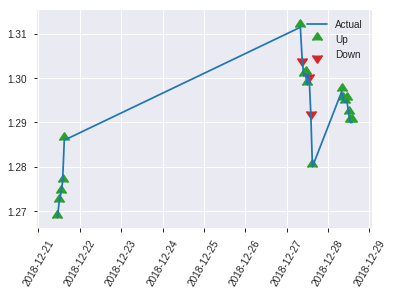


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19053427224358951
RMSE: 0.4365023164240821
LogLoss: 0.5565310392962289
Mean Per-Class Error: 0.26934362095196696
AUC: 0.7949358835035862
pr_auc: 0.6969712025112681
Gini: 0.5898717670071725
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1973030434139951: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      49   58   0.5421   (58.0/107.0)
1      2    84   0.0233   (2.0/86.0)
Total  51   142  0.3109   (60.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.197303     0.736842  141
max f2                       0.197303     0.864198  141
max f0point5                 0.484547     0.702703  70
max accuracy                 0.484547     0.725389  70
max precision                0.821482     1         0
max recall                   0.125006     1         167
max specificity              0.821482     1         0
max absolute_mcc             0.197303     0.489993  141
max min_per_class_accuracy   0.425662     0.71028   92
max mean_per_class_accuracy  0.405594     0.730656  100

Gains/Lift Table: Avg response rate: 44.56 %, avg score: 38.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.818027           2.24419   2.24419            1                0.820957  1                           0.820957            0.0232558       0.0232558                  124.419   124.419
    2        0.0207254                   0.772096           1.12209   1.68314            0.5              0.817676  0.75                        0.819316            0.0116279       0.0348837                  12.2093   68.314
    3        0.0310881                   0.746365           2.24419   1.87016            1                0.759563  0.833333                    0.799398            0.0232558       0.0581395                  124.419   87.0155
    4        0.0414508                   0.737712           1.12209   1.68314            0.5              0.742642  0.75                        0.785209            0.0116279       0.0697674                  12.2093   68.314
    5        0.0518135                   0.69737            2.24419   1.79535            1                0.729396  0.8                         0.774047            0.0232558       0.0930233                  124.419   79.5349
    6        0.103627                    0.646793           1.57093   1.68314            0.7              0.662005  0.75                        0.718026            0.0813953       0.174419                   57.093    68.314
    7        0.150259                    0.612397           1.49612   1.6251             0.666667         0.63438   0.724138                    0.692067            0.0697674       0.244186                   49.6124   62.51
    8        0.202073                    0.57949            1.79535   1.66875            0.8              0.599296  0.74359                     0.668279            0.0930233       0.337209                   79.5349   66.8754
    9        0.300518                    0.510908           1.77173   1.70249            0.789474         0.541517  0.758621                    0.626754            0.174419        0.511628                   77.1726   70.2486
    10       0.398964                    0.462166           1.18115   1.57384            0.526316         0.488447  0.701299                    0.592626            0.116279        0.627907                   18.1151   57.3845
    11       0.502591                    0.421402           1.12209   1.4807             0.5              0.434235  0.659794                    0.559968            0.116279        0.744186                   12.2093   48.07
    12       0.601036                    0.326387           0.94492   1.39294            0.421053         0.378849  0.62069                     0.530302            0.0930233       0.837209                   -5.50796  39.2943
    13       0.699482                    0.231987           0.826805  1.31326            0.368421         0.287516  0.585185                    0.496132            0.0813953       0.918605                   -17.3195  31.3264
    14       0.797927                    0.153382           0.590575  1.2241             0.263158         0.191454  0.545455                    0.458542            0.0581395       0.976744                   -40.9425  22.4101
    15       0.896373                    0.107443           0.23623   1.11561            0.105263         0.132083  0.49711                     0.422688            0.0232558       1                          -76.377   11.5607
    16       1                           0.0473401          0         1                  0                0.088807  0.445596                    0.388089            0   

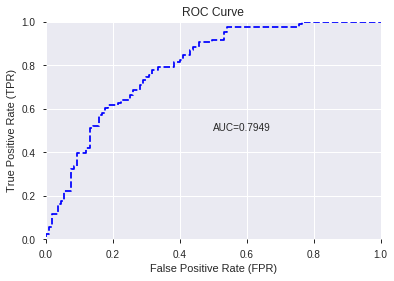

This function is available for GLM models only


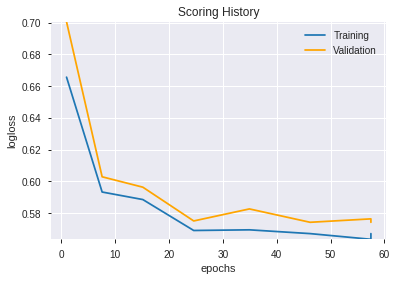

--2019-08-25 13:24:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.101.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.101.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_131547_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_131547_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a23f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLLONGLINE',
 'hour',
 'CDLSHORTLINE',
 'CDLBELTHOLD',
 'CDLMARUBOZU',
 'SUB',
 'CCI_12',
 'TRANGE',
 'DIV',
 'STOCHRSI_fastk',
 'ULTOSC',
 'STOCHF_fastk',
 'CCI_8',
 'STOCHRSI_fastd',
 'CDLENGULFING',
 'MINUS_DI_8',
 'ADOSC',
 'WILLR_20',
 'WILLR_24',
 'WILLR_8',
 'WILLR_12',
 'WILLR_30',
 'WILLR_14',
 'RSI_12',
 'RSI_14',
 'CMO_12',
 'CMO_14',
 'CMO_8',
 'RSI_8']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190825_132459_model_1  0.774288  0.564201              0.325853  0.43875  0.192501

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.632407           1.000000    0.159934
1   CDLCLOSINGMARUBOZU             0.342789           0.542039    0.086691
2               CCI_12             0.340312           0.538122    0.086064
3                  SUB             0.272936           0.431583    0.069025
4                 hour             0.240530           0.380341    0.060830
5               ULTOSC             0.206598           0.326686    0.052248
6       STOCHRSI_fastk             0.202385           0.320024    0.051183
7           MINUS_DI_8             0.181921           0.287664    0.046007
8             WILLR_30             0.175140           0.276943    0.044293
9              WILLR_8             0.172947           0.273475    0.043738
10      STOCHRSI_fastd             0.141742           0.224131    0.035846
11              RSI_14             0.115496           0.182629    0.029209
12              CMO_14             0.113311           0.179175    0.028656
13        STOCHF_fastk             0.097688           0.154471    0.024705
14            WILLR_24             0.089151           0.140970    0.022546
15         CDLLONGLINE             0.074909           0.118451    0.018944
16               CCI_8             0.074491           0.117790    0.018839
17            WILLR_20             0.071171           0.112539    0.017999
18              CMO_12             0.068774           0.108749    0.017393
19              RSI_12             0.065233           0.103150    0.016497
20               CMO_8             0.045465           0.071893    0.011498
21               RSI_8             0.044673           0.070639    0.011298
22              TRANGE             0.035413           0.055997    0.008956
23         CDLMARUBOZU             0.029759           0.047056    0.007526
24            WILLR_12             0.028017           0.044303    0.007086
25               ADOSC             0.027545           0.043557    0.006966
26        CDLENGULFING             0.025764           0.040740    0.006516
27        CDLSHORTLINE             0.014389           0.022754    0.003639
28         CDLBELTHOLD             0.013526           0.021389    0.003421
29            WILLR_14             0.006933           0.010962    0.001753
30                 DIV             0.002750           0.004349    0.000696

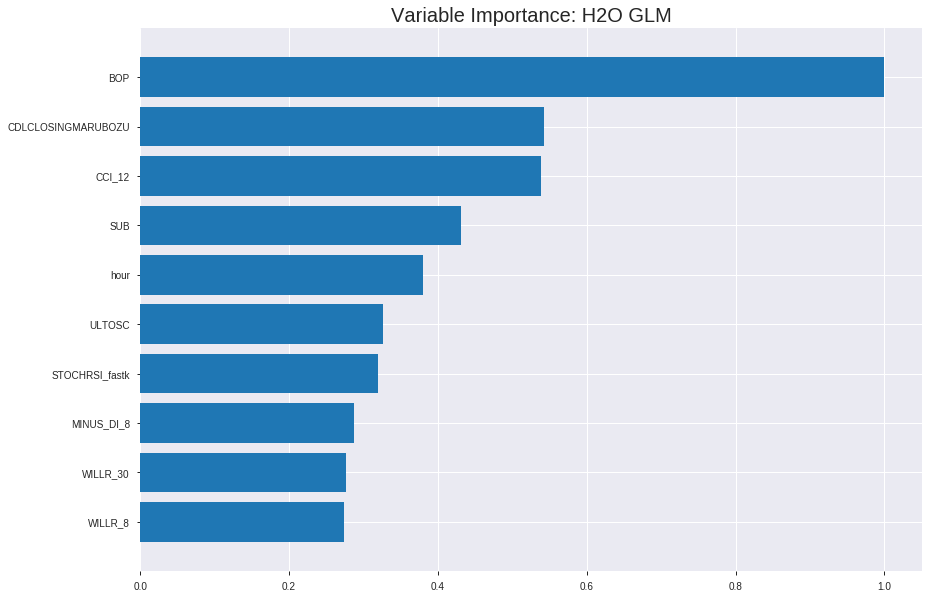

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_132459_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1927248034016642
RMSE: 0.4390043318711835
LogLoss: 0.565868245682711
Null degrees of freedom: 1347
Residual degrees of freedom: 1316
Null deviance: 1861.2995819096327
Residual deviance: 1525.5807903605883
AIC: 1589.5807903605883
AUC: 0.7747589513387164
pr_auc: 0.7275428237785352
Gini: 0.5495179026774328
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3544546189252479: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      380  344  0.4751   (344.0/724.0)
1      86   538  0.1378   (86.0/624.0)
Total  466  882  0.319    (430.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.354455     0.714475  253
max f2                       0.23364      0.832178  314
max f0point5                 0.555217     0.68769   154
max accuracy                 0.470312     0.707715  193
max precision                0.949266     1         0
max recall                   0.0757166    1         378
max specificity              0.949266     1         0
max absolute_mcc             0.466437     0.416144  195
max min_per_class_accuracy   0.472662     0.705801  192
max mean_per_class_accuracy  0.466437     0.708643  195

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 46.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.919978           1.69734   1.69734            0.785714         0.933582   0.785714                    0.933582            0.0176282       0.0176282                  69.7344   69.7344
    2        0.0200297                   0.900976           2.16026   1.92023            1                0.910976   0.888889                    0.922698            0.0208333       0.0384615                  116.026   92.0228
    3        0.0304154                   0.881299           2.00595   1.9495             0.928571         0.891235   0.902439                    0.911954            0.0208333       0.0592949                  100.595   94.95
    4        0.0400593                   0.855061           1.99408   1.96023            0.923077         0.867556   0.907407                    0.901266            0.0192308       0.0785256                  99.4083   96.0233
    5        0.0504451                   0.84244            2.00595   1.96965            0.928571         0.848863   0.911765                    0.890477            0.0208333       0.099359                   100.595   96.9646
    6        0.100148                    0.770111           1.7411    1.85622            0.80597          0.803627   0.859259                    0.847374            0.0865385       0.185897                   74.1102   85.622
    7        0.150593                    0.716223           1.42958   1.71331            0.661765         0.742116   0.793103                    0.812115            0.0721154       0.258013                   42.9581   71.3307
    8        0.200297                    0.671599           1.57989   1.6802             0.731343         0.692703   0.777778                    0.782483            0.0785256       0.336538                   57.9889   68.0199
    9        0.300445                    0.600069           1.42417   1.59486            0.659259         0.633804   0.738272                    0.732923            0.142628        0.479167                   42.4169   59.4856
    10       0.399852                    0.529644           1.22522   1.50296            0.567164         0.568111   0.695733                    0.69195             0.121795        0.600962                   22.522    50.2961
    11       0.5                         0.46265            1.23215   1.44872            0.57037          0.498005   0.670623                    0.653103            0.123397        0.724359                   23.2146   44.8718
    12       0.600148                    0.392018           0.944112  1.36451            0.437037         0.424308   0.631644                    0.614923            0.0945513       0.81891                    -5.58879  36.4513
    13       0.699555                    0.324387           0.725459  1.2737             0.335821         0.357657   0.589608                    0.578366            0.0721154       0.891026                   -27.4541  27.3704
    14       0.799703                    0.2538             0.544065  1.18233            0.251852         0.291557   0.54731                     0.542448            0.0544872       0.945513                   -45.5935  18.233
    15       0.899852                    0.143671           0.368044  1.0917             0.17037          0.20471    0.505359                    0.50486             0.036859        0.982372                   -63.1956  9.17042
    16       1                           0.00675058         0.176021  1                  0.0814815        0.0859612  0.462908                    0.4



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20048170151939199
RMSE: 0.4477518302803373
LogLoss: 0.5838920345405965
Null degrees of freedom: 385
Residual degrees of freedom: 354
Null deviance: 532.7805186446055
Residual deviance: 450.76465066534047
AIC: 514.7646506653405
AUC: 0.752998055315471
pr_auc: 0.6771578264046344
Gini: 0.5059961106309421
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38862358149050885: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      122  86   0.4135   (86.0/208.0)
1      28   150  0.1573   (28.0/178.0)
Total  150  236  0.2953   (114.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388624     0.724638  235
max f2                       0.197875     0.832527  320
max f0point5                 0.46613      0.684713  190
max accuracy                 0.46613      0.712435  190
max precision                0.937826     1         0
max recall                   0.0718199    1         366
max specificity              0.937826     1         0
max absolute_mcc             0.388624     0.43897   235
max min_per_class_accuracy   0.469063     0.706731  186
max mean_per_class_accuracy  0.414357     0.714996  224

Gains/Lift Table: Avg response rate: 46.11 %, avg score: 45.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.891549           2.16854   2.16854            1                0.918237   1                           0.918237            0.0224719       0.0224719                  116.854    116.854
    2        0.0207254                   0.867188           1.08427   1.6264             0.5              0.877863   0.75                        0.89805             0.011236        0.0337079                  8.42697    62.6404
    3        0.0310881                   0.856686           1.6264    1.6264             0.75             0.863129   0.75                        0.88641             0.0168539       0.0505618                  62.6404    62.6404
    4        0.0414508                   0.825493           1.6264    1.6264             0.75             0.835852   0.75                        0.87377             0.0168539       0.0674157                  62.6404    62.6404
    5        0.0518135                   0.791056           2.16854   1.73483            1                0.807839   0.8                         0.860584            0.0224719       0.0898876                  116.854    73.4831
    6        0.101036                    0.735417           1.712     1.72371            0.789474         0.758268   0.794872                    0.810738            0.0842697       0.174157                   71.2005    72.3711
    7        0.150259                    0.701552           1.0272    1.49554            0.473684         0.715519   0.689655                    0.779545            0.0505618       0.224719                   2.72028    49.5544
    8        0.202073                    0.655183           1.40955   1.47349            0.65             0.678497   0.679487                    0.753635            0.0730337       0.297753                   40.9551    47.3495
    9        0.300518                    0.600164           1.5408    1.49554            0.710526         0.630142   0.689655                    0.713181            0.151685        0.449438                   54.0804    49.5544
    10       0.401554                    0.530215           1.33449   1.45502            0.615385         0.565021   0.670968                    0.675902            0.134831        0.58427                    33.4486    45.502
    11       0.5                         0.464825           1.42667   1.44944            0.657895         0.497022   0.668394                    0.640682            0.140449        0.724719                   42.6671    44.9438
    12       0.601036                    0.399139           1.00086   1.37403            0.461538         0.433669   0.633621                    0.605883            0.101124        0.825843                   0.0864304  37.4031
    13       0.699482                    0.303179           0.627735  1.269              0.289474         0.354866   0.585185                    0.570554            0.0617978       0.88764                    -37.2265   26.8997
    14       0.800518                    0.223192           0.444829  1.16498            0.205128         0.26317    0.537217                    0.531758            0.0449438       0.932584                   -55.5171   16.4976
    15       0.898964                    0.124338           0.456535  1.08739            0.210526         0.177158   0.501441                    0.492926            0.0449438       0.977528                   -54.3465   8.73944
    16       1                           0.0194352          0.222414  1                  0.102564         0.0723705  0.46114    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-25 13:25:00  0.000 sec   2            .21E2     32            1.359327438137845   1.3596721849834454
     2019-08-25 13:25:00  0.009 sec   4            .13E2     32            1.3490810871511656  1.349896015638632
     2019-08-25 13:25:00  0.019 sec   6            .8E1      32            1.3354483831517483  1.336934888978733
     2019-08-25 13:25:00  0.029 sec   8            .49E1     32            1.3183580317422343  1.3207154039116773
     2019-08-25 13:25:00  0.037 sec   10           .31E1     32            1.2980035275930826  1.3014313108366875
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-25 13:25:00  0.112 sec   36           .63E-2    32            1.1300315068078162  1.1686377928607583
     2019-08-25 13:25:00  0.118 sec   38           .39E-2    32            1.12882960657034    1.1705112610785693
     2019-08-25 13:25:00  0.126 sec   40           .24E-2    32            1.1280209432533461  1.1733112314748073
     2019-08-25 13:25:00  0.130 sec   41           .15E-2    32            1.1275070946437253  1.1769847781320368
     2019-08-25 13:25:00  0.133 sec   42           .93E-3    32            1.1272148170109022  1.1810047923025142


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7253886010362695)

('F1', 0.7063829787234044)

('auc', 0.7742881982177788)

('logloss', 0.5642010517339718)

('mean_per_class_error', 0.2796131275809607)

('rmse', 0.43874971048694505)

('mse', 0.19250130845237812)

glm prediction progress: |████████████████████████████████████████████████| 100%


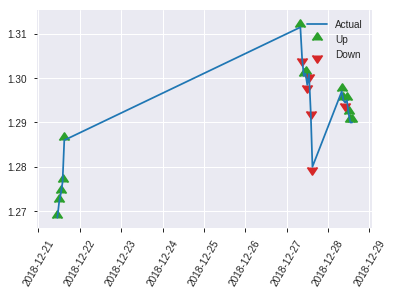


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19250130845237812
RMSE: 0.43874971048694505
LogLoss: 0.5642010517339718
Null degrees of freedom: 192
Residual degrees of freedom: 161
Null deviance: 265.4984131782047
Residual deviance: 217.78160596931315
AIC: 281.78160596931315
AUC: 0.7742881982177788
pr_auc: 0.6874336613999837
Gini: 0.5485763964355577
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25203410547078087: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      41   66   0.6168   (66.0/107.0)
1      3    83   0.0349   (3.0/86.0)
Total  44   149  0.3575   (69.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.252034     0.706383  148
max f2                       0.227226     0.843373  153
max f0point5                 0.564089     0.701058  72
max accuracy                 0.564089     0.725389  72
max precision                0.939378     1         0
max recall                   0.167701     1         169
max specificity              0.939378     1         0
max absolute_mcc             0.505327     0.442508  82
max min_per_class_accuracy   0.489745     0.697674  88
max mean_per_class_accuracy  0.505327     0.720387  82

Gains/Lift Table: Avg response rate: 44.56 %, avg score: 45.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.911732           2.24419   2.24419            1                0.925838  1                           0.925838            0.0232558       0.0232558                  124.419   124.419
    2        0.0207254                   0.88373            2.24419   2.24419            1                0.901007  1                           0.913423            0.0232558       0.0465116                  124.419   124.419
    3        0.0310881                   0.869531           1.12209   1.87016            0.5              0.876423  0.833333                    0.901089            0.0116279       0.0581395                  12.2093   87.0155
    4        0.0414508                   0.827528           1.12209   1.68314            0.5              0.861727  0.75                        0.891249            0.0116279       0.0697674                  12.2093   68.314
    5        0.0518135                   0.799199           2.24419   1.79535            1                0.813262  0.8                         0.875651            0.0232558       0.0930233                  124.419   79.5349
    6        0.103627                    0.757914           1.57093   1.68314            0.7              0.774792  0.75                        0.825222            0.0813953       0.174419                   57.093    68.314
    7        0.150259                    0.693438           1.49612   1.6251             0.666667         0.726843  0.724138                    0.79469             0.0697674       0.244186                   49.6124   62.51
    8        0.202073                    0.667928           1.34651   1.55367            0.6              0.681496  0.692308                    0.765666            0.0697674       0.313953                   34.6512   55.3667
    9        0.300518                    0.602708           1.77173   1.6251             0.789474         0.638607  0.724138                    0.724043            0.174419        0.488372                   77.1726   62.51
    10       0.398964                    0.543655           1.41738   1.57384            0.631579         0.580752  0.701299                    0.688686            0.139535        0.627907                   41.7381   57.3845
    11       0.502591                    0.461277           0.897674  1.43443            0.4              0.496532  0.639175                    0.649067            0.0930233       0.72093                    -10.2326  43.4428
    12       0.601036                    0.379206           0.94492   1.35425            0.421053         0.429211  0.603448                    0.613056            0.0930233       0.813953                   -5.50796  35.425
    13       0.699482                    0.292609           0.826805  1.28002            0.368421         0.324236  0.57037                     0.572407            0.0813953       0.895349                   -17.3195  28.0017
    14       0.797927                    0.223426           0.826805  1.2241             0.368421         0.263658  0.545455                    0.534315            0.0813953       0.976744                   -17.3195  22.4101
    15       0.896373                    0.138985           0.23623   1.11561            0.105263         0.19212   0.49711                     0.496733            0.0232558       1                          -76.377   11.5607
    16       1                           0.0468469          0         1                  0                0.100078  0.445596                    0.455628            0   

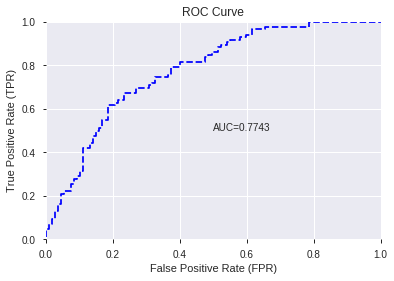

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


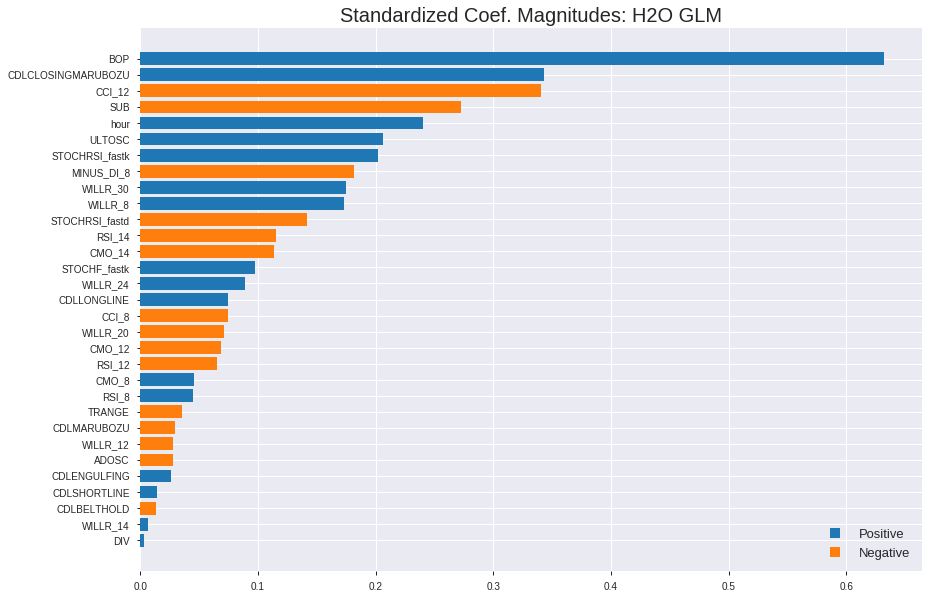

'log_likelihood'
--2019-08-25 13:25:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_132459_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_132459_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a23f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CCI_12',
 'SUB',
 'hour',
 'ULTOSC',
 'STOCHRSI_fastk',
 'MINUS_DI_8',
 'WILLR_30',
 'WILLR_8',
 'STOCHRSI_fastd',
 'RSI_14',
 'CMO_14',
 'STOCHF_fastk',
 'WILLR_24',
 'CDLLONGLINE',
 'CCI_8',
 'WILLR_20',
 'CMO_12',
 'RSI_12',
 'CMO_8',
 'RSI_8',
 'TRANGE',
 'CDLMARUBOZU',
 'WILLR_12',
 'ADOSC',
 'CDLENGULFING',
 'CDLSHORTLINE',
 'CDLBELTHOLD',
 'WILLR_14',
 'DIV']

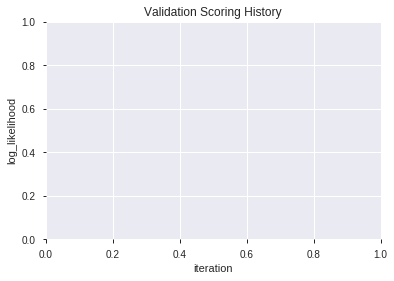

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_132605_model_1  0.785373  0.555697              0.249511  0.433697  0.188093
1               XGBoost_1_AutoML_20190825_132605  0.782873  0.560069              0.241198  0.435155  0.189359
2  XGBoost_grid_1_AutoML_20190825_132605_model_7  0.782221  0.558779              0.266029  0.434685  0.188951
3  XGBoost_grid_1_AutoML_20190825_132605_model_2  0.781678  0.560404              0.261248  0.435893  0.190002
4  XGBoost_grid_1_AutoML_20190825_132605_model_5  0.777114  0.572614              0.251902  0.439174  0.192874
5  XGBoost_grid_1_AutoML_20190825_132605_model_6  0.777005  0.565286              0.270702  0.439180  0.192879
6               XGBoost_3_AutoML_20190825_132605  0.772332  0.565494              0.281298  0.439526  0.193183
7  XGBoost_grid_1_AutoML_20190825_132605_model_3  0.772006  0.570413              0.268203  0.440470  0.194013
8               XGBoost_2_AutoML_20190825_132605  0.768637  0.568246              0.263530  0.439069  0.192782
9  XGBoost_grid_1_AutoML_20190825_132605_model_4  0.762226  0.576759              0.276407  0.444490  0.197571

variable  relative_importance  scaled_importance  percentage
0                  BOP          2471.285400           1.000000    0.358008
1         STOCHF_fastk           502.021118           0.203142    0.072726
2                 hour           476.031799           0.192625    0.068961
3               TRANGE           370.526306           0.149933    0.053677
4       STOCHRSI_fastk           307.181183           0.124300    0.044500
5               CCI_12           301.381165           0.121953    0.043660
6   CDLCLOSINGMARUBOZU           232.866241           0.094229    0.033735
7       STOCHRSI_fastd           225.755981           0.091352    0.032705
8           MINUS_DI_8           217.074997           0.087839    0.031447
9                  SUB           216.083679           0.087438    0.031303
10                 DIV           209.968613           0.084963    0.030418
11            WILLR_20           175.963165           0.071203    0.025491
12              ULTOSC           164.492020           0.066561    0.023830
13               CCI_8           140.960800           0.057039    0.020421
14            WILLR_30           139.865128           0.056596    0.020262
15               ADOSC           125.461037           0.050768    0.018175
16             WILLR_8           109.267471           0.044215    0.015829
17            WILLR_14            91.438736           0.037000    0.013246
18              CMO_12            85.921005           0.034768    0.012447
19               CMO_8            84.361855           0.034137    0.012221
20            WILLR_12            84.225952           0.034082    0.012202
21              CMO_14            44.913780           0.018174    0.006507
22            WILLR_24            36.250282           0.014669    0.005251
23        CDLSHORTLINE            28.165041           0.011397    0.004080
24         CDLLONGLINE            21.928329           0.008873    0.003177
25              RSI_12            15.167482           0.006137    0.002197
26               RSI_8            13.703921           0.005545    0.001985
27              RSI_14            10.609312           0.004293    0.001537

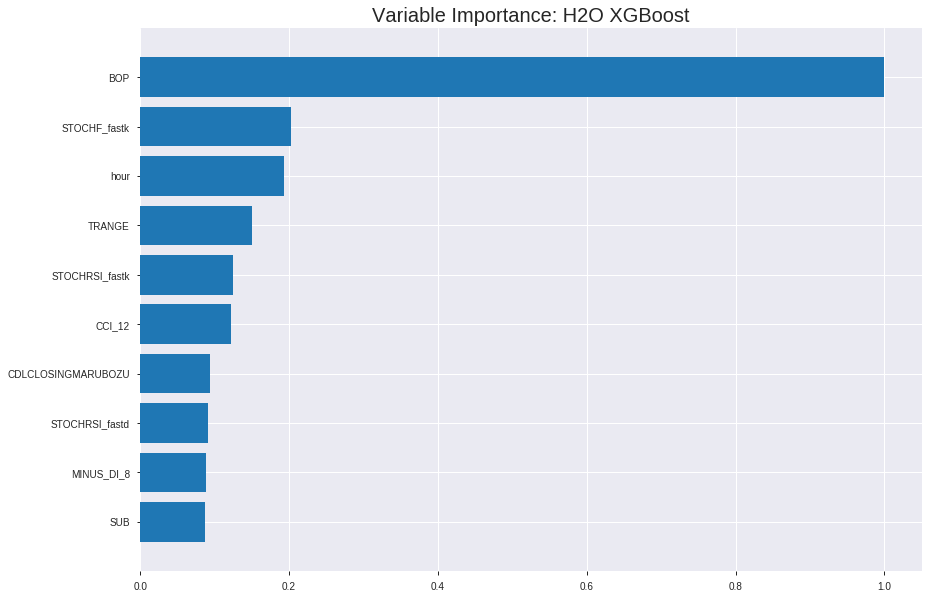

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_132605_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13921577320394604
RMSE: 0.37311629983685524
LogLoss: 0.44107048830623435
Mean Per-Class Error: 0.1736125867686641
AUC: 0.9105386297634225
pr_auc: 0.8954091269766894
Gini: 0.821077259526845
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4382835865020752: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      543  181  0.25     (181.0/724.0)
1      63   561  0.101    (63.0/624.0)
Total  606  742  0.181    (244.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438284     0.821376  215
max f2                       0.315802     0.884146  272
max f0point5                 0.560274     0.836438  159
max accuracy                 0.506631     0.827893  182
max precision                0.94112      1         0
max recall                   0.170081     1         337
max specificity              0.94112      1         0
max absolute_mcc             0.506631     0.653571  182
max min_per_class_accuracy   0.495037     0.822115  189
max mean_per_class_accuracy  0.506631     0.826387  182

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 46.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.915789           2.16026   2.16026            1                0.930039   1                           0.930039            0.0224359       0.0224359                  116.026   116.026
    2        0.0200297                   0.900961           2.16026   2.16026            1                0.908263   1                           0.919554            0.0208333       0.0432692                  116.026   116.026
    3        0.0304154                   0.888729           2.16026   2.16026            1                0.894964   1                           0.911158            0.0224359       0.0657051                  116.026   116.026
    4        0.0400593                   0.878387           2.16026   2.16026            1                0.883603   1                           0.904524            0.0208333       0.0865385                  116.026   116.026
    5        0.0504451                   0.861255           2.16026   2.16026            1                0.867458   1                           0.896893            0.0224359       0.108974                   116.026   116.026
    6        0.100148                    0.794923           2.06353   2.11225            0.955224         0.822667   0.977778                    0.860055            0.102564        0.211538                   106.353   111.225
    7        0.150593                    0.737533           1.96965   2.06448            0.911765         0.767309   0.955665                    0.828987            0.099359        0.310897                   96.9646   106.448
    8        0.200297                    0.677307           1.99904   2.04824            0.925373         0.704951   0.948148                    0.798208            0.099359        0.410256                   99.9043   104.824
    9        0.300445                    0.606434           1.74421   1.9469             0.807407         0.638235   0.901235                    0.744884            0.174679        0.584936                   74.4207   94.6898
    10       0.399852                    0.548163           1.56377   1.85165            0.723881         0.576542   0.857143                    0.703032            0.155449        0.740385                   56.3768   85.1648
    11       0.5                         0.475423           1.04012   1.6891             0.481481         0.511565   0.781899                    0.664682            0.104167        0.844551                   4.01235   68.9103
    12       0.600148                    0.4016             0.880104  1.5541             0.407407         0.436466   0.719407                    0.626599            0.088141        0.932692                   -11.9896  55.4103
    13       0.699555                    0.315749           0.419154  1.39283            0.19403          0.359273   0.644751                    0.588612            0.0416667       0.974359                   -58.0846  39.2827
    14       0.799703                    0.228302           0.144017  1.23644            0.0666667        0.26999    0.572356                    0.548711            0.0144231       0.988782                   -85.5983  23.6436
    15       0.899852                    0.127445           0.112013  1.11129            0.0518519        0.176971   0.514427                    0.507338            0.0112179       1                          -88.7987  11.1294
    16       1                           0.0323392          0         1                  0                0.0779671  0.462908                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19460875271818062
RMSE: 0.4411448205727691
LogLoss: 0.5709180700127906
Mean Per-Class Error: 0.27814390665514255
AUC: 0.7651523336214348
pr_auc: 0.7211534631702924
Gini: 0.5303046672428695
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35238930583000183: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      118  90   0.4327   (90.0/208.0)
1      22   156  0.1236   (22.0/178.0)
Total  140  246  0.2902   (112.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.352389     0.735849  245
max f2                       0.195292     0.832522  314
max f0point5                 0.409962     0.673258  220
max accuracy                 0.372368     0.709845  237
max precision                0.945687     1         0
max recall                   0.0370877    1         381
max specificity              0.945687     1         0
max absolute_mcc             0.352389     0.460057  245
max min_per_class_accuracy   0.482688     0.685393  186
max mean_per_class_accuracy  0.352389     0.721856  245

Gains/Lift Table: Avg response rate: 46.11 %, avg score: 45.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.905822           2.16854   2.16854            1                0.924831   1                           0.924831            0.0224719       0.0224719                  116.854   116.854
    2        0.0207254                   0.895298           2.16854   2.16854            1                0.900532   1                           0.912682            0.0224719       0.0449438                  116.854   116.854
    3        0.0310881                   0.865376           1.6264    1.98783            0.75             0.883836   0.916667                    0.903066            0.0168539       0.0617978                  62.6404   98.7828
    4        0.0414508                   0.847428           1.6264    1.89747            0.75             0.853162   0.875                       0.89059             0.0168539       0.0786517                  62.6404   89.7472
    5        0.0518135                   0.838997           2.16854   1.95169            1                0.841221   0.9                         0.880716            0.0224719       0.101124                   116.854   95.1685
    6        0.101036                    0.760796           1.82614   1.89052            0.842105         0.796856   0.871795                    0.839861            0.0898876       0.191011                   82.6138   89.0521
    7        0.150259                    0.699118           1.712     1.83204            0.789474         0.728822   0.844828                    0.803486            0.0842697       0.275281                   71.2005   83.2042
    8        0.202073                    0.66467            1.1927    1.66811            0.55             0.680244   0.769231                    0.771886            0.0617978       0.337079                   19.2697   66.8107
    9        0.300518                    0.605088           1.08427   1.47685            0.5              0.632057   0.681034                    0.72608             0.106742        0.44382                    8.42697   47.685
    10       0.401554                    0.545868           1.44569   1.46901            0.666667         0.575879   0.677419                    0.688287            0.146067        0.589888                   44.5693   46.9011
    11       0.5                         0.471334           1.08427   1.39326            0.5              0.50949    0.642487                    0.653084            0.106742        0.696629                   8.42697   39.3258
    12       0.601036                    0.3843             1.27888   1.37403            0.589744         0.429653   0.633621                    0.615524            0.129213        0.825843                   27.8882   37.4031
    13       0.699482                    0.316002           0.798936  1.29309            0.368421         0.346319   0.596296                    0.577636            0.0786517       0.904494                   -20.1064  29.3092
    14       0.800518                    0.214288           0.444829  1.18603            0.205128         0.269465   0.546926                    0.538741            0.0449438       0.949438                   -55.5171  18.603
    15       0.898964                    0.108328           0.285334  1.08739            0.131579         0.164482   0.501441                    0.497756            0.0280899       0.977528                   -71.4666  8.73944
    16       1                           0.0318443          0.222414  1                  0.102564         0.0677794  0.46114                     0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 13:26:09  0.010 sec   0                  0.5              0.693147            0.5             0                  1                0.537092                         0.5                0.693147              0.5               0                    1                  0.53886
    2019-08-25 13:26:09  0.054 sec   5                  0.470001         0.634493            0.835829        0.805259           2.16026          0.258902                         0.480005           0.653648              0.736104          0.697537             2.16854            0.354922
    2019-08-25 13:26:09  0.090 sec   10                 0.44789          0.591942            0.850337        0.822271           2.16026          0.25816                          0.467637           0.628909              0.737373          0.697287             2.16854            0.313472
    2019-08-25 13:26:09  0.135 sec   15                 0.431939         0.560803            0.85946         0.831817           2.16026          0.243323                         0.45782            0.608518              0.750432          0.705379             2.16854            0.34456
    2019-08-25 13:26:09  0.177 sec   20                 0.418059         0.533586            0.8714          0.84723            2.16026          0.230712                         0.452446           0.59671               0.753633          0.706369             2.16854            0.305699
    2019-08-25 13:26:09  0.214 sec   25                 0.408084         0.513345            0.877902        0.855882           2.16026          0.212908                         0.447668           0.586028              0.758008          0.710446             2.16854            0.30829
    2019-08-25 13:26:09  0.252 sec   30                 0.400322         0.497322            0.883947        0.863519           2.16026          0.221068                         0.444961           0.579657              0.762019          0.717469             2.16854            0.305699
    2019-08-25 13:26:09  0.288 sec   35                 0.395099         0.486204            0.887155        0.866907           2.16026          0.21365                          0.443341           0.575596              0.762208          0.717694             2.16854            0.310881
    2019-08-25 13:26:09  0.325 sec   40                 0.390323         0.475916            0.891299        0.873203           2.16026          0.212166                         0.442472           0.573361              0.763802          0.719815             2.16854            0.30829
    2019-08-25 13:26:09  0.370 sec   45                 0.386004         0.466673            0.895424        0.877256           2.16026          0.203264                         0.44155            0.571366              0.76553           0.720776             2.16854            0.292746
    2019-08-25 13:26:10  0.405 sec   50                 0.382853         0.460057            0.898596        0.880478           2.16026          0.200297                         0.44173            0.571542              0.764288          0.720523             2.16854            0.300518
    2019-08-25 13:26:10  0.444 sec   55                 0.379715         0.453737            0.902103        0.886255           2.16026          0.188427                         0.441066           0.570071              0.765233          0.723

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             2471.285400390625      1.0                    0.3580083002902221
STOCHF_fastk    502.0211181640625      0.20314170030086784    0.07272641484277939
hour            476.03179931640625     0.19262518171359813    0.06896141389838044
TRANGE          370.52630615234375     0.14993262457414927    0.05367712408184317
STOCHRSI_fastk  307.1811828613281      0.124300164931486      0.04450049077291558
---             ---                    ---                    ---
CDLSHORTLINE    28.165040969848633     0.01139691958095844    0.004080191807723282
CDLLONGLINE     21.928329467773438     0.008873248498254117   0.0031766966129127224
RSI_12          15.167482376098633     0.0061374871448280225  0.0021972713407729686
RSI_8           13.7039213180542       0.005545260501230688   0.001985249286712104
RSI_14          10.609312057495117     0.004293033923082357   0.0015369417778909786


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7564766839378239)

('F1', 0.735135135135135)

('auc', 0.7853727450554228)

('logloss', 0.5556969813733126)

('mean_per_class_error', 0.24472940665072818)

('rmse', 0.43369666610466817)

('mse', 0.18809279819030403)

xgboost prediction progress: |████████████████████████████████████████████| 100%


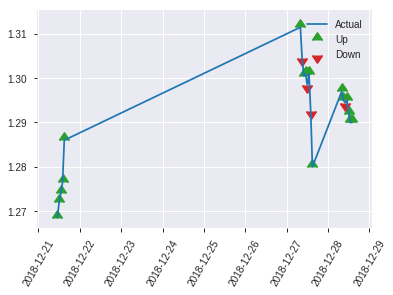


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18809279819030403
RMSE: 0.43369666610466817
LogLoss: 0.5556969813733126
Mean Per-Class Error: 0.24472940665072818
AUC: 0.7853727450554228
pr_auc: 0.6929469115324777
Gini: 0.5707454901108455
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4264335334300995: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   31   0.2897   (31.0/107.0)
1      18   68   0.2093   (18.0/86.0)
Total  94   99   0.2539   (49.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426434     0.735135  98
max f2                       0.248751     0.840164  143
max f0point5                 0.453534     0.725806  86
max accuracy                 0.453534     0.756477  86
max precision                0.927858     1         0
max recall                   0.0729665    1         184
max specificity              0.927858     1         0
max absolute_mcc             0.447969     0.50905   88
max min_per_class_accuracy   0.437605     0.747664  91
max mean_per_class_accuracy  0.447969     0.755271  88

Gains/Lift Table: Avg response rate: 44.56 %, avg score: 43.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.889177           2.24419   2.24419            1                0.912383   1                           0.912383            0.0232558       0.0232558                  124.419   124.419
    2        0.0207254                   0.868788           2.24419   2.24419            1                0.883162   1                           0.897773            0.0232558       0.0465116                  124.419   124.419
    3        0.0310881                   0.855636           1.12209   1.87016            0.5              0.863731   0.833333                    0.886425            0.0116279       0.0581395                  12.2093   87.0155
    4        0.0414508                   0.828799           1.12209   1.68314            0.5              0.848402   0.75                        0.87692             0.0116279       0.0697674                  12.2093   68.314
    5        0.0518135                   0.815998           2.24419   1.79535            1                0.820507   0.8                         0.865637            0.0232558       0.0930233                  124.419   79.5349
    6        0.103627                    0.716621           1.34651   1.57093            0.6              0.763441   0.7                         0.814539            0.0697674       0.162791                   34.6512   57.093
    7        0.150259                    0.652536           1.49612   1.54771            0.666667         0.677254   0.689655                    0.771933            0.0697674       0.232558                   49.6124   54.7715
    8        0.202073                    0.635497           2.24419   1.7263             1                0.643531   0.769231                    0.73901             0.116279        0.348837                   124.419   72.6297
    9        0.300518                    0.584875           1.06304   1.50902            0.473684         0.615904   0.672414                    0.698682            0.104651        0.453488                   6.30355   50.9022
    10       0.398964                    0.533554           1.88984   1.60299            0.842105         0.563605   0.714286                    0.665351            0.186047        0.639535                   88.9841   60.299
    11       0.502591                    0.427755           1.34651   1.55011            0.6              0.46302    0.690722                    0.623633            0.139535        0.77907                    34.6512   55.0108
    12       0.601036                    0.360594           0.590575  1.39294            0.263158         0.396667   0.62069                     0.586458            0.0581395       0.837209                   -40.9425  39.2943
    13       0.699482                    0.269289           0.70869   1.29664            0.315789         0.321291   0.577778                    0.549138            0.0697674       0.906977                   -29.131   29.6641
    14       0.797927                    0.214709           0.47246   1.19496            0.210526         0.242648   0.532468                    0.511324            0.0465116       0.953488                   -52.754   19.4956
    15       0.896373                    0.130184           0.354345  1.10263            0.157895         0.171732   0.491329                    0.474028            0.0348837       0.988372                   -64.5655  10.2635
    16       1                           0.0352525          0.112209  1                  0.05             0.0799866  0.445596                    0.

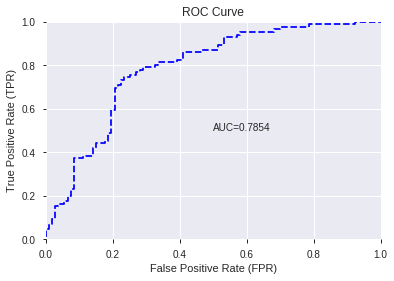

This function is available for GLM models only


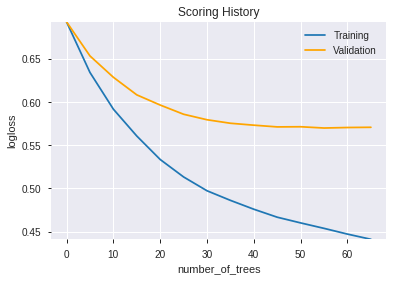

--2019-08-25 13:26:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.65.56
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.65.56|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_132605_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_132605_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a23f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'hour',
 'TRANGE',
 'STOCHRSI_fastk',
 'CCI_12',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastd',
 'MINUS_DI_8',
 'SUB',
 'DIV',
 'WILLR_20',
 'ULTOSC',
 'CCI_8',
 'WILLR_30',
 'ADOSC',
 'WILLR_8',
 'WILLR_14',
 'CMO_12',
 'CMO_8',
 'WILLR_12',
 'CMO_14',
 'WILLR_24',
 'CDLSHORTLINE',
 'CDLLONGLINE',
 'RSI_12',
 'RSI_8',
 'RSI_14']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

104

['BBANDS_lowerband_20_2_4',
 'BBANDS_lowerband_20_3_3',
 'MA_20_5',
 'BBANDS_middleband_20_5_2',
 'BBANDS_middleband_20_5_3',
 'BBANDS_upperband_20_7_2',
 'SAR_0.24',
 'BBANDS_lowerband_24_1_2',
 'MA_24_2',
 'BBANDS_middleband_24_7_2',
 'BBANDS_upperband_30_1_3',
 'BBANDS_lowerband_30_2_5',
 'BBANDS_lowerband_30_7_5',
 'ADX_8',
 'aroondown_8',
 'aroonup_8',
 'AROONOSC_8',
 'DX_8',
 'MFI_8',
 'MOM_8',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'WILLR_8',
 'CCI_12',
 'MACDFIX_12',
 'MACDFIX_hist_12',
 'MINUS_DM_12',
 'MOM_12',
 'PLUS_DI_12',
 'RSI_12',
 'WILLR_12',
 'aroondown_14',
 'MACDFIX_14',
 'MACDFIX_signal_14',
 'MINUS_DM_14',
 'MOM_14',
 'PLUS_DM_14',
 'ROCP_14',
 'ROCR100_14',
 'aroondown_20',
 'aroonup_20',
 'DX_20',
 'MFI_20',
 'MINUS_DM_20',
 'MOM_20',
 'PLUS_DI_20',
 'PLUS_DM_20',
 'ROC_20',
 'ROCR_20',
 'RSI_20',
 'WILLR_20',
 'AROONOSC_24',
 'MACDFIX_24',
 'MFI_24',
 'PLUS_DM_24',
 'RSI_24',
 'WILLR_24',
 'aroonup_30',
 'AROONOSC_30',
 'CCI_30',
 'CMO_30',
 'MINUS_DM_30',
 'ROCP_30',
 '

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_132813_model_5  0.702782  0.637305              0.395947  0.470945  0.221789
1  DeepLearning_grid_1_AutoML_20190825_132813_model_9  0.700717  0.623953              0.380678  0.468114  0.219130
2  DeepLearning_grid_1_AutoML_20190825_132813_model_8  0.699848  0.623418              0.360737  0.468333  0.219336
3  DeepLearning_grid_1_AutoML_20190825_132813_model_3  0.694088  0.778336              0.338296  0.500164  0.250164
4  DeepLearning_grid_1_AutoML_20190825_132813_model_6  0.685938  0.639922              0.352423  0.473246  0.223962
5  DeepLearning_grid_1_AutoML_20190825_132813_model_7  0.685286  0.884498              0.374755  0.533507  0.284630
6  DeepLearning_grid_1_AutoML_20190825_132813_model_4  0.657900  1.207128              0.441534  0.554459  0.307424
7               DeepLearning_1_AutoML_20190825_132813  0.643338  0.838425              0.490654  0.537102  0.288479
8  DeepLearning_grid_1_AutoML_20190825_132813_model_2  0.635949  1.341592              0.429798  0.586288  0.343734
9  DeepLearning_grid_1_AutoML_20190825_132813_model_1  0.553358  2.072834              0.442676  0.655942  0.430260

variable  relative_importance  scaled_importance  percentage
0                 CDLLONGLINE             1.000000           1.000000    0.022338
1                      TRANGE             0.740136           0.740136    0.016533
2                STOCHF_fastk             0.689335           0.689335    0.015399
3                CDLSHORTLINE             0.664620           0.664620    0.014846
4                      ULTOSC             0.621092           0.621092    0.013874
..                        ...                  ...                ...         ...
99    BBANDS_lowerband_24_1_2             0.345927           0.345927    0.007727
100   BBANDS_upperband_20_7_2             0.342193           0.342193    0.007644
101   BBANDS_lowerband_20_2_4             0.341567           0.341567    0.007630
102                    RSI_20             0.339191           0.339191    0.007577
103  BBANDS_middleband_24_7_2             0.325898           0.325898    0.007280

[104 rows x 4 columns]

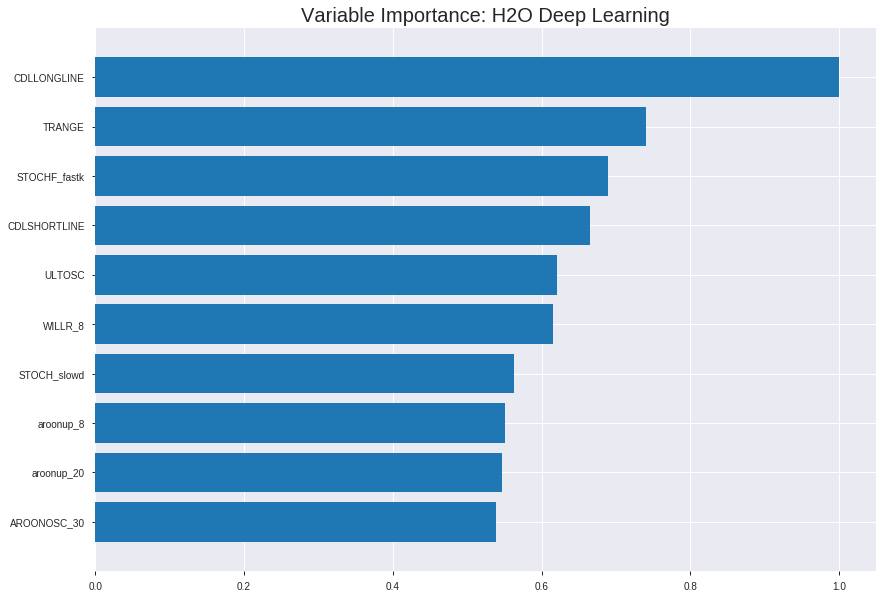

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_132813_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18409690343644658
RMSE: 0.429065150573251
LogLoss: 0.5407443392689119
Mean Per-Class Error: 0.2796164470888227
AUC: 0.7975622875053124
pr_auc: 0.7744136265739928
Gini: 0.5951245750106249
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4124079783886995: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      412  312  0.4309   (312.0/724.0)
1      98   526  0.1571   (98.0/624.0)
Total  510  838  0.3042   (410.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.412408     0.719562  234
max f2                       0.269636     0.840067  303
max f0point5                 0.557158     0.703413  144
max accuracy                 0.481521     0.720326  194
max precision                0.993108     1         0
max recall                   0.0826141    1         368
max specificity              0.993108     1         0
max absolute_mcc             0.479726     0.439766  196
max min_per_class_accuracy   0.479726     0.719613  196
max mean_per_class_accuracy  0.479726     0.720384  196

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 45.99 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.962701           2.16026    2.16026            1                0.978586   1                           0.978586            0.0224359       0.0224359                  116.026   116.026
    2        0.0200297                   0.937333           2.16026    2.16026            1                0.95106    1                           0.965333            0.0208333       0.0432692                  116.026   116.026
    3        0.0304154                   0.915834           2.16026    2.16026            1                0.926388   1                           0.952035            0.0224359       0.0657051                  116.026   116.026
    4        0.0400593                   0.88103            1.82791    2.08025            0.846154         0.898171   0.962963                    0.939067            0.0176282       0.0833333                  82.7909   108.025
    5        0.0504451                   0.849396           2.16026    2.09672            1                0.868049   0.970588                    0.924446            0.0224359       0.105769                   116.026   109.672
    6        0.100148                    0.749097           1.93456    2.01624            0.895522         0.796559   0.933333                    0.860976            0.0961538       0.201923                   93.4558   101.624
    7        0.150593                    0.682051           1.58842    1.87293            0.735294         0.713318   0.866995                    0.811514            0.0801282       0.282051                   58.8424   87.2932
    8        0.200297                    0.618716           1.64437    1.81622            0.761194         0.644246   0.840741                    0.770007            0.0817308       0.363782                   64.4374   81.6216
    9        0.300445                    0.545331           1.34416    1.65886            0.622222         0.581321   0.767901                    0.707112            0.134615        0.498397                   34.416    65.8864
    10       0.399852                    0.508845           1.12849    1.52701            0.522388         0.524589   0.706865                    0.661735            0.112179        0.610577                   12.8492   52.7009
    11       0.5                         0.473804           1.24815    1.47115            0.577778         0.490506   0.681009                    0.627438            0.125           0.735577                   24.8148   47.1154
    12       0.600148                    0.424948           0.848101   1.36718            0.392593         0.452031   0.63288                     0.598168            0.0849359       0.820513                   -15.1899  36.7183
    13       0.699555                    0.361144           0.773823   1.28287            0.358209         0.39684    0.593849                    0.569559            0.0769231       0.897436                   -22.6177  28.2867
    14       0.799703                    0.276478           0.608072   1.19836            0.281481         0.318188   0.554731                    0.538079            0.0608974       0.958333                   -39.1928  19.8361
    15       0.899852                    0.140548           0.320038   1.10061            0.148148         0.2213     0.509481                    0.502824            0.0320513       0.990385                   -67.9962  10.0609
    16       1                           0.0018301          0.0960114  1                  0.0444444        0.0740292  0.462908 



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.23394440711082787
RMSE: 0.48367799940748585
LogLoss: 0.6638694100957987
Mean Per-Class Error: 0.3664379861711322
AUC: 0.6616789109766638
pr_auc: 0.6146361693555917
Gini: 0.3233578219533275
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18159211277465453: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      42   166  0.7981   (166.0/208.0)
1      11   167  0.0618   (11.0/178.0)
Total  53   333  0.4585   (177.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.181592     0.65362   332
max f2                       0.0687185    0.820276  372
max f0point5                 0.469706     0.602725  193
max accuracy                 0.487799     0.632124  177
max precision                0.960984     1         0
max recall                   0.0687185    1         372
max specificity              0.960984     1         0
max absolute_mcc             0.455124     0.267236  208
max min_per_class_accuracy   0.475041     0.625     189
max mean_per_class_accuracy  0.455124     0.633562  208

Gains/Lift Table: Avg response rate: 46.11 %, avg score: 45.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.899305           1.6264    1.6264             0.75             0.939854   0.75                        0.939854            0.0168539       0.0168539                  62.6404   62.6404
    2        0.0207254                   0.88025            2.16854   1.89747            1                0.889058   0.875                       0.914456            0.0224719       0.0393258                  116.854   89.7472
    3        0.0310881                   0.842934           2.16854   1.98783            1                0.86315    0.916667                    0.897354            0.0224719       0.0617978                  116.854   98.7828
    4        0.0414508                   0.816029           0.542135  1.6264             0.25             0.830411   0.75                        0.880618            0.00561798      0.0674157                  -45.7865  62.6404
    5        0.0518135                   0.794654           1.6264    1.6264             0.75             0.807063   0.75                        0.865907            0.0168539       0.0842697                  62.6404   62.6404
    6        0.101036                    0.733328           1.59787   1.6125             0.736842         0.763972   0.74359                     0.816246            0.0786517       0.162921                   59.7871   61.2504
    7        0.150259                    0.678419           1.14134   1.45816            0.526316         0.70393    0.672414                    0.779453            0.0561798       0.219101                   14.1336   45.8156
    8        0.202073                    0.642707           1.40955   1.44569            0.65             0.659095   0.666667                    0.748592            0.0730337       0.292135                   40.9551   44.5693
    9        0.300518                    0.584707           1.08427   1.3273             0.5              0.60976    0.612069                    0.703113            0.106742        0.398876                   8.42697   32.7296
    10       0.401554                    0.523115           1.16768   1.28713            0.538462         0.556483   0.593548                    0.666219            0.117978        0.516854                   16.7675   28.7133
    11       0.5                         0.47125            1.25547   1.2809             0.578947         0.495873   0.590674                    0.632679            0.123596        0.640449                   25.547    28.0899
    12       0.601036                    0.424558           0.834054  1.20578            0.384615         0.449059   0.556034                    0.601812            0.0842697       0.724719                   -16.5946  20.5783
    13       0.699482                    0.337197           0.856002  1.15655            0.394737         0.375568   0.533333                    0.56997             0.0842697       0.808989                   -14.3998  15.6554
    14       0.800518                    0.249342           0.722846  1.10181            0.333333         0.287048   0.508091                    0.534262            0.0730337       0.882022                   -27.7154  10.1814
    15       0.898964                    0.15073            0.684802  1.05615            0.315789         0.196381   0.487032                    0.49726             0.0674157       0.949438                   -31.5198  5.61474
    16       1                           0.000989996        0.500432  1                  0.230769         0.0834743  0.46114                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 13:32:07  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 13:32:09  1 min 38.551 sec  1132 obs/sec      2         1             2696       0.47303          0.638759            0.100016       0.691091        0.639851           1.69734          0.376855                         0.54027            0.809972              -0.174661        0.580839          0.551365             1.6264             0.494819
    2019-08-25 13:32:17  1 min 45.856 sec  1498 obs/sec      10        5             13480      0.445127         0.579013            0.203061       0.758343        0.734325           2.16026          0.343472                         0.503529           0.743422              -0.0203273       0.638964          0.603881             2.16854            0.505181
    2019-08-25 13:32:25  1 min 53.899 sec  1647 obs/sec      20        10            26960      0.429065         0.540744            0.259537       0.797562        0.774414           2.16026          0.304154                         0.483678           0.663869              0.0585355        0.661679          0.614636             1.6264             0.458549
    2019-08-25 13:32:32  2 min  1.673 sec  1724 obs/sec      30        15            40440      0.420552         0.523005            0.288628       0.817836        0.807295           2.16026          0.324926                         0.50213            0.720344              -0.014668        0.633805          0.585075             1.6264             0.510363
    2019-08-25 13:32:40  2 min  9.293 sec  1774 obs/sec      40        20            53920      0.400248         0.481219            0.355661       0.860661        0.852973           2.16026          0.264095                         0.504198           0.751241              -0.0230414       0.635844          0.601398             2.16854            0.515544
    2019-08-25 13:32:48  2 min 16.856 sec  1810 obs/sec      50        25            67400      0.373755         0.425102            0.438137       0.894055        0.879941           2.16026          0.21365                          0.490741           0.693501              0.0308375        0.676966          0.608425             1.6264             0.373057
    2019-08-25 13:32:55  2 min 24.355 sec  1836 obs/sec      60        30            80880      0.357708         0.394808            0.485347       0.906497        0.891885           2.16026          0.195104                         0.503184           0.733208              -0.0189315       0.642097          0.586645             1.6264             0.440415
    2019-08-25 13:32:56  2 min 25.062 sec  1835 obs/sec      60        30            80880      0.429065         0.540744            0.259537       0.797562        0.774414           2.16026          0.304154                         0.483678           0.663869              0.0585355        0.661679          0.614636             1.6264             0.458549

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
CDLLONGLINE               1.0                    1.0                  0.022338323168311074
TRANGE                    0.7401358485221863     0.7401358485221863   0.01653339377274073
STOCHF_fastk              0.6893346309661865     0.6893346309661865   0.015398579757631129
CDLSHORTLINE              0.6646197438240051     0.6646197438240051   0.014846490621580746
ULTOSC                    0.6210924386978149     0.6210924386978149   0.013874163613026225
---                       ---                    ---                  ---
BBANDS_lowerband_24_1_2   0.34592685103416443    0.34592685103416443  0.007727425790997369
BBANDS_upperband_20_7_2   0.34219279885292053    0.34219279885292053  0.007644013326645406
BBANDS_lowerband_20_2_4   0.3415674567222595     0.3415674567222595   0.00763004423203994
RSI_20                    0.3391912579536438     0.3391912579536438   0.007576963936034459
BBANDS_middleband_24_7_2  0.32589757442474365    0.32589757442474365  0.007280005337268634


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6735751295336787)

('F1', 0.6639999999999999)

('auc', 0.702782003912193)

('logloss', 0.6373051835348186)

('mean_per_class_error', 0.3298739404477288)

('rmse', 0.4709446035356212)

('mse', 0.2217888195993234)

deeplearning prediction progress: |███████████████████████████████████████| 100%


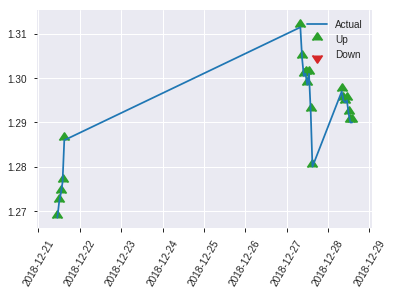


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2217888195993234
RMSE: 0.4709446035356212
LogLoss: 0.6373051835348186
Mean Per-Class Error: 0.3298739404477288
AUC: 0.702782003912193
pr_auc: 0.6283015562086143
Gini: 0.40556400782438606
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16625234851733645: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      26   81   0.757    (81.0/107.0)
1      3    83   0.0349   (3.0/86.0)
Total  29   164  0.4352   (84.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.166252     0.664     163
max f2                       0.166252     0.816929  163
max f0point5                 0.455041     0.634921  72
max accuracy                 0.455041     0.673575  72
max precision                0.758027     0.888889  8
max recall                   0.0401477    1         190
max specificity              0.884098     0.990654  0
max absolute_mcc             0.365058     0.338236  95
max min_per_class_accuracy   0.374286     0.663551  93
max mean_per_class_accuracy  0.365058     0.670126  95

Gains/Lift Table: Avg response rate: 44.56 %, avg score: 38.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.852202           1.12209   1.12209            0.5              0.873161   0.5                         0.873161            0.0116279       0.0116279                  12.2093   12.2093
    2        0.0207254                   0.817644           2.24419   1.68314            1                0.842983   0.75                        0.858072            0.0232558       0.0348837                  124.419   68.314
    3        0.0310881                   0.783192           2.24419   1.87016            1                0.7989     0.833333                    0.838348            0.0232558       0.0581395                  124.419   87.0155
    4        0.0414508                   0.763478           2.24419   1.96366            1                0.779096   0.875                       0.823535            0.0232558       0.0813953                  124.419   96.3663
    5        0.0518135                   0.734372           1.12209   1.79535            0.5              0.755254   0.8                         0.809879            0.0116279       0.0930233                  12.2093   79.5349
    6        0.103627                    0.681473           1.34651   1.57093            0.6              0.700757   0.7                         0.755318            0.0697674       0.162791                   34.6512   57.093
    7        0.150259                    0.601684           1.49612   1.54771            0.666667         0.648307   0.689655                    0.722108            0.0697674       0.232558                   49.6124   54.7715
    8        0.202073                    0.574627           1.12209   1.43858            0.5              0.587072   0.641026                    0.687483            0.0581395       0.290698                   12.2093   43.8581
    9        0.300518                    0.496188           1.5355    1.47033            0.684211         0.532733   0.655172                    0.636789            0.151163        0.44186                    53.5496   47.0329
    10       0.398964                    0.445181           1.29927   1.42812            0.578947         0.472081   0.636364                    0.596147            0.127907        0.569767                   29.9266   42.8118
    11       0.502591                    0.354865           1.12209   1.36502            0.5              0.398949   0.608247                    0.555487            0.116279        0.686047                   12.2093   36.502
    12       0.601036                    0.290016           0.70869   1.25752            0.315789         0.319426   0.560345                    0.516822            0.0697674       0.755814                   -29.131   25.7518
    13       0.699482                    0.239079           0.70869   1.18028            0.315789         0.264217   0.525926                    0.48127             0.0697674       0.825581                   -29.131   18.0276
    14       0.797927                    0.1862             0.70869   1.12209            0.315789         0.216226   0.5                         0.44857             0.0697674       0.895349                   -29.131   12.2093
    15       0.896373                    0.121177           0.70869   1.07669            0.315789         0.160136   0.479769                    0.416892            0.0697674       0.965116                   -29.131   7.66904
    16       1                           0.0124502          0.336628  1                  0.15             0.0770887  0.445596                    0.

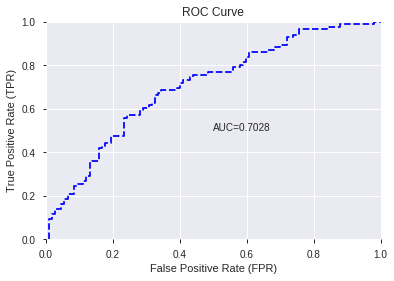

This function is available for GLM models only


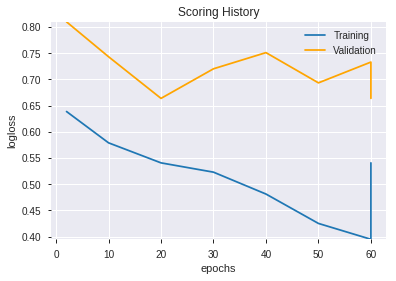

--2019-08-25 13:37:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.196
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.196|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_132813_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_132813_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a23f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLLONGLINE',
 'TRANGE',
 'STOCHF_fastk',
 'CDLSHORTLINE',
 'ULTOSC',
 'WILLR_8',
 'STOCH_slowd',
 'aroonup_8',
 'aroonup_20',
 'AROONOSC_30',
 'HT_TRENDMODE',
 'PLUS_DM_8',
 'CORREL_8',
 'aroondown_14',
 'aroonup_30',
 'aroondown_20',
 'DX_8',
 'MFI_20',
 'WILLR_24',
 'CORREL_14',
 'BETA_14',
 'STOCHF_fastd',
 'CCI_12',
 'BETA_8',
 'MACDFIX_14',
 'DX_20',
 'MACDFIX_signal_14',
 'MACDEXT_hist',
 'AROONOSC_24',
 'MFI_8',
 'ADOSC',
 'STOCHRSI_fastd',
 'WILLR_12',
 'aroondown_8',
 'BETA_12',
 'CDLSPINNINGTOP',
 'ATR_30',
 'CORREL_12',
 'MFI_24',
 'MINUS_DM_30',
 'HT_PHASOR_quadrature',
 'STOCH_slowk',
 'AROONOSC_8',
 'ADX_8',
 'STDDEV_12',
 'PLUS_DM_20',
 'RSI_12',
 'NATR_8',
 'ATR_8',
 'PLUS_DI_8',
 'MACDFIX_24',
 'MOM_8',
 'ATR_20',
 'PLUS_DM_14',
 'MACDFIX_12',
 'ROCP_30',
 'BBANDS_lowerband_30_7_5',
 'WILLR_20',
 'CMO_30',
 'LINEARREG_SLOPE_12',
 'PLUS_DI_20',
 'RSI_30',
 'ROCR100_14',
 'LINEARREG_ANGLE_8',
 'ATR_14',
 'LINEARREG_INTERCEPT_12',
 'VAR_12',
 'CDLHAMMER',
 'LINEARREG_A

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_133853_model_1  0.705281  0.627602              0.394805  0.469631  0.220553

variable  relative_importance  scaled_importance  percentage
0                 CDLLONGLINE             0.379321           1.000000    0.064789
1                STOCHF_fastk             0.292336           0.770683    0.049931
2                     WILLR_8             0.234168           0.617335    0.039996
3                      ULTOSC             0.208110           0.548638    0.035545
4                CDLSHORTLINE             0.179955           0.474414    0.030737
..                        ...                  ...                ...         ...
99    BBANDS_lowerband_24_1_2             0.003829           0.010095    0.000654
100               MINUS_DM_30             0.002977           0.007849    0.000509
101  BBANDS_middleband_24_7_2             0.002230           0.005878    0.000381
102                     VAR_8             0.001654           0.004359    0.000282
103            STOCHRSI_fastd             0.001087           0.002867    0.000186

[104 rows x 4 columns]

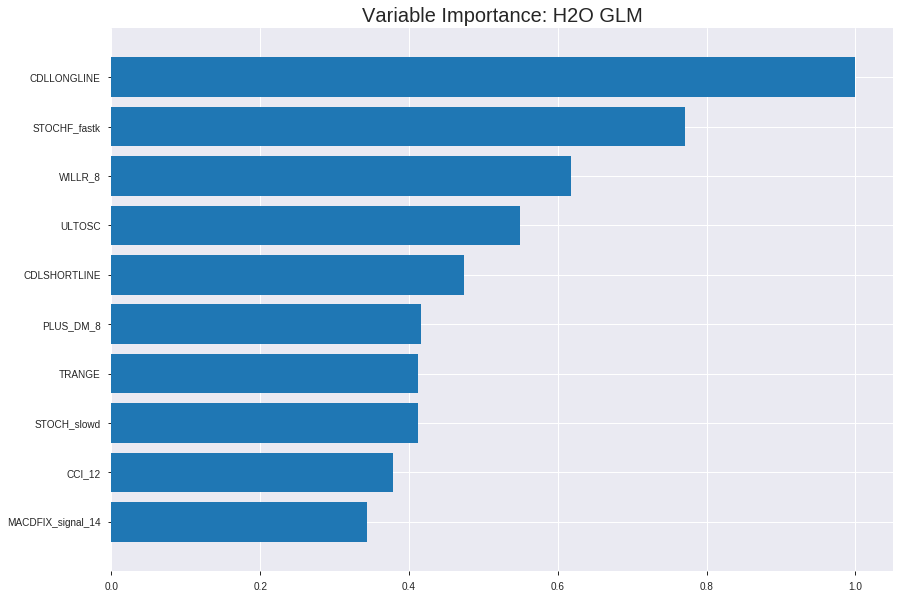

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_133853_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19808379656373704
RMSE: 0.4450660586516759
LogLoss: 0.5811416324325427
Null degrees of freedom: 1347
Residual degrees of freedom: 1243
Null deviance: 1861.2995819096327
Residual deviance: 1566.7578410381352
AIC: 1776.7578410381352
AUC: 0.7684859310808896
pr_auc: 0.7243981170166487
Gini: 0.5369718621617792
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39193426829924466: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      391  333  0.4599   (333.0/724.0)
1      94   530  0.1506   (94.0/624.0)
Total  485  863  0.3168   (427.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.391934     0.712845  248
max f2                       0.198401     0.823023  345
max f0point5                 0.473932     0.6875    199
max accuracy                 0.473932     0.71365   199
max precision                0.886964     1         0
max recall                   0.0817115    1         390
max specificity              0.886964     1         0
max absolute_mcc             0.46415      0.427644  206
max min_per_class_accuracy   0.476729     0.707182  197
max mean_per_class_accuracy  0.46825      0.714363  203

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 46.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.8398             2.16026   2.16026            1                0.856357  1                           0.856357            0.0224359       0.0224359                  116.026   116.026
    2        0.0200297                   0.824626           1.82791   2.00024            0.846154         0.831925  0.925926                    0.844594            0.0176282       0.0400641                  82.7909   100.024
    3        0.0304154                   0.806185           2.00595   2.00219            0.928571         0.815328  0.926829                    0.8346              0.0208333       0.0608974                  100.595   100.219
    4        0.0400593                   0.789335           1.66174   1.92023            0.769231         0.796212  0.888889                    0.825359            0.0160256       0.0769231                  66.1736   92.0228
    5        0.0504451                   0.771388           1.85165   1.90611            0.857143         0.779817  0.882353                    0.815983            0.0192308       0.0961538                  85.1648   90.6109
    6        0.100148                    0.720808           1.45092   1.6802             0.671642         0.745152  0.777778                    0.78083             0.0721154       0.168269                   45.0918   68.0199
    7        0.150593                    0.671287           1.74727   1.70267            0.808824         0.695369  0.788177                    0.752202            0.088141        0.25641                    74.7266   70.2665
    8        0.200297                    0.624996           1.77334   1.7202             0.820896         0.647793  0.796296                    0.726293            0.088141        0.344551                   77.3345   72.0204
    9        0.300445                    0.566456           1.37616   1.60552            0.637037         0.594378  0.74321                     0.682321            0.137821        0.482372                   37.6163   60.5524
    10       0.399852                    0.513157           1.24134   1.51499            0.574627         0.541109  0.701299                    0.647215            0.123397        0.605769                   24.1341   51.4985
    11       0.5                         0.468753           1.23215   1.45833            0.57037          0.49208   0.675074                    0.616142            0.123397        0.729167                   23.2146   45.8333
    12       0.600148                    0.409879           0.832099  1.35383            0.385185         0.44279   0.6267                      0.587214            0.0833333       0.8125                     -16.7901  35.3832
    13       0.699555                    0.356892           0.628731  1.2508             0.291045         0.384818  0.579003                    0.558454            0.0625          0.875                      -37.1269  25.0795
    14       0.799703                    0.288685           0.576068  1.1663             0.266667         0.325162  0.539889                    0.529238            0.0576923       0.932692                   -42.3932  16.6298
    15       0.899852                    0.20196            0.432051  1.08458            0.2              0.247435  0.502061                    0.497875            0.0432692       0.975962                   -56.7949  8.45805
    16       1                           0.00533838         0.240028  1                  0.111111         0.148723  0.462908                    0.462908         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21563118607008253
RMSE: 0.4643610514137491
LogLoss: 0.6191594843396927
Null degrees of freedom: 385
Residual degrees of freedom: 281
Null deviance: 532.7805186446055
Residual deviance: 477.9911219102428
AIC: 687.9911219102428
AUC: 0.7128619273984443
pr_auc: 0.6662894576089311
Gini: 0.4257238547968887
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24473880187963032: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      69   139  0.6683   (139.0/208.0)
1      15   163  0.0843   (15.0/178.0)
Total  84   302  0.399    (154.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.244739     0.679167  301
max f2                       0.168384     0.826211  340
max f0point5                 0.386797     0.628544  219
max accuracy                 0.386797     0.658031  219
max precision                0.887549     1         0
max recall                   0.0536314    1         379
max specificity              0.887549     1         0
max absolute_mcc             0.358845     0.339783  231
max min_per_class_accuracy   0.430031     0.644231  188
max mean_per_class_accuracy  0.358845     0.666892  231

Gains/Lift Table: Avg response rate: 46.11 %, avg score: 42.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.849109           2.16854   2.16854            1                0.869295  1                           0.869295            0.0224719       0.0224719                  116.854    116.854
    2        0.0207254                   0.821823           1.6264    1.89747            0.75             0.839728  0.875                       0.854512            0.0168539       0.0393258                  62.6404    89.7472
    3        0.0310881                   0.796918           1.08427   1.6264             0.5              0.809215  0.75                        0.839413            0.011236        0.0505618                  8.42697    62.6404
    4        0.0414508                   0.786827           1.6264    1.6264             0.75             0.794666  0.75                        0.828226            0.0168539       0.0674157                  62.6404    62.6404
    5        0.0518135                   0.761648           1.6264    1.6264             0.75             0.772419  0.75                        0.817065            0.0168539       0.0842697                  62.6404    62.6404
    6        0.101036                    0.685654           1.94027   1.77931            0.894737         0.71812   0.820513                    0.768861            0.0955056       0.179775                   94.0272    77.9314
    7        0.150259                    0.636993           1.48374   1.68249            0.684211         0.659436  0.775862                    0.733015            0.0730337       0.252809                   48.3737    68.2487
    8        0.202073                    0.598131           1.1927    1.5569             0.55             0.615537  0.717949                    0.702892            0.0617978       0.314607                   19.2697    55.69
    9        0.300518                    0.533374           1.31254   1.47685            0.605263         0.569465  0.681034                    0.659184            0.129213        0.44382                    31.2537    47.685
    10       0.401554                    0.482574           1.00086   1.35709            0.461538         0.506189  0.625806                    0.620688            0.101124        0.544944                   0.0864304  35.7086
    11       0.5                         0.420985           1.1984    1.32584            0.552632         0.455137  0.611399                    0.588093            0.117978        0.662921                   19.8403    32.5843
    12       0.601036                    0.358845           1.16768   1.29925            0.538462         0.391241  0.599138                    0.555001            0.117978        0.780899                   16.7675    29.9254
    13       0.699482                    0.298855           0.570668  1.19671            0.263158         0.331516  0.551852                    0.523548            0.0561798       0.837079                   -42.9332   19.6712
    14       0.800518                    0.228359           0.834054  1.15094            0.384615         0.268114  0.530744                    0.491308            0.0842697       0.921348                   -16.5946   15.094
    15       0.898964                    0.155988           0.570668  1.08739            0.263158         0.190487  0.501441                    0.458365            0.0561798       0.977528                   -42.9332   8.73944
    16       1                           0.0214379          0.222414  1                  0.102564         0.102166  0.46114                     0.42


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-25 13:38:53  0.000 sec   2            .14E2     104           1.3657983399484483  1.368846907779271
     2019-08-25 13:38:53  0.015 sec   4            .1E2      105           1.3615629649259504  1.3654380307040244
     2019-08-25 13:38:53  0.035 sec   6            .76E1     105           1.3563483513265675  1.3611140491873608
     2019-08-25 13:38:53  0.050 sec   8            .55E1     105           1.3499448338872937  1.3556127832814482
     2019-08-25 13:38:53  0.068 sec   10           .4E1      105           1.3421826632739815  1.3487815464897055
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-25 13:38:53  0.318 sec   40           .34E-1    105           1.1544713560824638  1.2393512844969696
     2019-08-25 13:38:53  0.335 sec   42           .25E-1    105           1.1472969764790883  1.2406754344808824
     2019-08-25 13:38:53  0.349 sec   44           .18E-1    105           1.140670522188808   1.2428248893773683
     2019-08-25 13:38:53  0.363 sec   46           .13E-1    105           1.1345218620410453  1.2456027551137068
     2019-08-25 13:38:53  0.382 sec   48           .96E-2    105           1.1288358188727978  1.250072425150913


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6735751295336787)

('F1', 0.6666666666666666)

('auc', 0.7052814605520539)

('logloss', 0.6276017270222509)

('mean_per_class_error', 0.34345794392523366)

('rmse', 0.46963112232298254)

('mse', 0.2205533910543442)

glm prediction progress: |████████████████████████████████████████████████| 100%


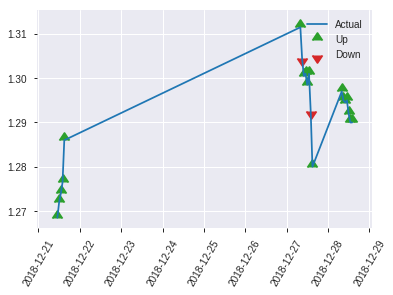


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2205533910543442
RMSE: 0.46963112232298254
LogLoss: 0.6276017270222509
Null degrees of freedom: 192
Residual degrees of freedom: 88
Null deviance: 265.4984131782047
Residual deviance: 242.25426663058886
AIC: 452.25426663058886
AUC: 0.7052814605520539
pr_auc: 0.6175441394931915
Gini: 0.41056292110410775
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17502807084244365: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      25   82   0.7664   (82.0/107.0)
1      2    84   0.0233   (2.0/86.0)
Total  27   166  0.4352   (84.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.175028     0.666667  165
max f2                       0.144509     0.826923  175
max f0point5                 0.449479     0.636095  62
max accuracy                 0.449479     0.673575  62
max precision                0.823051     1         0
max recall                   0.144509     1         175
max specificity              0.823051     1         0
max absolute_mcc             0.449479     0.331864  62
max min_per_class_accuracy   0.383788     0.651163  92
max mean_per_class_accuracy  0.449479     0.656542  62

Gains/Lift Table: Avg response rate: 44.56 %, avg score: 38.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.790933           1.12209   1.12209            0.5              0.813145  0.5                         0.813145            0.0116279       0.0116279                  12.2093   12.2093
    2        0.0207254                   0.785653           2.24419   1.68314            1                0.789186  0.75                        0.801165            0.0232558       0.0348837                  124.419   68.314
    3        0.0310881                   0.780237           2.24419   1.87016            1                0.78307   0.833333                    0.795134            0.0232558       0.0581395                  124.419   87.0155
    4        0.0414508                   0.753953           1.12209   1.68314            0.5              0.769183  0.75                        0.788646            0.0116279       0.0697674                  12.2093   68.314
    5        0.0518135                   0.72471            1.12209   1.57093            0.5              0.73939   0.7                         0.778795            0.0116279       0.0813953                  12.2093   57.093
    6        0.103627                    0.653225           1.57093   1.57093            0.7              0.689805  0.7                         0.7343              0.0813953       0.162791                   57.093    57.093
    7        0.150259                    0.589917           1.24677   1.47033            0.555556         0.624234  0.655172                    0.700142            0.0581395       0.22093                    24.677    47.0329
    8        0.202073                    0.544421           1.79535   1.55367            0.8              0.554628  0.692308                    0.66283             0.0930233       0.313953                   79.5349   55.3667
    9        0.300518                    0.457192           1.41738   1.50902            0.631579         0.48956   0.672414                    0.606069            0.139535        0.453488                   41.7381   50.9022
    10       0.398964                    0.41291            1.06304   1.39897            0.473684         0.440753  0.623377                    0.565277            0.104651        0.55814                    6.30355   39.8973
    11       0.502591                    0.376758           1.00988   1.31875            0.45             0.392801  0.587629                    0.529715            0.104651        0.662791                   0.988372  31.8749
    12       0.601036                    0.334973           0.826805  1.23817            0.368421         0.356021  0.551724                    0.501265            0.0813953       0.744186                   -17.3195  23.8172
    13       0.699482                    0.296909           1.06304   1.21352            0.473684         0.315758  0.540741                    0.475157            0.104651        0.848837                   6.30355   21.3523
    14       0.797927                    0.213894           0.590575  1.13667            0.263158         0.255169  0.506494                    0.448015            0.0581395       0.906977                   -40.9425  13.6666
    15       0.896373                    0.152205           0.826805  1.10263            0.368421         0.18289   0.491329                    0.418898            0.0813953       0.988372                   -17.3195  10.2635
    16       1                           0.051562           0.112209  1                  0.05             0.106401  0.445596                    0.386514            0

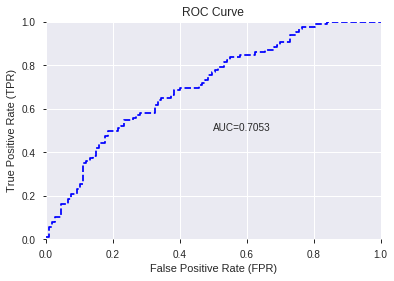

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


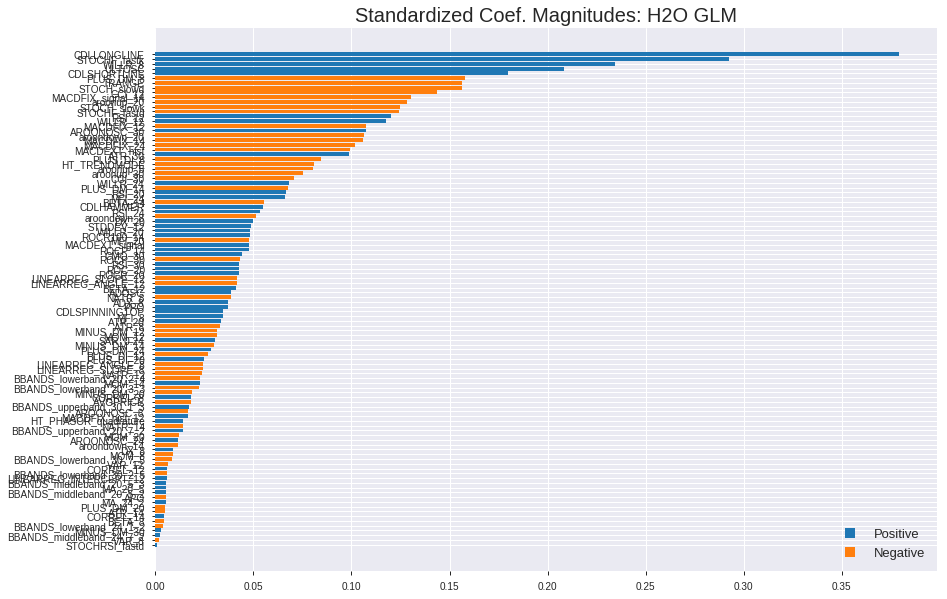

'log_likelihood'
--2019-08-25 13:39:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_133853_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_133853_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a23f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLLONGLINE',
 'STOCHF_fastk',
 'WILLR_8',
 'ULTOSC',
 'CDLSHORTLINE',
 'PLUS_DM_8',
 'TRANGE',
 'STOCH_slowd',
 'CCI_12',
 'MACDFIX_signal_14',
 'aroonup_20',
 'STOCH_slowk',
 'STOCHF_fastd',
 'RSI_12',
 'WILLR_12',
 'MACDFIX_12',
 'AROONOSC_30',
 'aroondown_20',
 'MACDFIX_14',
 'MACDFIX_24',
 'MACDEXT_hist',
 'ATR_30',
 'PLUS_DI_8',
 'HT_TRENDMODE',
 'aroonup_8',
 'aroonup_30',
 'CCI_30',
 'WILLR_24',
 'PLUS_DM_14',
 'RSI_20',
 'MFI_24',
 'BETA_14',
 'CDLHAMMER',
 'RSI_24',
 'aroondown_8',
 'DX_20',
 'STDDEV_12',
 'WILLR_20',
 'ROCR100_14',
 'MFI_20',
 'MACDEXT_signal',
 'ROCP_14',
 'CMO_30',
 'ROCP_30',
 'RSI_30',
 'ROC_20',
 'ROCR_20',
 'LINEARREG_SLOPE_12',
 'LINEARREG_ANGLE_12',
 'BETA_12',
 'ADOSC',
 'NATR_8',
 'ADX_8',
 'PPO',
 'CDLSPINNINGTOP',
 'MFI_8',
 'ATR_20',
 'ATR_8',
 'MINUS_DM_12',
 'MOM_12',
 'SAR_0.24',
 'MINUS_DM_14',
 'PLUS_DM_24',
 'PLUS_DI_12',
 'PLUS_DI_20',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'NATR_12',
 'BBANDS_lowerband_20_2_4',
 'MOM_14',
 'BBAND

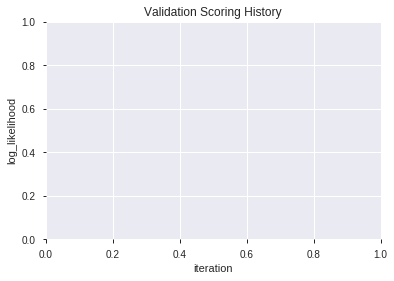

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190825_134000  0.748316  0.588179              0.312758  0.449304  0.201874
1  XGBoost_grid_1_AutoML_20190825_134000_model_2  0.743969  0.598182              0.300804  0.453612  0.205764
2  XGBoost_grid_1_AutoML_20190825_134000_model_1  0.726473  0.605988              0.347859  0.458757  0.210458
3  XGBoost_grid_1_AutoML_20190825_134000_model_6  0.722778  0.615177              0.370191  0.461697  0.213164
4               XGBoost_2_AutoML_20190825_134000  0.712345  0.614489              0.364269  0.461951  0.213399
5               XGBoost_3_AutoML_20190825_134000  0.711041  0.613892              0.364160  0.462302  0.213723
6  XGBoost_grid_1_AutoML_20190825_134000_model_3  0.710606  0.617995              0.367692  0.463812  0.215121
7  XGBoost_grid_1_AutoML_20190825_134000_model_4  0.709520  0.622916              0.291350  0.465541  0.216729
8  XGBoost_grid_1_AutoML_20190825_134000_model_7  0.702347  0.619323              0.314714  0.464579  0.215834
9  XGBoost_grid_1_AutoML_20190825_134000_model_5  0.686047  0.636735              0.357096  0.472256  0.223026

variable  relative_importance  scaled_importance  percentage
0               STOCHF_fastk           837.131409           1.000000    0.105379
1                CDLLONGLINE           387.286133           0.462635    0.048752
2                     TRANGE           365.156738           0.436200    0.045966
3                    WILLR_8           336.188904           0.401596    0.042320
4                  PLUS_DM_8           205.356506           0.245310    0.025850
..                       ...                  ...                ...         ...
97                  SAR_0.24            12.346209           0.014748    0.001554
98              HT_TRENDMODE             6.749996           0.008063    0.000850
99            CDLSPINNINGTOP             6.682498           0.007983    0.000841
100  BBANDS_lowerband_20_2_4             4.850904           0.005795    0.000611
101               MACDFIX_24             3.828314           0.004573    0.000482

[102 rows x 4 columns]

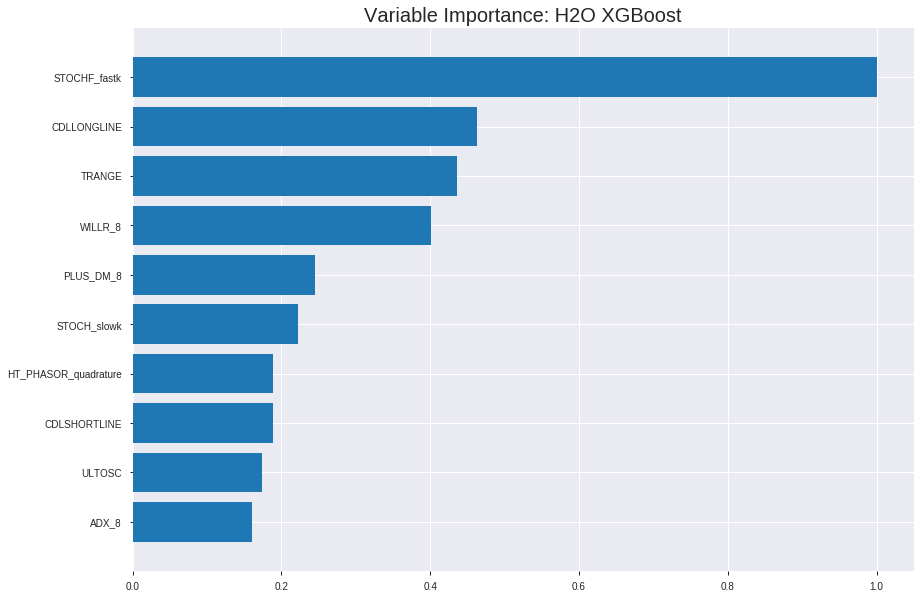

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190825_134000


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1105673587681116
RMSE: 0.3325167044948443
LogLoss: 0.38438985394563924
Mean Per-Class Error: 0.08548041507295645
AUC: 0.9688285787646975
pr_auc: 0.9619625200797112
Gini: 0.937657157529395
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49038367718458176: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      665  59   0.0815   (59.0/724.0)
1      56   568  0.0897   (56.0/624.0)
Total  721  627  0.0853   (115.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490384     0.908074  195
max f2                       0.407539     0.932466  232
max f0point5                 0.580608     0.918836  152
max accuracy                 0.499625     0.91543   192
max precision                0.92177      1         0
max recall                   0.181473     1         345
max specificity              0.92177      1         0
max absolute_mcc             0.499625     0.829833  192
max min_per_class_accuracy   0.480802     0.912983  198
max mean_per_class_accuracy  0.499625     0.91452   192

Gains/Lift Table: Avg response rate: 46.29 %, avg score: 46.30 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.879256           2.16026    2.16026            1                0.89535   1                           0.89535             0.0224359       0.0224359                  116.026   116.026
    2        0.0200297                   0.865879           2.16026    2.16026            1                0.872481  1                           0.884339            0.0208333       0.0432692                  116.026   116.026
    3        0.0304154                   0.852642           2.16026    2.16026            1                0.858883  1                           0.875647            0.0224359       0.0657051                  116.026   116.026
    4        0.0400593                   0.84211            2.16026    2.16026            1                0.847739  1                           0.868928            0.0208333       0.0865385                  116.026   116.026
    5        0.0504451                   0.833375           2.16026    2.16026            1                0.837209  1                           0.862398            0.0224359       0.108974                   116.026   116.026
    6        0.100148                    0.789975           2.12801    2.14425            0.985075         0.811177  0.992593                    0.836977            0.105769        0.214744                   112.801   114.425
    7        0.150593                    0.743361           2.09672    2.12833            0.970588         0.765535  0.985222                    0.813046            0.105769        0.320513                   109.672   112.833
    8        0.200297                    0.707888           2.09577    2.12025            0.970149         0.726227  0.981481                    0.791502            0.104167        0.424679                   109.577   112.025
    9        0.300445                    0.637371           2.09625    2.11225            0.97037          0.674043  0.977778                    0.752349            0.209936        0.634615                   109.625   111.225
    10       0.399852                    0.555743           1.78947    2.032              0.828358         0.59554   0.940631                    0.713365            0.177885        0.8125                     78.9466   103.2
    11       0.5                         0.452637           1.24815    1.875              0.577778         0.505359  0.867953                    0.671702            0.125           0.9375                     24.8148   87.5
    12       0.600148                    0.353359           0.400047   1.62887            0.185185         0.400503  0.754017                    0.626446            0.0400641       0.977564                   -59.9953  62.8871
    13       0.699555                    0.278372           0.161213   1.42032            0.0746269        0.313958  0.657476                    0.582042            0.0160256       0.99359                    -83.8787  42.0317
    14       0.799703                    0.218474           0.0320038  1.24646            0.0148148        0.248997  0.576994                    0.540334            0.00320513      0.996795                   -96.7996  24.6456
    15       0.899852                    0.158168           0.0320038  1.11129            0.0148148        0.186506  0.514427                    0.500955            0.00320513      1                          -96.7996  11.1294
    16       1                           0.0604815          0          1                  0                0.121833  0.462908                    0.46



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2019546157318354
RMSE: 0.4493936089129833
LogLoss: 0.588805950325992
Mean Per-Class Error: 0.2922698789974071
AUC: 0.7598584701815039
pr_auc: 0.7077252953981352
Gini: 0.5197169403630078
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5000709295272827: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      133  75   0.3606   (75.0/208.0)
1      41   137  0.2303   (41.0/178.0)
Total  174  212  0.3005   (116.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.500071     0.702564  211
max f2                       0.250093     0.829361  336
max f0point5                 0.643923     0.681159  127
max accuracy                 0.516877     0.704663  199
max precision                0.905002     1         0
max recall                   0.131576     1         374
max specificity              0.905002     1         0
max absolute_mcc             0.511844     0.414655  201
max min_per_class_accuracy   0.538375     0.696629  186
max mean_per_class_accuracy  0.511844     0.70773   201

Gains/Lift Table: Avg response rate: 46.11 %, avg score: 51.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.87873            1.6264    1.6264             0.75             0.898986  0.75                        0.898986            0.0168539       0.0168539                  62.6404   62.6404
    2        0.0207254                   0.867089           2.16854   1.89747            1                0.872043  0.875                       0.885515            0.0224719       0.0393258                  116.854   89.7472
    3        0.0310881                   0.845096           1.08427   1.6264             0.5              0.85573   0.75                        0.875587            0.011236        0.0505618                  8.42697   62.6404
    4        0.0414508                   0.83939            1.6264    1.6264             0.75             0.842754  0.75                        0.867378            0.0168539       0.0674157                  62.6404   62.6404
    5        0.0518135                   0.829498           2.16854   1.73483            1                0.832608  0.8                         0.860424            0.0224719       0.0898876                  116.854   73.4831
    6        0.101036                    0.779533           2.05441   1.89052            0.947368         0.809547  0.871795                    0.835638            0.101124        0.191011                   105.441   89.0521
    7        0.150259                    0.740316           1.59787   1.79465            0.736842         0.761304  0.827586                    0.811287            0.0786517       0.269663                   59.7871   79.4653
    8        0.202073                    0.713538           1.73483   1.77931            0.8              0.725026  0.820513                    0.789169            0.0898876       0.359551                   73.4831   77.9314
    9        0.300518                    0.656115           1.1984    1.58902            0.552632         0.684123  0.732759                    0.754757            0.117978        0.477528                   19.8403   58.9016
    10       0.401554                    0.592993           1.22328   1.49699            0.564103         0.628515  0.690323                    0.722993            0.123596        0.601124                   22.3279   49.6992
    11       0.5                         0.525391           1.08427   1.41573            0.5              0.559321  0.65285                     0.690768            0.106742        0.707865                   8.42697   41.573
    12       0.601036                    0.473937           0.889657  1.3273             0.410256         0.496719  0.612069                    0.658147            0.0898876       0.797753                   -11.0343  32.7296
    13       0.699482                    0.372298           0.627735  1.22884            0.289474         0.419582  0.566667                    0.624572            0.0617978       0.859551                   -37.2265  22.8839
    14       0.800518                    0.298604           0.834054  1.17901            0.384615         0.331117  0.543689                    0.587534            0.0842697       0.94382                    -16.5946  17.9012
    15       0.898964                    0.22251            0.399468  1.09364            0.184211         0.262503  0.504323                    0.551939            0.0393258       0.983146                   -60.0532  9.36438
    16       1                           0.0755446          0.166811  1                  0.0769231        0.157412  0.46114                     0.512078          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 13:40:00  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.537092                         0.5                0.693147              0.5               0                    1                  0.53886
    2019-08-25 13:40:00  0.122 sec   5                  0.473082         0.640485            0.860154        0.833966           2.16026          0.215134                         0.484251           0.661976              0.724395          0.680161             1.73483            0.365285
    2019-08-25 13:40:00  0.187 sec   10                 0.452436         0.601131            0.879715        0.862851           2.16026          0.198813                         0.474775           0.643194              0.728041          0.682137             1.08427            0.373057
    2019-08-25 13:40:00  0.260 sec   15                 0.43379          0.566141            0.900097        0.88378            2.16026          0.188427                         0.465336           0.624449              0.746583          0.702516             1.6264             0.34715
    2019-08-25 13:40:00  0.323 sec   20                 0.418116         0.5368              0.911146        0.894638           2.16026          0.160237                         0.458374           0.610268              0.75528           0.71068              2.16854            0.357513
    2019-08-25 13:40:00  0.388 sec   25                 0.40506          0.512566            0.922984        0.911252           2.16026          0.15727                          0.454639           0.602223              0.757536          0.703898             2.16854            0.360104
    2019-08-25 13:40:00  0.452 sec   30                 0.393254         0.490693            0.929908        0.917416           2.16026          0.148368                         0.452586           0.597196              0.755753          0.709145             2.16854            0.360104
    2019-08-25 13:40:00  0.515 sec   35                 0.383086         0.471767            0.933872        0.92236            2.16026          0.135015                         0.450671           0.592659              0.756347          0.711273             2.16854            0.365285
    2019-08-25 13:40:01  0.576 sec   40                 0.37392          0.455147            0.940013        0.927992           2.16026          0.126113                         0.450928           0.592453              0.753376          0.710824             2.16854            0.300518
    2019-08-25 13:40:01  0.644 sec   45                 0.363466         0.436875            0.94849         0.937982           2.16026          0.115727                         0.449026           0.588037              0.757671          0.715431             2.16854            0.349741
    2019-08-25 13:40:01  0.708 sec   50                 0.355036         0.421998            0.953482        0.944229           2.16026          0.114985                         0.448577           0.58687               0.757617          0.713468             2.16854            0.321244
    2019-08-25 13:40:01  0.775 sec   55                 0.347242         0.408563            0.958454        0.949693           2.16026          0.101632                         0.448293           0.586116              0.758238          0.7

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
STOCHF_fastk             837.1314086914062      1.0                   0.1053786831465508
CDLLONGLINE              387.2861328125         0.4626348131148263    0.04875184738379102
TRANGE                   365.15673828125        0.436200021275105     0.045966183830468
WILLR_8                  336.18890380859375     0.40159633280767737   0.04231969270775699
PLUS_DM_8                205.35650634765625     0.24530976166414192   0.025850419647161504
---                      ---                    ---                   ---
SAR_0.24                 12.346208572387695     0.014748232409159203  0.0015541493100164792
HT_TRENDMODE             6.749996185302734      0.008063245644855504  0.0008496942079420338
CDLSPINNINGTOP           6.682497501373291      0.007982614714957703  0.0008411974267285218
BBANDS_lowerband_20_2_4  4.85090446472168       0.005794675022771581  0.0006106352231618784
MACDFIX_24               3.8283143043518066     0.004573134235085243  0.0004819108635456918


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7098445595854922)

('F1', 0.6981132075471699)

('auc', 0.7483155835687894)

('logloss', 0.5881792787076583)

('mean_per_class_error', 0.3039013257987394)

('rmse', 0.44930411783002194)

('mse', 0.20187419029901427)

xgboost prediction progress: |████████████████████████████████████████████| 100%


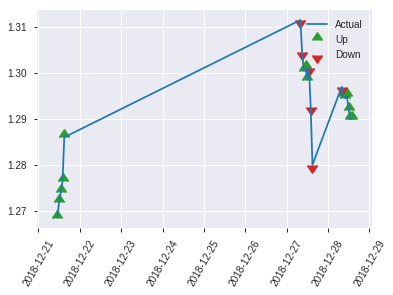


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20187419029901427
RMSE: 0.44930411783002194
LogLoss: 0.5881792787076583
Mean Per-Class Error: 0.3039013257987394
AUC: 0.7483155835687894
pr_auc: 0.70234364777032
Gini: 0.4966311671375787
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3619471490383148: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      55   52   0.486    (52.0/107.0)
1      12   74   0.1395   (12.0/86.0)
Total  67   126  0.3316   (64.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.361947     0.698113  125
max f2                       0.158633     0.820611  179
max f0point5                 0.553743     0.684358  67
max accuracy                 0.553743     0.709845  67
max precision                0.844404     1         0
max recall                   0.158633     1         179
max specificity              0.844404     1         0
max absolute_mcc             0.553743     0.408072  67
max min_per_class_accuracy   0.471237     0.663551  93
max mean_per_class_accuracy  0.553743     0.696099  67

Gains/Lift Table: Avg response rate: 44.56 %, avg score: 45.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.842073           2.24419   2.24419            1                0.844119  1                           0.844119            0.0232558       0.0232558                  124.419   124.419
    2        0.0207254                   0.824325           2.24419   2.24419            1                0.834905  1                           0.839512            0.0232558       0.0465116                  124.419   124.419
    3        0.0310881                   0.813668           2.24419   2.24419            1                0.821589  1                           0.833538            0.0232558       0.0697674                  124.419   124.419
    4        0.0414508                   0.798709           2.24419   2.24419            1                0.810513  1                           0.827782            0.0232558       0.0930233                  124.419   124.419
    5        0.0518135                   0.784796           1.12209   2.01977            0.5              0.790984  0.9                         0.820422            0.0116279       0.104651                   12.2093   101.977
    6        0.103627                    0.727603           1.57093   1.79535            0.7              0.759632  0.8                         0.790027            0.0813953       0.186047                   57.093    79.5349
    7        0.150259                    0.676087           2.24419   1.93464            1                0.69651   0.862069                    0.761004            0.104651        0.290698                   124.419   93.4643
    8        0.202073                    0.641984           1.34651   1.78384            0.6              0.656992  0.794872                    0.734334            0.0697674       0.360465                   34.6512   78.384
    9        0.300518                    0.579642           1.18115   1.58641            0.526316         0.614568  0.706897                    0.695101            0.116279        0.476744                   18.1151   58.6407
    10       0.398964                    0.515545           1.18115   1.48641            0.526316         0.546817  0.662338                    0.658511            0.116279        0.593023                   18.1151   48.6409
    11       0.502591                    0.457527           1.00988   1.38816            0.45             0.490872  0.618557                    0.623946            0.104651        0.697674                   0.988372  38.8156
    12       0.601036                    0.403895           0.826805  1.29621            0.368421         0.426073  0.577586                    0.591536            0.0813953       0.77907                    -17.3195  29.6211
    13       0.699482                    0.330695           0.94492   1.24677            0.421053         0.365818  0.555556                    0.559768            0.0930233       0.872093                   -5.50796  24.677
    14       0.797927                    0.28698            0.47246   1.15124            0.210526         0.305641  0.512987                    0.528415            0.0465116       0.918605                   -52.754   15.1238
    15       0.896373                    0.184579           0.47246   1.07669            0.210526         0.241642  0.479769                    0.49692             0.0465116       0.965116                   -52.754   7.66904
    16       1                           0.0843768          0.336628  1                  0.15             0.139493  0.445596                    0.459881           

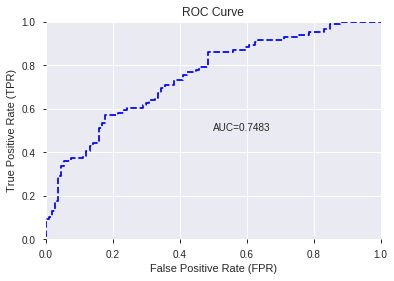

This function is available for GLM models only


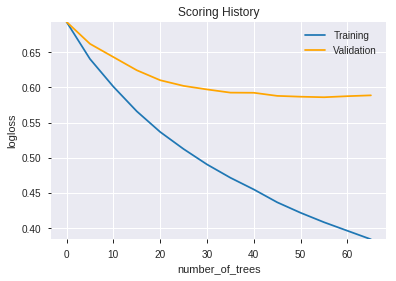

--2019-08-25 13:40:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.10.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.10.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190825_134000',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190825_134000',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a23f',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_a23f',
   'ty

['STOCHF_fastk',
 'CDLLONGLINE',
 'TRANGE',
 'WILLR_8',
 'PLUS_DM_8',
 'STOCH_slowk',
 'HT_PHASOR_quadrature',
 'CDLSHORTLINE',
 'ULTOSC',
 'ADX_8',
 'DX_8',
 'CORREL_14',
 'STOCH_slowd',
 'ADOSC',
 'WILLR_24',
 'MACDEXT_hist',
 'ATR_30',
 'CORREL_8',
 'BETA_8',
 'BETA_14',
 'aroonup_8',
 'MOM_12',
 'MINUS_DM_30',
 'WILLR_20',
 'PLUS_DM_20',
 'MFI_24',
 'WILLR_12',
 'MACDFIX_hist_12',
 'MFI_8',
 'LINEARREG_ANGLE_8',
 'NATR_8',
 'BETA_12',
 'PLUS_DM_24',
 'APO',
 'STOCHRSI_fastd',
 'MOM_8',
 'MFI_20',
 'MINUS_DM_20',
 'PLUS_DI_20',
 'PLUS_DI_12',
 'CORREL_12',
 'VAR_8',
 'PLUS_DM_14',
 'ATR_20',
 'BBANDS_lowerband_30_7_5',
 'PLUS_DI_8',
 'STDDEV_12',
 'DX_20',
 'ATR_8',
 'ROCP_14',
 'ROCP_30',
 'RSI_12',
 'aroonup_30',
 'RSI_20',
 'MACDFIX_signal_14',
 'LINEARREG_ANGLE_12',
 'CCI_12',
 'MA_24_2',
 'STOCHF_fastd',
 'PPO',
 'AROONOSC_24',
 'CCI_30',
 'AROONOSC_30',
 'MACDFIX_12',
 'aroondown_20',
 'VAR_12',
 'MA_20_5',
 'LINEARREG_INTERCEPT_12',
 'aroonup_20',
 'MINUS_DM_14',
 'LINEARREG_

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.725
GLM             0.725
XGBoost         0.756
dtype: float64

DeepLearning    GLM  XGBoost
All          0.720  0.699    0.736
DLF          0.725  0.720    0.705
Fwe          0.725  0.725    0.756
RFE          0.674  0.674    0.710
XGBF         0.725  0.720    0.705





F1


DeepLearning    0.737
GLM             0.714
XGBoost         0.735
dtype: float64

DeepLearning    GLM  XGBoost
All          0.709  0.712    0.722
DLF          0.732  0.714    0.707
Fwe          0.737  0.706    0.735
RFE          0.664  0.667    0.698
XGBF         0.715  0.714    0.707





auc


DeepLearning    0.795
GLM             0.774
XGBoost         0.785
dtype: float64

DeepLearning    GLM  XGBoost
All          0.753  0.750    0.771
DLF          0.783  0.770    0.762
Fwe          0.795  0.774    0.785
RFE          0.703  0.705    0.748
XGBF         0.777  0.770    0.762





logloss


DeepLearning    1.369
GLM             0.628
XGBoost         0.588
dtype: float64

DeepLearning    GLM  XGBoost
All          1.369  0.585    0.574
DLF          0.650  0.569    0.575
Fwe          0.557  0.564    0.556
RFE          0.637  0.628    0.588
XGBF         0.568  0.569    0.575





mean_per_class_error


DeepLearning    0.330
GLM             0.343
XGBoost         0.304
dtype: float64

DeepLearning    GLM  XGBoost
All          0.293  0.304    0.268
DLF          0.275  0.287    0.288
Fwe          0.269  0.280    0.245
RFE          0.330  0.343    0.304
XGBF         0.278  0.287    0.288





rmse


DeepLearning    0.614
GLM             0.470
XGBoost         0.449
dtype: float64

DeepLearning    GLM  XGBoost
All          0.614  0.449    0.442
DLF          0.463  0.441    0.444
Fwe          0.437  0.439    0.434
RFE          0.471  0.470    0.449
XGBF         0.441  0.441    0.444





mse


DeepLearning    0.377
GLM             0.221
XGBoost         0.202
dtype: float64

DeepLearning    GLM  XGBoost
All          0.377  0.202    0.195
DLF          0.215  0.194    0.197
Fwe          0.191  0.193    0.188
RFE          0.222  0.221    0.202
XGBF         0.195  0.194    0.197

{'F1':       DeepLearning    GLM  XGBoost
 All          0.709    NaN      NaN
 DLF          0.732    NaN      NaN
 DLF            NaN  0.714      NaN
 DLF            NaN    NaN    0.707
 All            NaN  0.712      NaN
 All            NaN    NaN    0.722
 XGBF         0.715    NaN      NaN
 XGBF           NaN  0.714      NaN
 XGBF           NaN    NaN    0.707
 Fwe          0.737    NaN      NaN
 Fwe            NaN  0.706      NaN
 Fwe            NaN    NaN    0.735
 RFE          0.664    NaN      NaN
 RFE            NaN  0.667      NaN
 RFE            NaN    NaN    0.698,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.720    NaN      NaN
 DLF          0.725    NaN      NaN
 DLF            NaN  0.720      NaN
 DLF            NaN    NaN    0.705
 All            NaN  0.699      NaN
 All            NaN    NaN    0.736
 XGBF         0.725    NaN      NaN
 XGBF           NaN  0.720      NaN
 XGBF           NaN    NaN    0.705
 Fwe          0.725    NaN      NaN
 Fwe     